## Modeling for predicting hospitalization at ED triage
## Using outputs from Pre-processing for healthcare analytics Version3


>**Note:** Please run Task_1_Predict_Admission_generalprocessing_MinorTweaksToObtainImputedDataset.ipynb to obtain train_impute_v3a.csv and test_impute_v3a.csv as inputs for this notebook

Objective: To create a model that can predict a patient's need for hospital admission at the time of triage.

The **"time of triage"** is an important consideration as this would mean certain information "after the triage" (for e.g. ED length of stay) would not be available at that point.

### Load train and test datasets

In [1]:
# Import required libraries
import os
import time
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.stats import spearmanr
from pprint import pprint

from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier

from helpers6 import PlotROCCurve

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix, recall_score, f1_score, precision_score, average_precision_score, auc, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import catboost
from catboost import CatBoostClassifier

import optuna

In [2]:
output_path = 'C:\\Users\\kkb74\\Documents\\SMU Study\\ISSS623 - HealthCare Analytics\\Project\\Group Project Data'

path = output_path
df_train = pd.read_csv((os.path.join(path, 'train_impute_v3a.csv')))
df_test = pd.read_csv((os.path.join(path, 'test_impute_v3a.csv')))
confidence_interval = 95
random_seed=0

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None) 
df_train.head()

,intime_ed,outtime_ed,gender,age,outcome_hospitalization,outcome_inhospital_mortality,ed_death,outcome_icu_transfer_12h,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,insurance_Medicaid,insurance_Medicare,insurance_Other,age_group_Young Adults,age_group_Middle-Aged Adults,age_group_Older Adults,age_group_Elderly,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,2188-11-01 02:09:00,2188-11-01 02:17:00,1,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.13,35.944444,108.0,18.0,97.0,146.0,97.0,0.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.277778,87.0,16.0,100.0,104.0,70.0,2.0,0.0,0.0,0,0,0,1,0,0,0,113.333333,0,0,2,2,2,2
1,2128-08-31 14:56:00,2128-08-31 15:25:00,0,44.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.48,37.000000,79.0,14.0,100.0,164.0,96.0,0.0,3.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.888889,58.0,18.0,99.0,122.0,71.0,0.0,2.0,3.0,0,0,0,0,1,0,0,118.666667,0,0,2,0,0,0
2,2180-02-28 22:22:00,2180-02-29 02:41:00,0,64.0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,4.32,36.777778,116.0,14.0,100.0,118.0,70.0,3.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.000000,114.0,22.0,93.0,120.0,46.0,0.0,1.0,6.0,0,1,0,0,1,0,0,86.000000,2,8,5,2,2,2
3,2187-07-26 16:03:00,2187-07-26 20:15:00,0,62.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.20,36.666667,58.0,18.0,98.0,124.0,73.0,5.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.000000,71.0,18.0,96.0,125.0,79.0,5.0,0.0,4.0,0,0,1,0,1,0,0,90.000000,2,4,5,0,0,1
4,2115-06-20 17:48:00,2115-06-20 20:30:00,0,47.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.70,36.555556,105.0,18.0,98.0,139.0,110.0,0.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.555556,89.0,18.0,100.0,135.0,85.0,0.0,2.0,18.0,0,0,1,0,1,0,0,119.666667,0,0,4,1,1,2


In [4]:
# Display the DataFrame information
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352115 entries, 0 to 352114
Columns: 109 entries, intime_ed to score_MEWS
dtypes: float64(20), int64(87), object(2)
memory usage: 292.8+ MB
None


In [5]:
# Convert column names to a list and print all 109 entries
column_list = df_train.columns.tolist()
print(column_list)

['intime_ed', 'outtime_ed', 'gender', 'age', 'outcome_hospitalization', 'outcome_inhospital_mortality', 'ed_death', 'outcome_icu_transfer_12h', 'outcome_critical', 'n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'outcome_ed_revisit_3d', 'n_hosp_30d', 'n_hosp_90d', 'n_hosp_365d', 'n_icu_30d', 'n_icu_90d', 'n_icu_365d', 'ed_los_hours', 'triage_temperature', 'triage_heartrate', 'triage_resprate', 'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain', 'triage_acuity', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain', 'chiefcom_headache', 'chiefcom_shortness_of_breath', 'chiefcom_back_pain', 'chiefcom_cough', 'chiefcom_nausea_vomiting', 'chiefcom_fever_chills', 'chiefcom_syncope', 'chiefcom_dizziness', 'cci_MI', 'cci_CHF', 'cci_PVD', 'cci_Stroke', 'cci_Dementia', 'cci_Pulmonary', 'cci_Rheumatic', 'cci_PUD', 'cci_Liver1', 'cci_DM1', 'cci_DM2', 'cci_Paralysis', 'cci_Renal', 'cci_Cancer1', 'cci_Liver2', 'cci_Cancer2', 'cci_HIV', 'eci_CHF', 'eci_Arrhythmia', 'eci_Valvular', 'eci_PHTN', 'eci_PVD', 'eci

### 1. Additional data processing for Task 1

#### (i) Drop Features that are not used for Task_1

In [6]:
features_to_drop = [
    # Features not related to Task_1
    # ed_death == 1 records were excluded in data_generation step 
    'outcome_inhospital_mortality', 'ed_death', 'outcome_icu_transfer_12h', 'outcome_critical', 'outcome_ed_revisit_3d',
    
    # Features that won't be available at point of triage
    'outtime_ed','ed_los_hours', 'ed_temperature_last', 'ed_heartrate_last', 'ed_resprate_last',
    'ed_o2sat_last', 'ed_sbp_last', 'ed_dbp_last', 'ed_pain_last', 'n_med', 
    'insurance_Medicaid', 'insurance_Medicare', 'insurance_Other','insurance_Medicaid', 'insurance_Medicare', 'insurance_Other',
    
    # repeated feature
    'age_group_Young Adults', 'age_group_Middle-Aged Adults', 'age_group_Older Adults', 'age_group_Elderly'
]

In [7]:
df_train = df_train.drop(features_to_drop, axis = 1)
df_test = df_test.drop(features_to_drop, axis = 1)

In [8]:
# Convert column names to a list and print
column_list = df_train.columns.tolist()
print(column_list)
print(df_train.shape, df_test.shape)

['intime_ed', 'gender', 'age', 'outcome_hospitalization', 'n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'n_hosp_30d', 'n_hosp_90d', 'n_hosp_365d', 'n_icu_30d', 'n_icu_90d', 'n_icu_365d', 'triage_temperature', 'triage_heartrate', 'triage_resprate', 'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain', 'triage_acuity', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain', 'chiefcom_headache', 'chiefcom_shortness_of_breath', 'chiefcom_back_pain', 'chiefcom_cough', 'chiefcom_nausea_vomiting', 'chiefcom_fever_chills', 'chiefcom_syncope', 'chiefcom_dizziness', 'cci_MI', 'cci_CHF', 'cci_PVD', 'cci_Stroke', 'cci_Dementia', 'cci_Pulmonary', 'cci_Rheumatic', 'cci_PUD', 'cci_Liver1', 'cci_DM1', 'cci_DM2', 'cci_Paralysis', 'cci_Renal', 'cci_Cancer1', 'cci_Liver2', 'cci_Cancer2', 'cci_HIV', 'eci_CHF', 'eci_Arrhythmia', 'eci_Valvular', 'eci_PHTN', 'eci_PVD', 'eci_HTN1', 'eci_HTN2', 'eci_Paralysis', 'eci_NeuroOther', 'eci_Pulmonary', 'eci_DM1', 'eci_DM2', 'eci_Hypothyroid', 'eci_Renal', 'eci_Liver', 'eci_PUD

#### (ii) Create "age" bins using bin_width interval of 5 years

In [9]:
# Define the minimum and maximum age values and the bin interval
min_age = int(df_train['age'].min())
max_age = int(df_train['age'].max())
bin_interval = 5

# Create bin edges using fixed-width binning with a 5-year interval
bin_edges = list(range(min_age, max_age, bin_interval)) + [float('inf')]

# Apply the binning to the 'age' column for train dataset
df_train['age_binned'] = pd.cut(df_train['age'], bins=bin_edges, right=False)
# Remove the original 'age' column
df_train = df_train.drop(['age'],axis=1)

## Apply the binning to the 'age' column for test dataset
df_test['age_binned'] = pd.cut(df_test['age'], bins=bin_edges, right=False)
# Remove the original 'age' column
df_test = df_test.drop(['age'],axis=1)

print(df_train.shape, df_test.shape)

(352115, 87) (88029, 87)


In [10]:
# Modify the format of age ranges in the 'age_binned' column
# the default format for the age categories are in [18.0,23.0) format. The "[" and ")" might be a problem for some modelling algos
df_train['age_binned'] = df_train['age_binned'].astype(str)
df_train['age_binned'] = df_train['age_binned'].str.replace('[','').str.replace(')','').str.replace(', ', '_').str.replace('.0','')

df_test['age_binned'] = df_test['age_binned'].astype(str)
df_test['age_binned'] = df_test['age_binned'].str.replace('[','').str.replace(')','').str.replace(', ', '_').str.replace('.0','')


C:\Users\kkb74\AppData\Local\Temp\ipykernel_3724\2014313421.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_train['age_binned'] = df_train['age_binned'].str.replace('[','').str.replace(')','').str.replace(', ', '_').str.replace('.0','')
C:\Users\kkb74\AppData\Local\Temp\ipykernel_3724\2014313421.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train['age_binned'] = df_train['age_binned'].str.replace('[','').str.replace(')','').str.replace(', ', '_').str.replace('.0','')
C:\Users\kkb74\AppData\Local\Temp\ipykernel_3724\2014313421.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_test['age_binned'] = df_test['a

In [11]:
df_train['age_binned'].value_counts()

53_58     30712
58_63     29730
23_28     27984
63_68     27431
48_53     27416
28_33     25312
18_23     25091
68_73     24849
43_48     22137
33_38     22056
38_43     20395
73_78     20115
78_83     17234
83_88     15049
88_93     12799
93_98      3531
98_inf      274
Name: age_binned, dtype: int64

#### (ii) Create "day_of_week", "hour_of_day" using "intime_ed" column

In [12]:
## For the df_train dataset
# Assuming your DataFrame is named df
df_train['intime_ed'] = pd.to_datetime(df_train['intime_ed'], format='%Y-%m-%d %H:%M:%S')
# Extracting the day of the week (Monday=0, Sunday=6)
df_train['day_of_week'] = df_train['intime_ed'].dt.dayofweek
# map the numeric representation to the day names.
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_train['day_of_week'] = df_train['day_of_week'].map(lambda x: day_names[x])
# Extracting the hour of the day (in 24-hour format)
df_train['hour_of_day'] = df_train['intime_ed'].dt.hour
# Remove the original 'intime_ed' column
df_train = df_train.drop(['intime_ed'],axis=1)

## For the df_test dataset
# Assuming your DataFrame is named df
df_test['intime_ed'] = pd.to_datetime(df_test['intime_ed'], format='%Y-%m-%d %H:%M:%S')
# Extracting the day of the week (Monday=0, Sunday=6)
df_test['day_of_week'] = df_test['intime_ed'].dt.dayofweek
# map the numeric representation to the day names.
df_test['day_of_week'] = df_test['day_of_week'].map(lambda x: day_names[x])
# Extracting the hour of the day (in 24-hour format)
df_test['hour_of_day'] = df_test['intime_ed'].dt.hour
# Remove the original 'intime_ed' column
df_test = df_test.drop(['intime_ed'],axis=1)

print(df_train.shape, df_test.shape)

(352115, 88) (88029, 88)


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352115 entries, 0 to 352114
Data columns (total 88 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   gender                        352115 non-null  int64  
 1   outcome_hospitalization       352115 non-null  int64  
 2   n_ed_30d                      352115 non-null  int64  
 3   n_ed_90d                      352115 non-null  int64  
 4   n_ed_365d                     352115 non-null  int64  
 5   n_hosp_30d                    352115 non-null  int64  
 6   n_hosp_90d                    352115 non-null  int64  
 7   n_hosp_365d                   352115 non-null  int64  
 8   n_icu_30d                     352115 non-null  int64  
 9   n_icu_90d                     352115 non-null  int64  
 10  n_icu_365d                    352115 non-null  int64  
 11  triage_temperature            352115 non-null  float64
 12  triage_heartrate              352115 non-nul

### 2. Variable Selection

In [14]:
# Assign target variable
outcome = "outcome_hospitalization"

In [15]:
# Create X_train, y_train, X_test, y_test
X_train = df_train.drop(outcome,axis=1).copy()
y_train = df_train[outcome].copy()
X_test = df_test.drop(outcome,axis=1).copy()
y_test = df_test[outcome].copy()

In [16]:
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(352115, 87) (352115,)
(88029, 87) (88029,)


(i) Perform one-hot encoding for categorical variables

In [17]:
# Assign a list to capture all categorical variables
# more categorical variables can be added to this list
cat_features = ['age_binned','day_of_week','hour_of_day']

enc = OneHotEncoder(drop='first') # first col dropped
enc.fit(X_train[cat_features])

# One-hot encoding for categorical variable in the train set
feature_enc_train = pd.DataFrame(enc.transform(X_train[cat_features]).toarray())
# Assign column header for the encoded field
feature_enc_train.columns = enc.get_feature_names_out(cat_features)
# drop original columns
X_train = X_train.drop(columns = cat_features)
# join dfs together
X_train = X_train.join(feature_enc_train) 

# One-hot encoding for categorical variable in the test set
feature_enc_test = pd.DataFrame(enc.transform(X_test[cat_features]).toarray())
feature_enc_test.columns = enc.get_feature_names_out(cat_features)
# drop original columns
X_test= X_test.drop(columns = cat_features)
# join dfs together
X_test = X_test.join(feature_enc_test) 

In [18]:
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(352115, 129) (352115,)
(88029, 129) (88029,)


### 3. Multivariate/Correlation Analysis on Numerical Variables

In [19]:
# List the numerical variables which require scaling
num_features = ['n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'n_hosp_30d', 'n_hosp_90d',
       'n_hosp_365d', 'n_icu_30d', 'n_icu_90d', 'n_icu_365d',
       'triage_temperature', 'triage_heartrate', 'triage_resprate',
       'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain',
       'triage_acuity','triage_MAP', 'score_CCI', 'score_CART', 'score_REMS',
       'score_NEWS', 'score_NEWS2', 'score_MEWS','n_medrecon']

# Derive correlation matrix not assuming parametric variables
X_train_num = X_train[num_features]
correlation_matrix = X_train_num.corr(method='spearman')

correlation_matrix

,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS,n_medrecon
n_ed_30d,1.000000,0.759687,0.566849,0.652313,0.528207,0.430082,0.247105,0.212414,0.204707,-0.004006,0.049036,0.023421,-0.033753,-0.038953,-0.021858,0.018872,0.000519,-0.033890,0.173206,0.036497,0.028682,0.055991,0.053483,0.037693,0.121962
n_ed_90d,0.759687,1.000000,0.762587,0.516433,0.705104,0.595004,0.193405,0.293995,0.295837,-0.004412,0.060302,0.040929,-0.049465,-0.044178,-0.036526,0.023802,-0.023693,-0.045714,0.270302,0.072911,0.063109,0.077757,0.072490,0.057338,0.209034
n_ed_365d,0.566849,0.762587,1.000000,0.390946,0.553931,0.731026,0.140168,0.222296,0.335522,-0.013584,0.053302,0.055030,-0.059122,-0.023297,-0.035313,0.045041,-0.022847,-0.034275,0.352956,0.102995,0.097350,0.081168,0.073331,0.061645,0.292435
n_hosp_30d,0.652313,0.516433,0.390946,1.000000,0.746440,0.555771,0.289872,0.248777,0.236861,0.009653,0.054567,0.039877,-0.066118,-0.052878,-0.057706,-0.027768,-0.084046,-0.063922,0.261900,0.104211,0.091335,0.081414,0.073889,0.060799,0.179550
n_hosp_90d,0.528207,0.705104,0.553931,0.746440,1.000000,0.760681,0.222826,0.337465,0.339204,0.010315,0.066212,0.061043,-0.088272,-0.059804,-0.075052,-0.034106,-0.114654,-0.078205,0.380557,0.151014,0.136751,0.107869,0.096759,0.083235,0.274247
n_hosp_365d,0.430082,0.595004,0.731026,0.555771,0.760681,1.000000,0.165409,0.258372,0.382224,0.004199,0.058039,0.077314,-0.109533,-0.039047,-0.076997,-0.024159,-0.128650,-0.068517,0.497761,0.197045,0.188365,0.116501,0.100968,0.090931,0.372229
n_icu_30d,0.247105,0.193405,0.140168,0.289872,0.222826,0.165409,1.000000,0.666778,0.466718,0.003090,0.020049,0.027618,-0.033595,-0.030298,-0.036027,-0.031373,-0.064580,-0.037931,0.114919,0.060530,0.052092,0.042593,0.037803,0.036770,0.073148
n_icu_90d,0.212414,0.293995,0.222296,0.248777,0.337465,0.258372,0.666778,1.000000,0.700796,0.003589,0.032417,0.043060,-0.047591,-0.043250,-0.048779,-0.040745,-0.085920,-0.052396,0.180283,0.089452,0.077464,0.068075,0.060285,0.057791,0.120968
n_icu_365d,0.204707,0.295837,0.335522,0.236861,0.339204,0.382224,0.466718,0.700796,1.000000,0.004282,0.037590,0.057059,-0.063891,-0.041119,-0.058630,-0.043596,-0.103312,-0.058274,0.261881,0.120543,0.108279,0.087659,0.076326,0.073161,0.178054
triage_temperature,-0.004006,-0.004412,-0.013584,0.009653,0.010315,0.004199,0.003090,0.003589,0.004282,1.000000,0.158313,0.025884,-0.031630,-0.029915,-0.038738,0.029674,-0.014613,-0.040974,-0.042490,-0.010412,-0.066763,0.011768,0.005504,0.102739,-0.020030


In [20]:
# Calculate the correlation matrix using Spearman's rank correlation
correlation_matrix_spearman, _ = spearmanr(X_train_num)

# Set the threshold for correlation coefficient (absolute value)
threshold = 0.85

# Create a list to store significant variable pairs
significant_pairs = []

# Iterate through the correlation matrix and identify significant pairs
for i, var1 in enumerate(X_train_num.columns):
    for j, var2 in enumerate(X_train_num.columns):
        if i < j:  # To avoid duplicate pairs and correlations with themselves
            correlation = correlation_matrix_spearman[i, j]
            if abs(correlation) > threshold:
                significant_pairs.append((var1, var2, correlation))

# Convert the list of significant pairs into a DataFrame
significant_pairs_df = pd.DataFrame(significant_pairs, columns=['Variable 1', 'Variable 2', 'Correlation'])

# Display the significant pairs with correlation coefficient value > 0.85
print(significant_pairs_df)

   Variable 1   Variable 2  Correlation
0  triage_dbp   triage_MAP     0.893487
1  score_NEWS  score_NEWS2     0.945508


In [21]:
# We will drop truage_dbp and score_NEWS2 given their high correlation scores
# Retain NEWS instead of NEWS2 as the AUROC and AUPRC scores are better for NEWS based on the sample codes
correlated_features = ['triage_dbp','score_NEWS2']

X_train = X_train.drop(columns = correlated_features,axis=1)
X_test = X_test.drop(columns = correlated_features,axis=1)

In [22]:
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(352115, 127) (352115,)
(88029, 127) (88029,)


### 4. Feature Scaling of Numerical Variables

In [23]:
# Uppdate the list the numerical variables which require scaling, excluding those highly correlated variables
num_features = [var for var in num_features if var not in correlated_features]

(i) With MinMaxScaler

In [24]:
# instantiate MinMaxScaler to normalise the numeric fields
minmax = MinMaxScaler()
minmax.fit(X_train[num_features])

# Feature scaling for train set
feature_scaling_train = pd.DataFrame(minmax.transform(X_train[num_features]))
feature_scaling_train.columns = num_features
X_train_minmax = X_train.drop(columns = num_features) # drop original columns
X_train_minmax = X_train_minmax.join(feature_scaling_train) # join dfs together

# Feature scaling for test set
feature_scaling_test = pd.DataFrame(minmax.transform(X_test[num_features]))
feature_scaling_test.columns = num_features
X_test_minmax = X_test.drop(columns = num_features) # drop original columns
X_test_minmax = X_test_minmax.join(feature_scaling_test) # join dfs together

In [25]:
print(X_train_minmax.shape, y_train.shape)
print(X_test_minmax.shape,y_test.shape)

(352115, 127) (352115,)
(88029, 127) (88029,)


In [26]:
X_train_minmax.head()

,gender,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,age_binned_23_28,age_binned_28_33,age_binned_33_38,age_binned_38_43,age_binned_43_48,age_binned_48_53,age_binned_53_58,age_binned_58_63,age_binned_63_68,age_binned_68_73,age_binned_73_78,age_binned_78_83,age_binned_83_88,age_binned_88_93,age_binned_93_98,age_binned_98_inf,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,hour_of_day_1,hour_of_day_2,hour_of_day_3,hour_of_day_4,hour_of_day_5,hour_of_day_6,hour_of_day_7,hour_of_day_8,hour_of_day_9,hour_of_day_10,hour_of_day_11,hour_of_day_12,hour_of_day_13,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_pain,triage_acuity,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_MEWS,n_medrecon
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.549080,0.429719,0.086124,0.97,0.466238,0.0,0.25,0.375862,0.00,0.000000,0.105263,0.166667,0.222222,0.000000
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014286,0.0,0.0,0.0,0.607362,0.313253,0.066986,1.00,0.524116,0.0,0.50,0.394253,0.00,0.000000,0.105263,0.000000,0.000000,0.044776
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.595092,0.461847,0.066986,1.00,0.376206,0.3,0.00,0.281609,0.08,0.166667,0.263158,0.166667,0.222222,0.089552
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.588957,0.228916,0.086124,0.98,0.395498,0.5,0.50,0.295402,0.08,0.083333,0.263158,0.000000,0.111111,0.059701
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.582822,0.417671,0.086124,0.98,0.443730,0.0,0.25,0.397701,0.00,0.000000,0.210526,0.083333,0.2222

(ii) With RobustScaler

In [27]:
# instantiate MinMaxScaler to normalise the numeric fields
robust = RobustScaler()
robust.fit(X_train[num_features])

# Feature scaling for train set
feature_scaling_train = pd.DataFrame(robust.transform(X_train[num_features]))
feature_scaling_train.columns = num_features
X_train_robust = X_train.drop(columns = num_features) # drop original columns
X_train_robust = X_train_robust.join(feature_scaling_train) # join dfs together

# Feature scaling for test set
feature_scaling_test = pd.DataFrame(robust.transform(X_test[num_features]))
feature_scaling_test.columns = num_features
X_test_robust = X_test.drop(columns = num_features) # drop original columns
X_test_robust = X_test_robust.join(feature_scaling_test) # join dfs together

In [28]:
print(X_train_robust.shape, y_train.shape)
print(X_test_robust.shape,y_test.shape)

(352115, 127) (352115,)
(88029, 127) (88029,)


In [29]:
X_train_robust.head()

,gender,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,age_binned_23_28,age_binned_28_33,age_binned_33_38,age_binned_38_43,age_binned_43_48,age_binned_48_53,age_binned_53_58,age_binned_58_63,age_binned_63_68,age_binned_68_73,age_binned_73_78,age_binned_78_83,age_binned_83_88,age_binned_88_93,age_binned_93_98,age_binned_98_inf,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,hour_of_day_1,hour_of_day_2,hour_of_day_3,hour_of_day_4,hour_of_day_5,hour_of_day_6,hour_of_day_7,hour_of_day_8,hour_of_day_9,hour_of_day_10,hour_of_day_11,hour_of_day_12,hour_of_day_13,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_pain,triage_acuity,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_MEWS,n_medrecon
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.444444,1.043478,0.0,-1.0,0.464286,-0.571429,-1.0,0.946429,-0.5,-0.444444,-0.25,1.0,1.0,-0.4
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.666667,-0.217391,-2.0,0.5,1.107143,-0.571429,0.0,1.232143,-0.5,-0.444444,-0.25,-1.0,-1.0,-0.1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,1.391304,-2.0,0.5,-0.535714,-0.142857,-2.0,-0.517857,0.0,0.444444,0.50,1.0,1.0,0.2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-1.130435,0.0,-0.5,-0.321429,0.142857,0.0,-0.303571,0.0,0.000000,0.50,-1.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.222222,0.913043,0.0,-0.5,0.214286,-0.571429,-1.0,1.285714,-0.5,-0.444444,0.25,0.0,1.0,1.4


(iii) With Standard Scaler

In [30]:
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler to normalize the numeric fields
scaler = StandardScaler()
scaler.fit(X_train[num_features])

# Feature scaling for train set
feature_scaling_train = pd.DataFrame(scaler.transform(X_train[num_features]))
feature_scaling_train.columns = num_features
X_train_scaled = X_train.drop(columns=num_features)  # drop original columns
X_train_scaled = X_train_scaled.join(feature_scaling_train)  # join dfs together

# Feature scaling for test set
feature_scaling_test = pd.DataFrame(scaler.transform(X_test[num_features]))
feature_scaling_test.columns = num_features
X_test_scaled = X_test.drop(columns=num_features)  # drop original columns
X_test_scaled = X_test_scaled.join(feature_scaling_test)  # join dfs together

In [31]:
X_train_scaled.head()

,gender,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,age_binned_23_28,age_binned_28_33,age_binned_33_38,age_binned_38_43,age_binned_43_48,age_binned_48_53,age_binned_53_58,age_binned_58_63,age_binned_63_68,age_binned_68_73,age_binned_73_78,age_binned_78_83,age_binned_83_88,age_binned_88_93,age_binned_93_98,age_binned_98_inf,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,hour_of_day_1,hour_of_day_2,hour_of_day_3,hour_of_day_4,hour_of_day_5,hour_of_day_6,hour_of_day_7,hour_of_day_8,hour_of_day_9,hour_of_day_10,hour_of_day_11,hour_of_day_12,hour_of_day_13,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_pain,triage_acuity,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_MEWS,n_medrecon
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.306057,-0.332126,-0.335276,-0.307576,-0.352425,-0.361579,-0.108302,-0.155692,-0.19788,-1.425869,1.314031,0.171128,-0.576592,0.504227,-1.153860,-0.882858,1.125021,-0.804968,-0.823119,-0.559401,0.875941,0.738376,-0.901823
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.306057,-0.332126,-0.335276,-0.307576,-0.352425,0.008258,-0.108302,-0.155692,-0.19788,0.538375,-0.347297,-1.416015,0.663403,1.317345,-1.153860,0.528201,1.483455,-0.804968,-0.823119,-0.559401,-0.734838,-1.572829,-0.458714
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.306057,-0.332126,-0.335276,-0.307576,-0.352425,-0.361579,-0.108302,-0.155692,-0.19788,0.124850,1.772328,-1.416015,0.663403,-0.760623,-0.321185,-2.293916,-0.711958,-0.207833,0.755623,0.518345,0.875941,0.738376,-0.015604
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.306057,-0.332126,-0.335276,-0.307576,-0.352425,-0.361579,-0.108302,-0.155692,-0.19788,-0.081913,-1.550327,0.171128,-0.163260,-0.489584,0.233933,0.528201,-0.443132,-0.207833,-0.033748,0.518345,-0.734838,-0.417227,-0.311011
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0

### 5.  Modeling

#### a. Logistic Regression

In [189]:
# Containers for all results
result_list = []

(i) Model with no scaling of numeric features

Logistic Regression:


C:\Users\kkb74\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.00701904296875 seconds
AUC: 0.8061541613673167
AUPRC: 0.7702274629075453
Sensitivity: 0.7390897979725358
Specificity: 0.7260593494881431
Score thresold: 0.44927603566756047
2.5 97.5


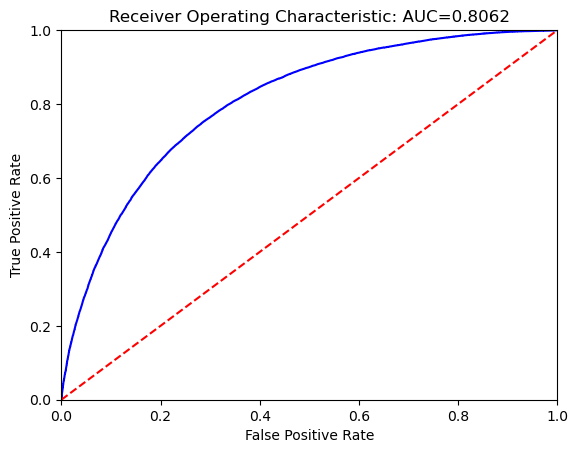

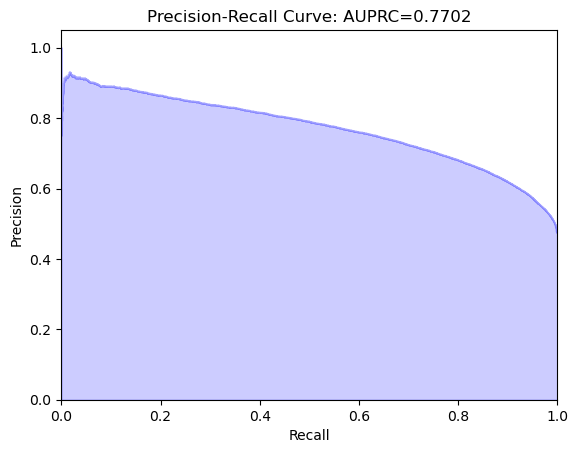

In [190]:
print("Logistic Regression:")

from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=1234)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["LR_without_scaling"]
results.extend(result)
results.append(runtime)
result_list.append(results)

(ii) Model with MinMax Scaling of numeric features

Logistic Regression:


C:\Users\kkb74\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.159219980239868 seconds
AUC: 0.8136501010784151
AUPRC: 0.7830846793640694
Sensitivity: 0.7460636997627436
Specificity: 0.728564640836249
Score thresold: 0.45193231289366
2.5 97.5


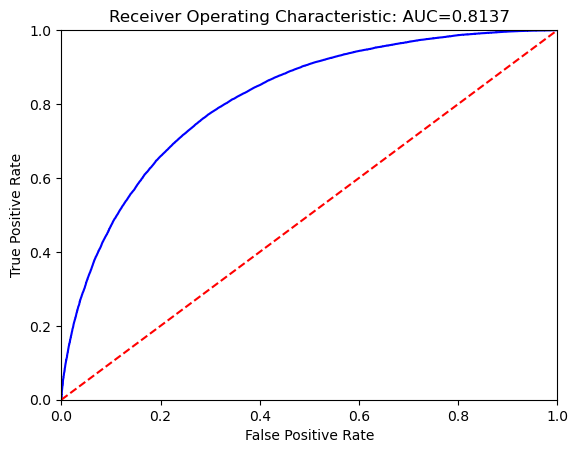

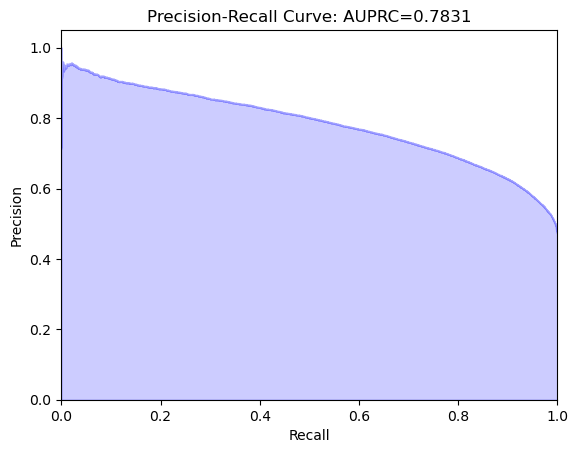

In [191]:
print("Logistic Regression:")

from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=1234)
start = time.time()
logreg.fit(X_train_minmax,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test_minmax)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["LR_with_minmax_scaling"]
results.extend(result)
results.append(runtime)
result_list.append(results)

(iii) Model with Robust Scaling of numeric features

Logistic Regression:


C:\Users\kkb74\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 4.787873983383179 seconds
AUC: 0.8140054791953204
AUPRC: 0.7833072644616768
Sensitivity: 0.745967838569751
Specificity: 0.729925273206341
Score thresold: 0.4533012183349813
2.5 97.5


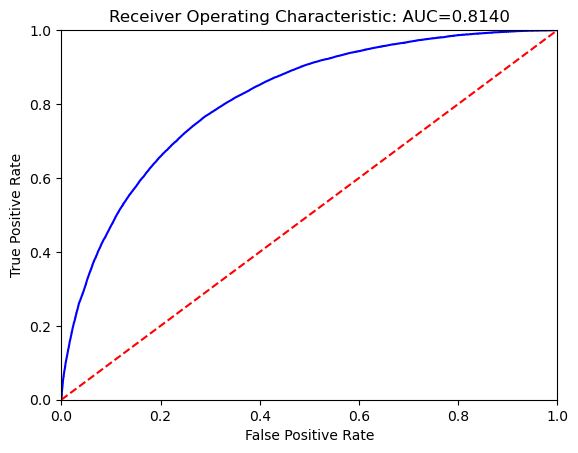

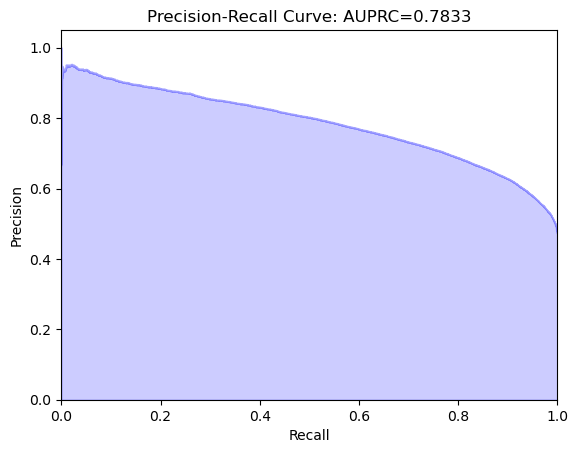

In [192]:
print("Logistic Regression:")

from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=1234)
start = time.time()
logreg.fit(X_train_robust,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test_robust)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["LR_with_robust_scaling"]
results.extend(result)
results.append(runtime)
result_list.append(results)

(iv) Model with Standard Scaling of numeric features

Logistic Regression:


C:\Users\kkb74\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 4.829408645629883 seconds
AUC: 0.8141479283649731
AUPRC: 0.7834643373566437
Sensitivity: 0.755074651904043
Specificity: 0.7220206470562827
Score thresold: 0.44493459911389505
2.5 97.5


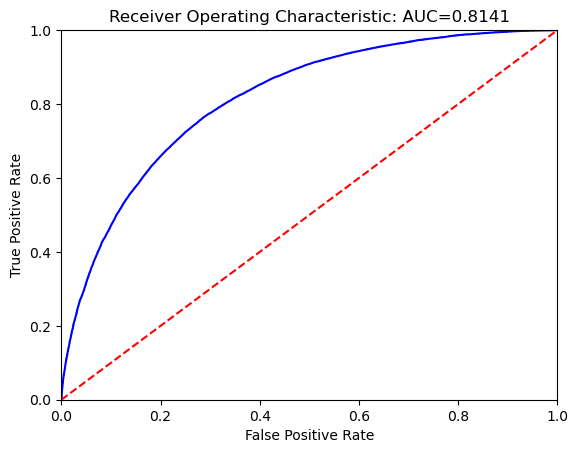

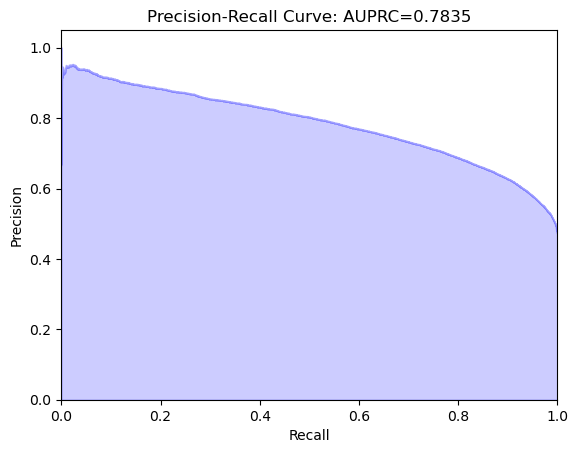

In [193]:
print("Logistic Regression:")

from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=1234)
start = time.time()
logreg.fit(X_train_scaled,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test_scaled)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["LR_with_standard_scaling"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [194]:
# Print hyperparameters used in the current model
print('Parameters currently in use:\n')
pprint(logreg.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1234,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


(v) Model Tuning

In [63]:
# Hyperparameters to tune:

# 1.Penalty type
penalty = ['l1', 'l2','elasticnet']

# 2.C, Inverse of regularization strength
C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# 3.Solver, Algorithm to use in the optimization problem
solver = ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]

# 4.max_iter number of iterations taken for the solvers to converge
max_iter = [300, 400, 500]

- Tune penalty and C

In [64]:
# Create the parameters for tuning
param_grid = {'penalty': penalty,
              'C': C}

print(param_grid)

clf = LogisticRegression(random_state=1234)
# Instantiate the grid search model
lr_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
lr_grid.fit(X_train_scaled,y_train)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

lr_grid_results = pd.DataFrame(lr_grid.cv_results_)

print('Best Score: ', lr_grid.best_score_) 
print('Best Params: ', lr_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
lr_grid_results["mean_roc_auc"] = lr_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
lr_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()

{'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Grid Search Tuning time: 91.18451762199402 seconds
Best Score:  0.8168773644753505
Best Params:  {'C': 0.1, 'penalty': 'l2'}


,param_penalty,param_C,mean_roc_auc,rank_test_score
0,l2,0.1,0.816877,1
1,l2,10.0,0.816849,2
2,l2,100.0,0.816838,3
3,l2,1.0,0.816836,4
4,l2,0.01,0.816793,5


In [65]:
# Since there's an improvement in mean_roc_auc as compared to our model in part (iv) 
# We replace tuned model with the hyperparameters that provide the better results
penalty = [] 
penalty.append(lr_grid.best_params_['penalty'])

C = [] 
C.append(lr_grid.best_params_['C'])

penalty, C

(['l2'], [0.1])

- Tune solver

In [66]:
# Create the parameters for tuning
param_grid = {'penalty': penalty,
              'C': C,
              'solver': solver}

print(param_grid)

clf = LogisticRegression(random_state=1234)
# Instantiate the grid search model
lr_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
lr_grid.fit(X_train_scaled,y_train)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

lr_grid_results = pd.DataFrame(lr_grid.cv_results_)

print('Best Score: ', lr_grid.best_score_) 
print('Best Params: ', lr_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
lr_grid_results["mean_roc_auc"] = lr_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
lr_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()

{'penalty': ['l2'], 'C': [0.1], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Grid Search Tuning time: 203.36731219291687 seconds
Best Score:  0.816906866835809
Best Params:  {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


,param_penalty,param_C,param_solver,mean_roc_auc,rank_test_score
0,l2,0.1,newton-cg,0.816907,1
1,l2,0.1,newton-cholesky,0.816907,2
2,l2,0.1,liblinear,0.816906,3
3,l2,0.1,sag,0.816894,4
4,l2,0.1,lbfgs,0.816877,5


In [67]:
# Since there's an improvement in mean_roc_auc as compared to our model in part (iv) 
# We replace tuned model with the hyperparameters that provide the better results
solver = [] 
solver.append(lr_grid.best_params_['solver'])

solver

['newton-cg']

- Tune max_iter

In [69]:
# Create the parameters for tuning
param_grid = {'penalty': penalty,
              'C': C,
              'solver': solver,
              'max_iter': max_iter}

print(param_grid)

clf = LogisticRegression(random_state=1234)
# Instantiate the grid search model
lr_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
lr_grid.fit(X_train_scaled,y_train)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

lr_grid_results = pd.DataFrame(lr_grid.cv_results_)

print('Best Score: ', lr_grid.best_score_) 
print('Best Params: ', lr_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
lr_grid_results["mean_roc_auc"] = lr_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
lr_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()

{'penalty': ['l2'], 'C': [0.1], 'solver': ['newton-cg'], 'max_iter': [300, 400, 500]}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Grid Search Tuning time: 236.64092421531677 seconds
Best Score:  0.816906866835809
Best Params:  {'C': 0.1, 'max_iter': 300, 'penalty': 'l2', 'solver': 'newton-cg'}


,param_penalty,param_C,param_solver,param_max_iter,mean_roc_auc,rank_test_score
0,l2,0.1,newton-cg,300,0.816907,1
1,l2,0.1,newton-cg,400,0.816907,1
2,l2,0.1,newton-cg,500,0.816907,1


Since there's no improvement to the mean_roc_auc score of 0.816907 from the tuning, we apply the parsimony principle and use the default max_iter value of 100

In [195]:
# Assign the model with best params to lr_tuned
lr_tuned = LogisticRegression(random_state=1234, C= 0.1, max_iter= 100, penalty= 'l2', solver= 'newton-cg' )

In [145]:
# Save the tuned model
# pickle.dump(lr_tuned, open('logreg_tuned.pkl', 'wb'))

# load the tuned model
lr_tuned = pickle.load(open('logreg_tuned.pkl', 'rb'))

Logistic Regression:
Training time: 20.137993335723877 seconds
AUC: 0.8141669160321632
AUPRC: 0.783398087656979
Sensitivity: 0.7553862007812687
Specificity: 0.7218478683426202
Score thresold: 0.4448224092324061
2.5 97.5


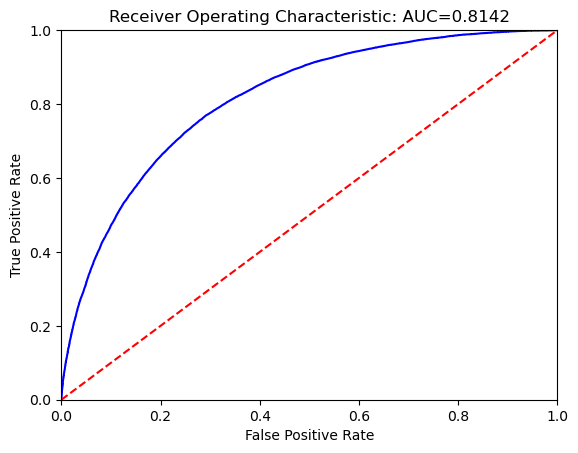

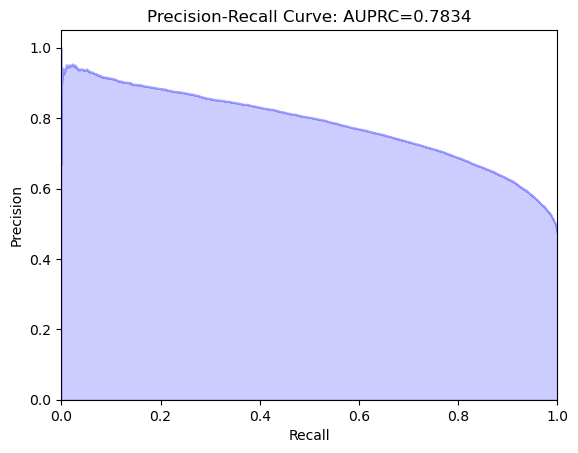

In [196]:
# Generate results for the tuned model
print("Logistic Regression:")

# Included Hyperparameters as indicated in the reference paper
start = time.time()
lr_tuned.fit(X_train_scaled,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')

probs_tuned = lr_tuned.predict_proba(X_test_scaled)
result = PlotROCCurve(probs_tuned[:,1],y_test, ci=confidence_interval)

results = ["LR_tuned_with_StandardScaling"]
results.extend(result)
results.append(runtime)
result_list.append(results)

(vi) Performance Output for tuned model

In [197]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]

# Save the results table
formatted_result_df.to_csv(os.path.join(path, 'lr_table.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR_without_scaling,0.449,0.806 (0.803-0.808),0.77 (0.765-0.775),0.739 (0.735-0.752),0.726 (0.713-0.732),5.007
1,LR_with_minmax_scaling,0.452,0.814 (0.811-0.816),0.783 (0.778-0.788),0.746 (0.744-0.759),0.729 (0.715-0.731),5.159
2,LR_with_robust_scaling,0.453,0.814 (0.811-0.816),0.783 (0.778-0.788),0.746 (0.739-0.764),0.73 (0.716-0.738),4.788
3,LR_with_standard_scaling,0.445,0.814 (0.811-0.816),0.783 (0.779-0.788),0.755 (0.73-0.762),0.722 (0.715-0.747),4.829
4,LR_tuned_with_StandardScaling,0.445,0.814 (0.811-0.816),0.783 (0.779-0.788),0.755 (0.74-0.761),0.722 (0.719-0.74),20.138


(vii) Important features

In [200]:
# Feature importance for LR model
logreg_coef = pd.DataFrame(
        {
            'features': np.array(X_train_scaled.columns),    
            'coef_values' : lr_tuned.coef_.reshape(-1)
            })

# Save table to Excel
logreg_coef.sort_values(by='coef_values',key=lambda x:abs(x),ascending=False).to_csv(os.path.join(path, 'lr_feature_impt.csv'), index=False)

# Check top 20 features
logreg_coef.sort_values(by='coef_values',key=lambda x:abs(x),ascending=False)[:20]

,features,coef_values
72,age_binned_88_93,1.250310
73,age_binned_93_98,1.169762
71,age_binned_83_88,1.053335
74,age_binned_98_inf,1.008800
70,age_binned_78_83,0.966868
69,age_binned_73_78,0.882212
119,triage_acuity,-0.795263
68,age_binned_68_73,0.788349
67,age_binned_63_68,0.763243
66,age_binned_58_63,0.695456


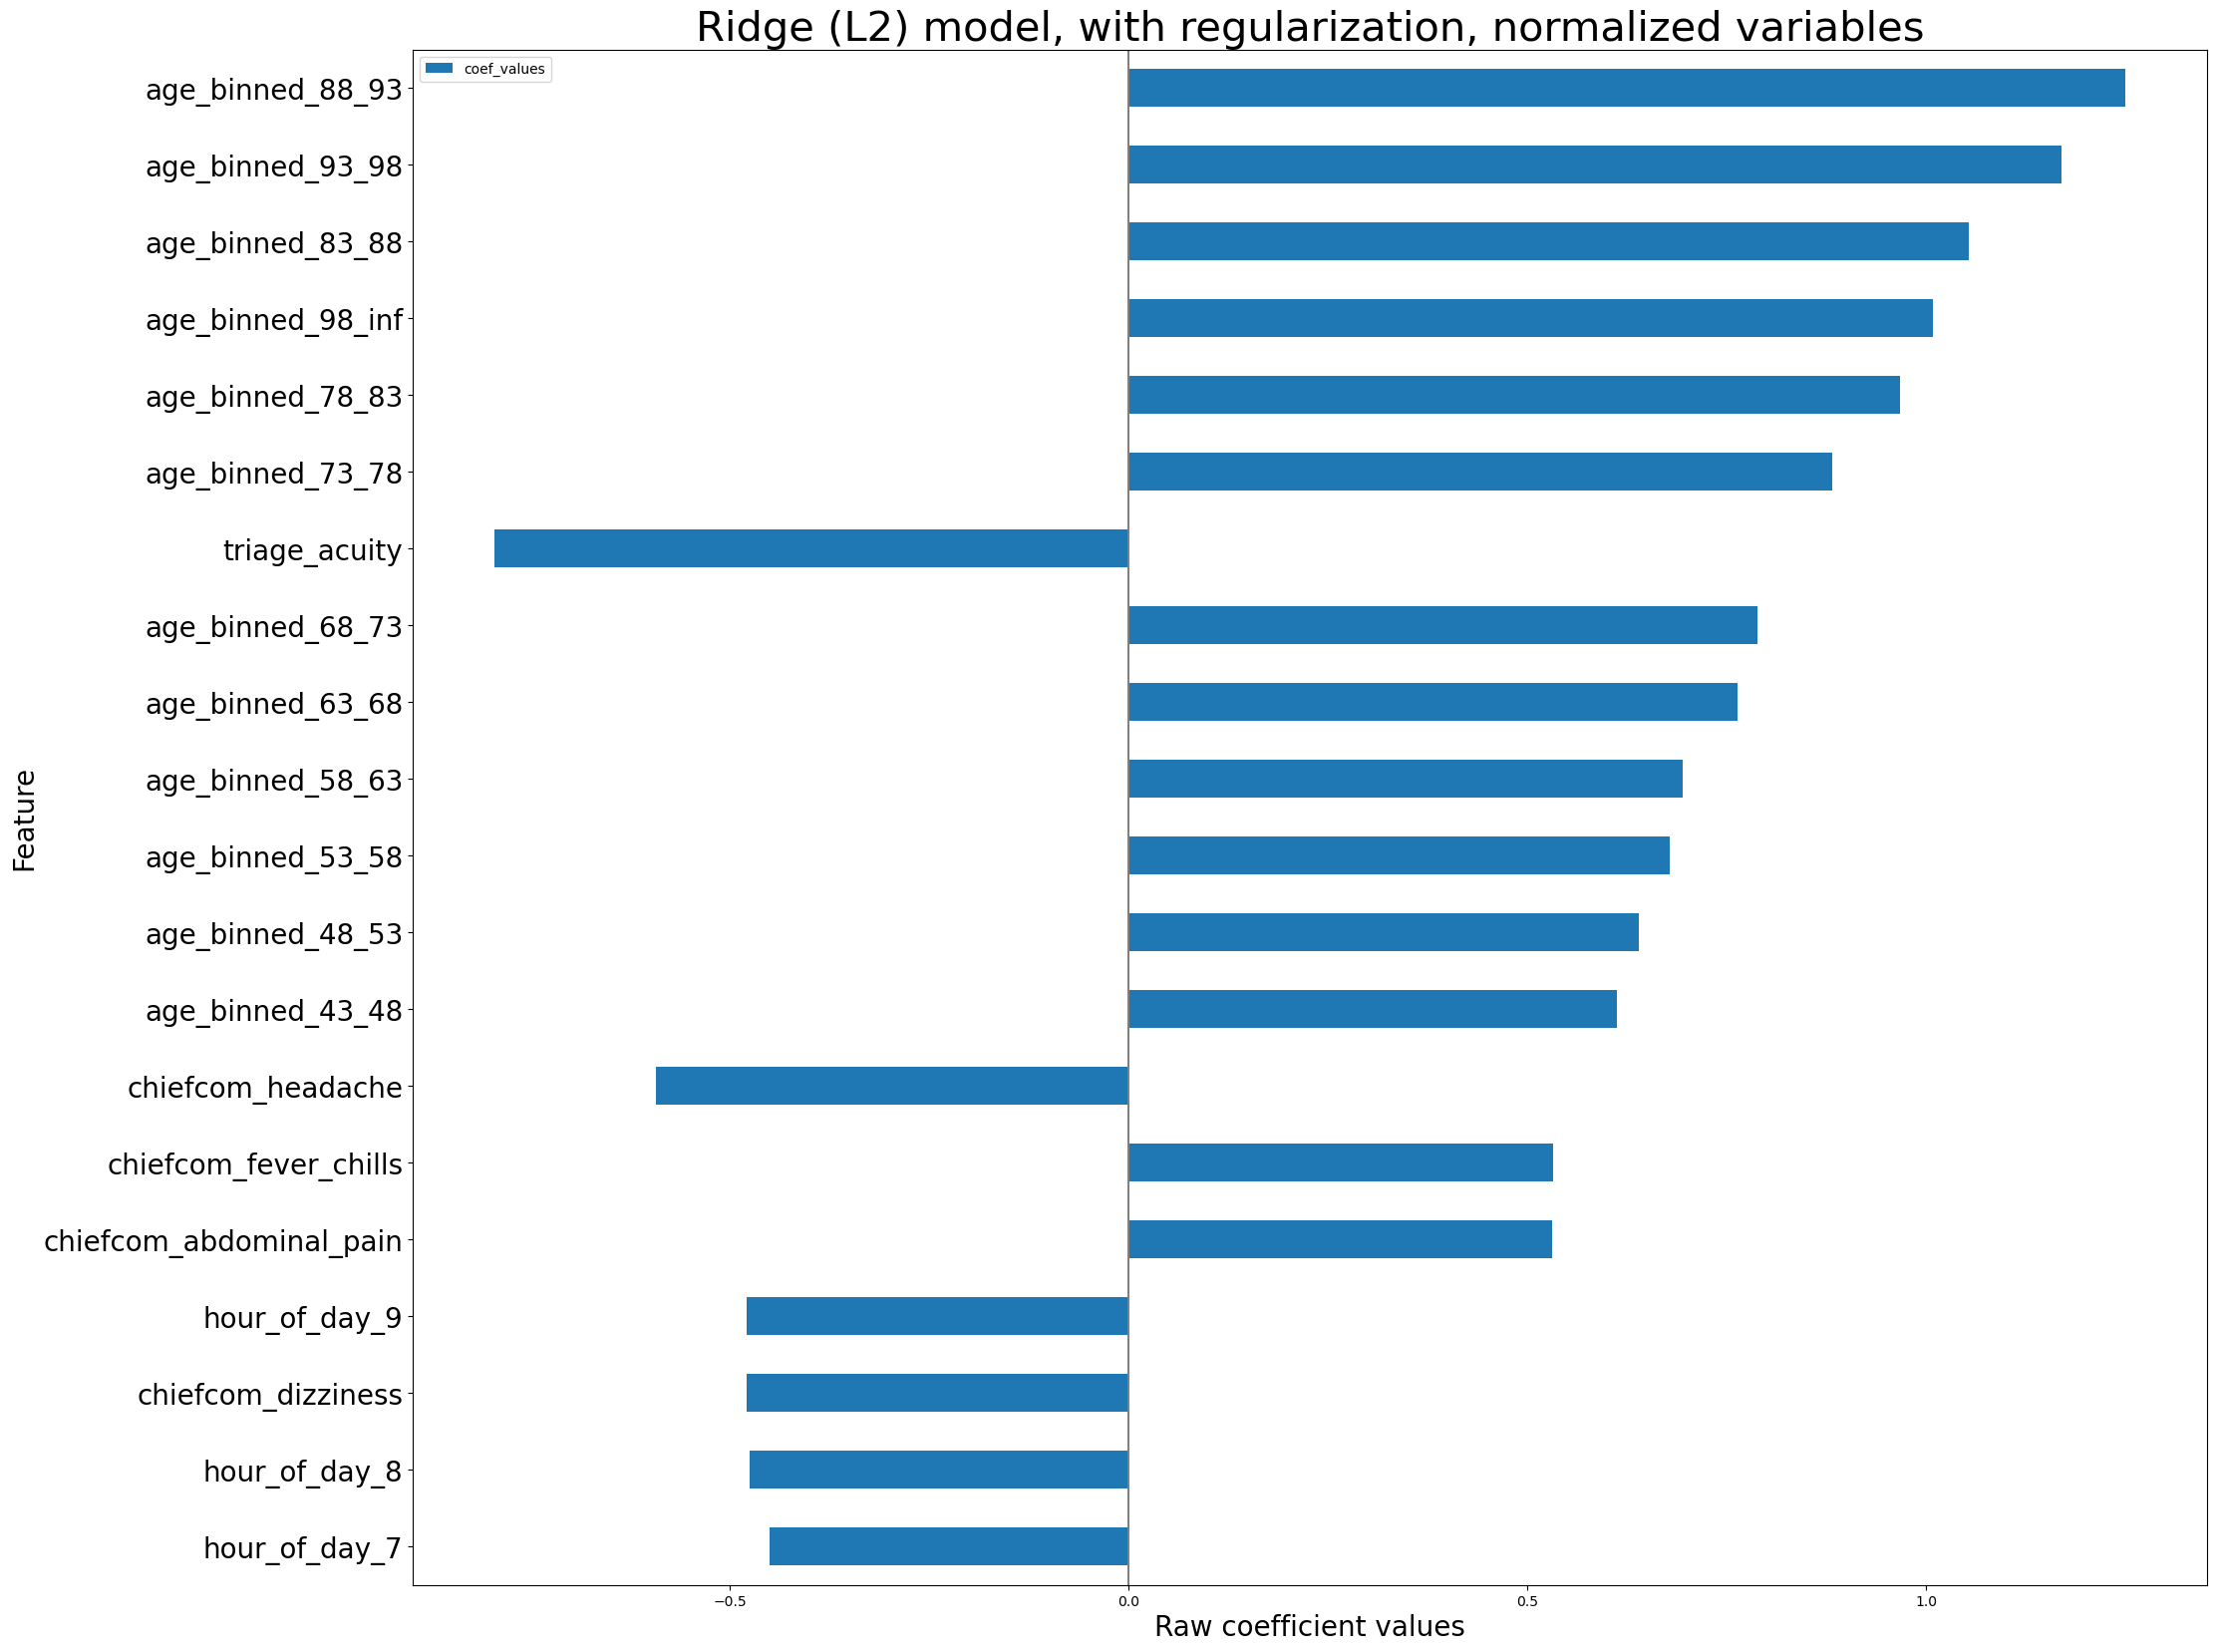

In [199]:
# Plot feature importance bar chart

sorted_coef_b = logreg_coef.sort_values(by='coef_values',key=lambda x:abs(x),ascending=False)[:20].set_index('features')

sorted_coef_b.sort_values(by='coef_values',key=lambda x:abs(x)).plot.barh(figsize=(30, 20))
plt.title("Ridge (L2) model, with regularization, normalized variables", fontsize=30)
plt.xlabel("Raw coefficient values", fontsize=20)
plt.ylabel('Feature',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

#### b. Random Forest

In [201]:
# Containers for all results
result_list_rf = []

(i) Model with no scaling of numeric features

RandomForest:
Training time: 95.1823034286499 seconds
AUC: 0.8194529754374263
AUPRC: 0.7878799719985135
Sensitivity: 0.7435473434466892
Specificity: 0.7430996501231049
Score thresold: 0.5
2.5 97.5


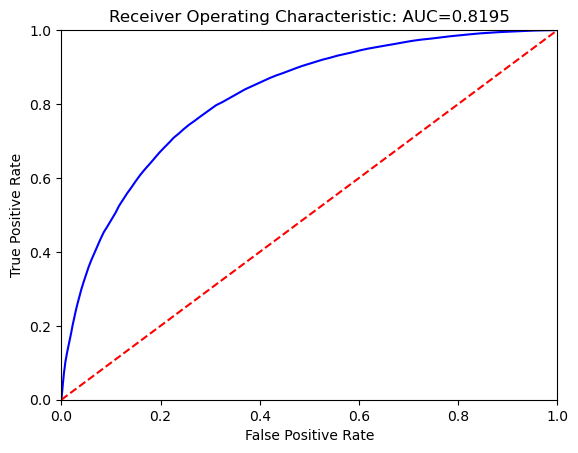

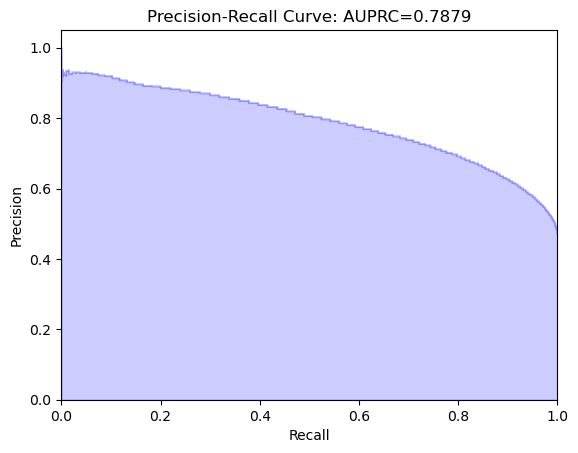

In [202]:
print("RandomForest:")

rf= RandomForestClassifier(random_state=1234)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["RF_without_scaling"]
results.extend(result)
results.append(runtime)
result_list_rf.append(results)

(ii) Model with MinMax Scaling of numeric features

RandomForest:
Training time: 97.80758714675903 seconds
AUC: 0.8196622597981038
AUPRC: 0.7880663228712386
Sensitivity: 0.7454645673065401
Specificity: 0.741263876290441
Score thresold: 0.5
2.5 97.5


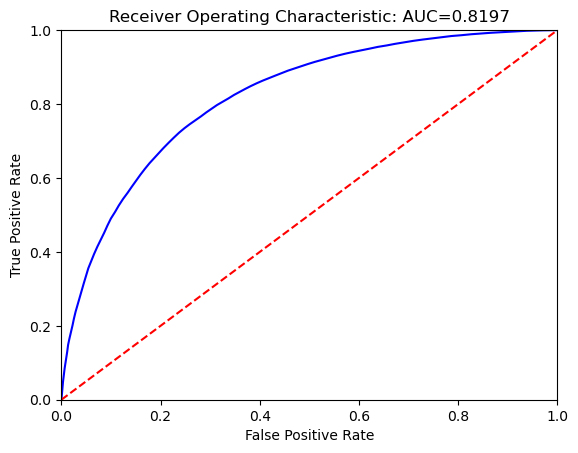

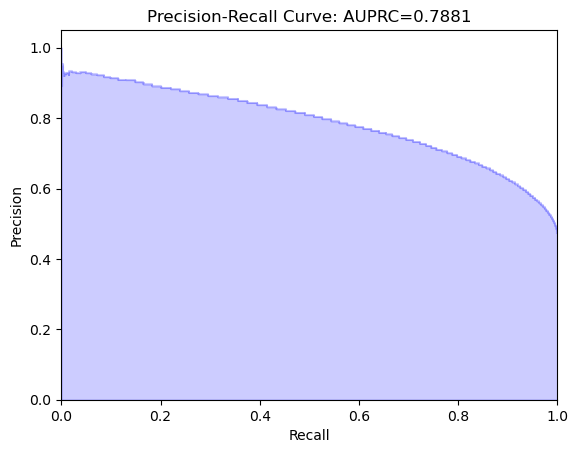

In [203]:
print("RandomForest:")

rf= RandomForestClassifier(random_state=1234)
start = time.time()
rf.fit(X_train_minmax,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test_minmax)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["RF_with_minmax_scaling"]
results.extend(result)
results.append(runtime)
result_list_rf.append(results)

(iii) Model with Robust Scaling of numeric features

RandomForest:
Training time: 96.34435844421387 seconds
AUC: 0.8196789656844352
AUPRC: 0.7881700168672202
Sensitivity: 0.745440602008292
Specificity: 0.7413502656472722
Score thresold: 0.5
2.5 97.5


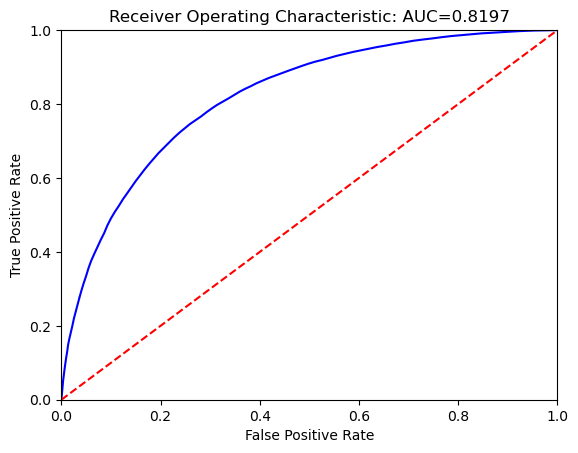

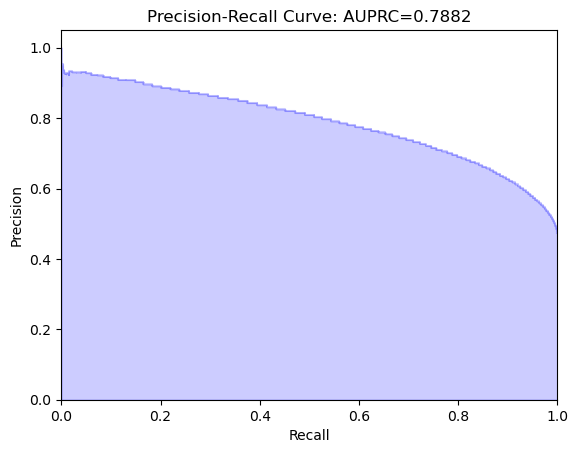

In [204]:
print("RandomForest:")

rf= RandomForestClassifier(random_state=1234)
start = time.time()
rf.fit(X_train_robust,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test_robust)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["RF_with_robust_scaling"]
results.extend(result)
results.append(runtime)
result_list_rf.append(results)

(iv) Model with Standard Scaling of numeric features

RandomForest:
Training time: 99.69395780563354 seconds
AUC: 0.8196903919278831
AUPRC: 0.7881831884067378
Sensitivity: 0.7453926714117958
Specificity: 0.7410047082199474
Score thresold: 0.5
2.5 97.5


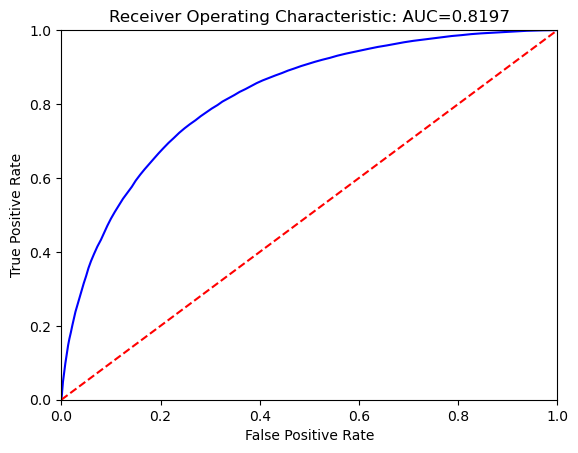

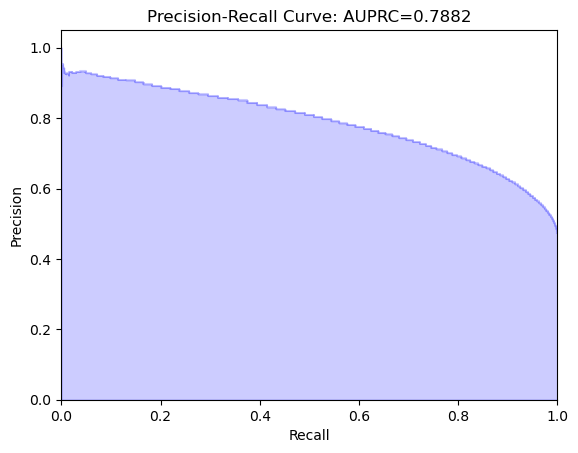

In [205]:
print("RandomForest:")

rf= RandomForestClassifier(random_state=1234)
start = time.time()
rf.fit(X_train_scaled,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test_scaled)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["RF_with_standard_scaling"]
results.extend(result)
results.append(runtime)
result_list_rf.append(results)

In [206]:
# Print hyperparameters used in the current model
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}


(v) Model Tuning

Parameters to tune:

- min_samples_split: min. # of samples required to split an internal node
- min_samples_leaf: min. # of samples required to be at a leaf node.
- criterion: The function to measure the quality of a split.['gini', 'entropy']
- max_features:  number of features to consider when looking for the best split.
- max_depth: The maximum depth of the tree.
- max_samples: If bootstrap is True, the number of samples to draw from X to train each base estimator
- n_estimators: The number of trees in the forest.

<br>References: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

<br> Dataset to use: With MinMax scaling since the sensitivity score is marginally better than the results from Robust scaling and standardisation.

In [32]:
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# Number of features to consider at every split
# An earlier round of tuning shows that setting parameters around 0.1 to 0.2 of variables was better
max_features = [0.1, 0.15,0.175, 0.2, 0.25]

# Criterion
criterion = ['gini', 'entropy']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# Max Samples
max_samples = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, None]

# Number of trees 
n_estimators = [200,400,800,1600]

- Tune min_samples_leaf and min_samples_split

In [49]:
# Create the parameters for tuning
param_grid = {'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split}

clf = RandomForestClassifier(random_state=1234)
rand_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, scoring='roc_auc', 
                                 n_iter=50, n_jobs=-1, refit=True,cv=5, verbose =3)

start = time.time()

# Fit the grid search model
rand_search.fit(X_train_minmax,y_train)

runtime = time.time()-start

print('Random Grid Search Tuning time:', runtime, 'seconds')

rand_search_results = pd.DataFrame(rand_search.cv_results_)

print('Best Score: ', rand_search.best_score_) 
print('Best Params: ', rand_search.best_params_)

# Rename mean_test_score to mean_roc_auc
rand_search_results["mean_roc_auc"] = rand_search_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rand_search_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Grid Search Tuning time: 3146.732471227646 seconds
Best Score:  0.8245860441092094
Best Params:  {'min_samples_split': 32, 'min_samples_leaf': 2}


,param_min_samples_leaf,param_min_samples_split,mean_roc_auc,rank_test_score
0,2,32,0.824586,1
1,4,16,0.824284,2
2,2,16,0.824280,3
3,2,8,0.824099,4
4,4,4,0.823985,5


In [51]:
# Since there's an improvement in mean_roc_auc as compared to our model in part (iv) 
# We replace tuned model with the hyperparameters that provide the better results
min_samples_leaf = [] 
min_samples_leaf.append(rand_search.best_params_['min_samples_leaf'])

min_samples_split = [] 
min_samples_split.append(rand_search.best_params_['min_samples_split'])

min_samples_leaf, min_samples_split

([2], [32])

- Tune max_features

In [33]:
# Continue from the previous tuned parameters
min_samples_leaf = [2]
min_samples_split = [32]

In [34]:
# Create the parameters for tuning
param_grid = {'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'max_features': max_features}

clf = RandomForestClassifier(random_state=1234)
# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
rf_grid.fit(X_train_minmax,y_train)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

rf_grid_results = pd.DataFrame(rf_grid.cv_results_)

print('Best Score: ', rf_grid.best_score_) 
print('Best Params: ', rf_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
rf_grid_results["mean_roc_auc"] = rf_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rf_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Grid Search Tuning time: 867.621915102005 seconds
Best Score:  0.8251531785795226
Best Params:  {'max_features': 0.175, 'min_samples_leaf': 2, 'min_samples_split': 32}


,param_min_samples_leaf,param_min_samples_split,param_max_features,mean_roc_auc,rank_test_score
0,2,32,0.175,0.825153,1
1,2,32,0.2,0.825047,2
2,2,32,0.15,0.825032,3
3,2,32,0.1,0.824748,4
4,2,32,0.25,0.824627,5


In [35]:
# Since there's an improvement in mean_roc_auc as compared to our model in part (iv) 
# We replace tuned model with the hyperparameters that provide the better results
max_features = [] 
max_features.append(rf_grid.best_params_['max_features'])

max_features

[0.175]

- tune criterion

In [37]:
# Create the parameters for tuning
param_grid = {'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'max_features': max_features,
              'criterion': criterion}

clf = RandomForestClassifier(random_state=1234)
# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid,
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
rf_grid.fit(X_train_minmax,y_train)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

rf_grid_results = pd.DataFrame(rf_grid.cv_results_)

print('Best Score: ', rf_grid.best_score_) 
print('Best Params: ', rf_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
rf_grid_results["mean_roc_auc"] = rf_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rf_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Grid Search Tuning time: 438.7088143825531 seconds
Best Score:  0.8258639591725814
Best Params:  {'criterion': 'entropy', 'max_features': 0.175, 'min_samples_leaf': 2, 'min_samples_split': 32}


,param_min_samples_leaf,param_min_samples_split,param_max_features,param_criterion,mean_roc_auc,rank_test_score
0,2,32,0.175,entropy,0.825864,1
1,2,32,0.175,gini,0.825153,2


In [38]:
# Since there's an improvement in mean_roc_auc as compared to our model in part (iv) 
# We replace tuned model with the hyperparameters that provide the better results
criterion = [] 
criterion.append(rf_grid.best_params_['criterion'])

criterion

['entropy']

- tune max_depth

In [39]:
# Create the parameters for tuning
param_grid = {'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'criterion': criterion,
              'max_features': max_features,
              'max_depth': max_depth}

clf = RandomForestClassifier(random_state=1234)
# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
rf_grid.fit(X_train_minmax,y_train)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

rf_grid_results = pd.DataFrame(rf_grid.cv_results_)

print('Best Score: ', rf_grid.best_score_) 
print('Best Params: ', rf_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
rf_grid_results["mean_roc_auc"] = rf_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rf_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Grid Search Tuning time: 956.3021941184998 seconds
Best Score:  0.8259223150475906
Best Params:  {'criterion': 'entropy', 'max_depth': 40, 'max_features': 0.175, 'min_samples_leaf': 2, 'min_samples_split': 32}


,param_min_samples_leaf,param_min_samples_split,param_criterion,param_max_features,param_max_depth,mean_roc_auc,rank_test_score
0,2,32,entropy,0.175,40,0.825922,1
1,2,32,entropy,0.175,60,0.825905,2
2,2,32,entropy,0.175,80,0.825864,3
3,2,32,entropy,0.175,100,0.825864,3
4,2,32,entropy,0.175,None,0.825864,3


In [40]:
# Since there's an improvement in mean_roc_auc as compared to our model in part (iv)
# We replace tuned model with the hyperparameters that provide the better results
max_depth = [] 
max_depth.append(rf_grid.best_params_['max_depth'])

max_depth

[40]

- Tune max_samples

In [41]:
# Create the parameters for tuning
param_grid = {'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'criterion': criterion,
              'max_features': max_features,
              'max_depth': max_depth,
              'max_samples': max_samples,
              }

clf = RandomForestClassifier(random_state=1234)
# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
rf_grid.fit(X_train_minmax,y_train)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

rf_grid_results = pd.DataFrame(rf_grid.cv_results_)

print('Best Score: ', rf_grid.best_score_) 
print('Best Params: ', rf_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
rf_grid_results["mean_roc_auc"] = rf_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rf_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Grid Search Tuning time: 1167.7923622131348 seconds
Best Score:  0.8261584704413802
Best Params:  {'criterion': 'entropy', 'max_depth': 40, 'max_features': 0.175, 'max_samples': 0.9, 'min_samples_leaf': 2, 'min_samples_split': 32}


,param_min_samples_leaf,param_min_samples_split,param_criterion,param_max_features,param_max_depth,param_max_samples,mean_roc_auc,rank_test_score
0,2,32,entropy,0.175,40,0.9,0.826158,1
1,2,32,entropy,0.175,40,0.7,0.825950,2
2,2,32,entropy,0.175,40,1.0,0.825922,3
3,2,32,entropy,0.175,40,None,0.825922,3
4,2,32,entropy,0.175,40,0.8,0.825756,5


In [42]:
# Since there's an improvement in mean_roc_auc as compared to our model,
# We replace tuned model with the hyperparameters that provide the better results
max_samples = [] 
max_samples.append(rf_grid.best_params_['max_samples'])

max_samples

[0.9]

- Tune n_esimators

In [44]:
# Create the parameters for tuning
param_grid = {'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'criterion': criterion,
              'max_features': max_features,
              'max_depth': max_depth,
              'max_samples': max_samples,
              'n_estimators': n_estimators}

print(param_grid)

clf = RandomForestClassifier(random_state=1234)
# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
rf_grid.fit(X_train_minmax,y_train)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

rf_grid_results = pd.DataFrame(rf_grid.cv_results_)

print('Best Score: ', rf_grid.best_score_) 
print('Best Params: ', rf_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
rf_grid_results["mean_roc_auc"] = rf_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rf_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head()

{'min_samples_leaf': [2], 'min_samples_split': [32], 'criterion': ['entropy'], 'max_features': [0.175], 'max_depth': [40], 'max_samples': [0.9], 'n_estimators': [200, 400, 800, 1600]}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid Search Tuning time: 30068.45506119728 seconds
Best Score:  0.8273267703403988
Best Params:  {'criterion': 'entropy', 'max_depth': 40, 'max_features': 0.175, 'max_samples': 0.9, 'min_samples_leaf': 2, 'min_samples_split': 32, 'n_estimators': 1600}


,param_min_samples_leaf,param_min_samples_split,param_criterion,param_max_features,param_max_depth,param_max_samples,param_n_estimators,mean_roc_auc,rank_test_score
0,2,32,entropy,0.175,40,0.9,1600,0.827327,1
1,2,32,entropy,0.175,40,0.9,800,0.827287,2
2,2,32,entropy,0.175,40,0.9,400,0.827124,3
3,2,32,entropy,0.175,40,0.9,200,0.826807,4


In [45]:
# Since there's an improvement in mean_roc_auc as compared to our model in part (iv) 
# We replace tuned model with the hyperparameters that provide the better results
n_estimators = [] 
n_estimators.append(rf_grid.best_params_['n_estimators'])

n_estimators

[1600]

In [46]:
#Best Parameters
rf_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 40,
 'max_features': 0.175,
 'max_samples': 0.9,
 'min_samples_leaf': 2,
 'min_samples_split': 32,
 'n_estimators': 1600}

In [47]:
# assign the best estimator to to log_reg_tuned
rf_tuned = rf_grid.best_estimator_
rf_tuned

RandomForestClassifier(criterion='entropy', max_depth=40, max_features=0.175,
                       max_samples=0.9, min_samples_leaf=2,
                       min_samples_split=32, n_estimators=1600,
                       random_state=1234)

In [ ]:
# Assign the model with best params to rf_tuned
# rf_tuned = RandomForestClassifier(random_state=1234, C= 0.1, max_iter= 100, penalty= 'l2', solver= 'newton-cg' )

In [207]:
# Save the tuned model
# pickle.dump(rf_tuned, open('rf_tuned.pkl', 'wb'))

# load the tuned model
rf_tuned = pickle.load(open('rf_tuned.pkl', 'rb'))

RandomForest:
AUC: 0.8250656066731712
AUPRC: 0.7989090587035491
Sensitivity: 0.7580223835885638
Specificity: 0.7361885015766058
Score thresold: 0.4893249725390449
2.5 97.5


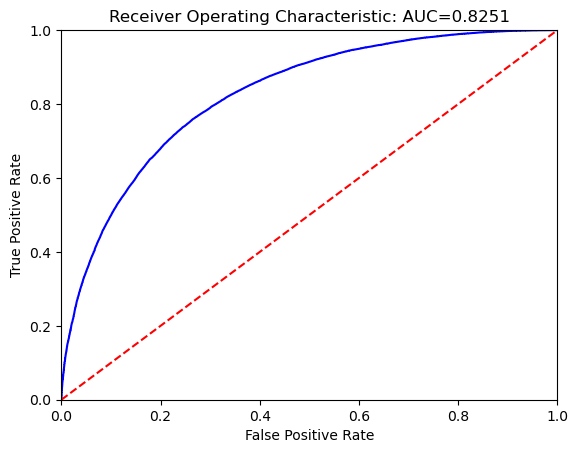

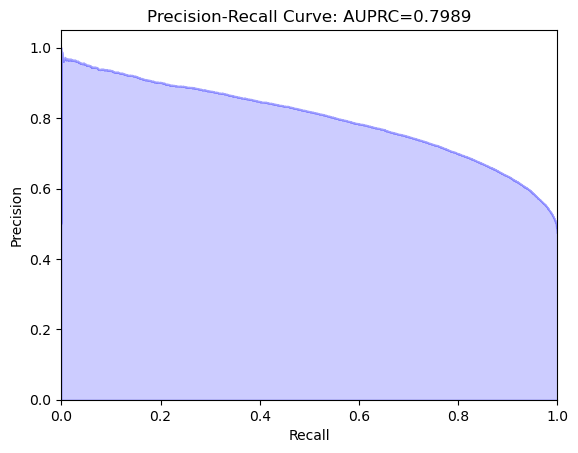

In [208]:
print("RandomForest:")

# rf= RandomForestClassifier(random_state=1234)
# start = time.time()
# rf.fit(X_train_minmax,y_train)
# runtime = time.time()-start
# print('Training time:', runtime, 'seconds')
probs = rf_tuned.predict_proba(X_test_minmax)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["RF_tuned_with_MinMax"]
results.extend(result)
results.append(runtime)
result_list_rf.append(results)

(vi) Performance Output for tuned model

In [209]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list_rf, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
# Save table to Excel
formatted_result_df.to_csv(os.path.join(path, 'rf_table.csv'), index=False)

# Print the table
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,RF_without_scaling,0.500,0.819 (0.817-0.821),0.788 (0.783-0.792),0.744 (0.74-0.748),0.743 (0.739-0.747),95.182
1,RF_with_minmax_scaling,0.500,0.82 (0.817-0.821),0.788 (0.784-0.793),0.745 (0.734-0.748),0.741 (0.738-0.751),97.808
2,RF_with_robust_scaling,0.500,0.82 (0.817-0.821),0.788 (0.784-0.793),0.745 (0.738-0.751),0.741 (0.736-0.748),96.344
3,RF_with_standard_scaling,0.500,0.82 (0.817-0.821),0.788 (0.784-0.793),0.745 (0.733-0.753),0.741 (0.733-0.753),99.694
4,RF_tuned_with_MinMax,0.489,0.825 (0.822-0.827),0.799 (0.795-0.803),0.758 (0.738-0.764),0.736 (0.732-0.754),99.694


(vii) Important features

In [99]:
# Feature importance for LR model
rf_feature_importance = pd.DataFrame(
        {
            'features': np.array(X_train_minmax.columns),    
            'importance' : rf_tuned.feature_importances_
            })

# Save table to Excel
rf_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False).to_csv(os.path.join(path, 'rf_feature_impt.csv'), index=False)


# Check top 20 features
rf_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20]

,features,importance
119,triage_acuity,0.180367
121,score_CCI,0.073687
126,n_medrecon,0.050672
120,triage_MAP,0.050437
117,triage_sbp,0.044271
113,triage_temperature,0.042979
114,triage_heartrate,0.042525
122,score_CART,0.039332
123,score_REMS,0.033600
118,triage_pain,0.029408


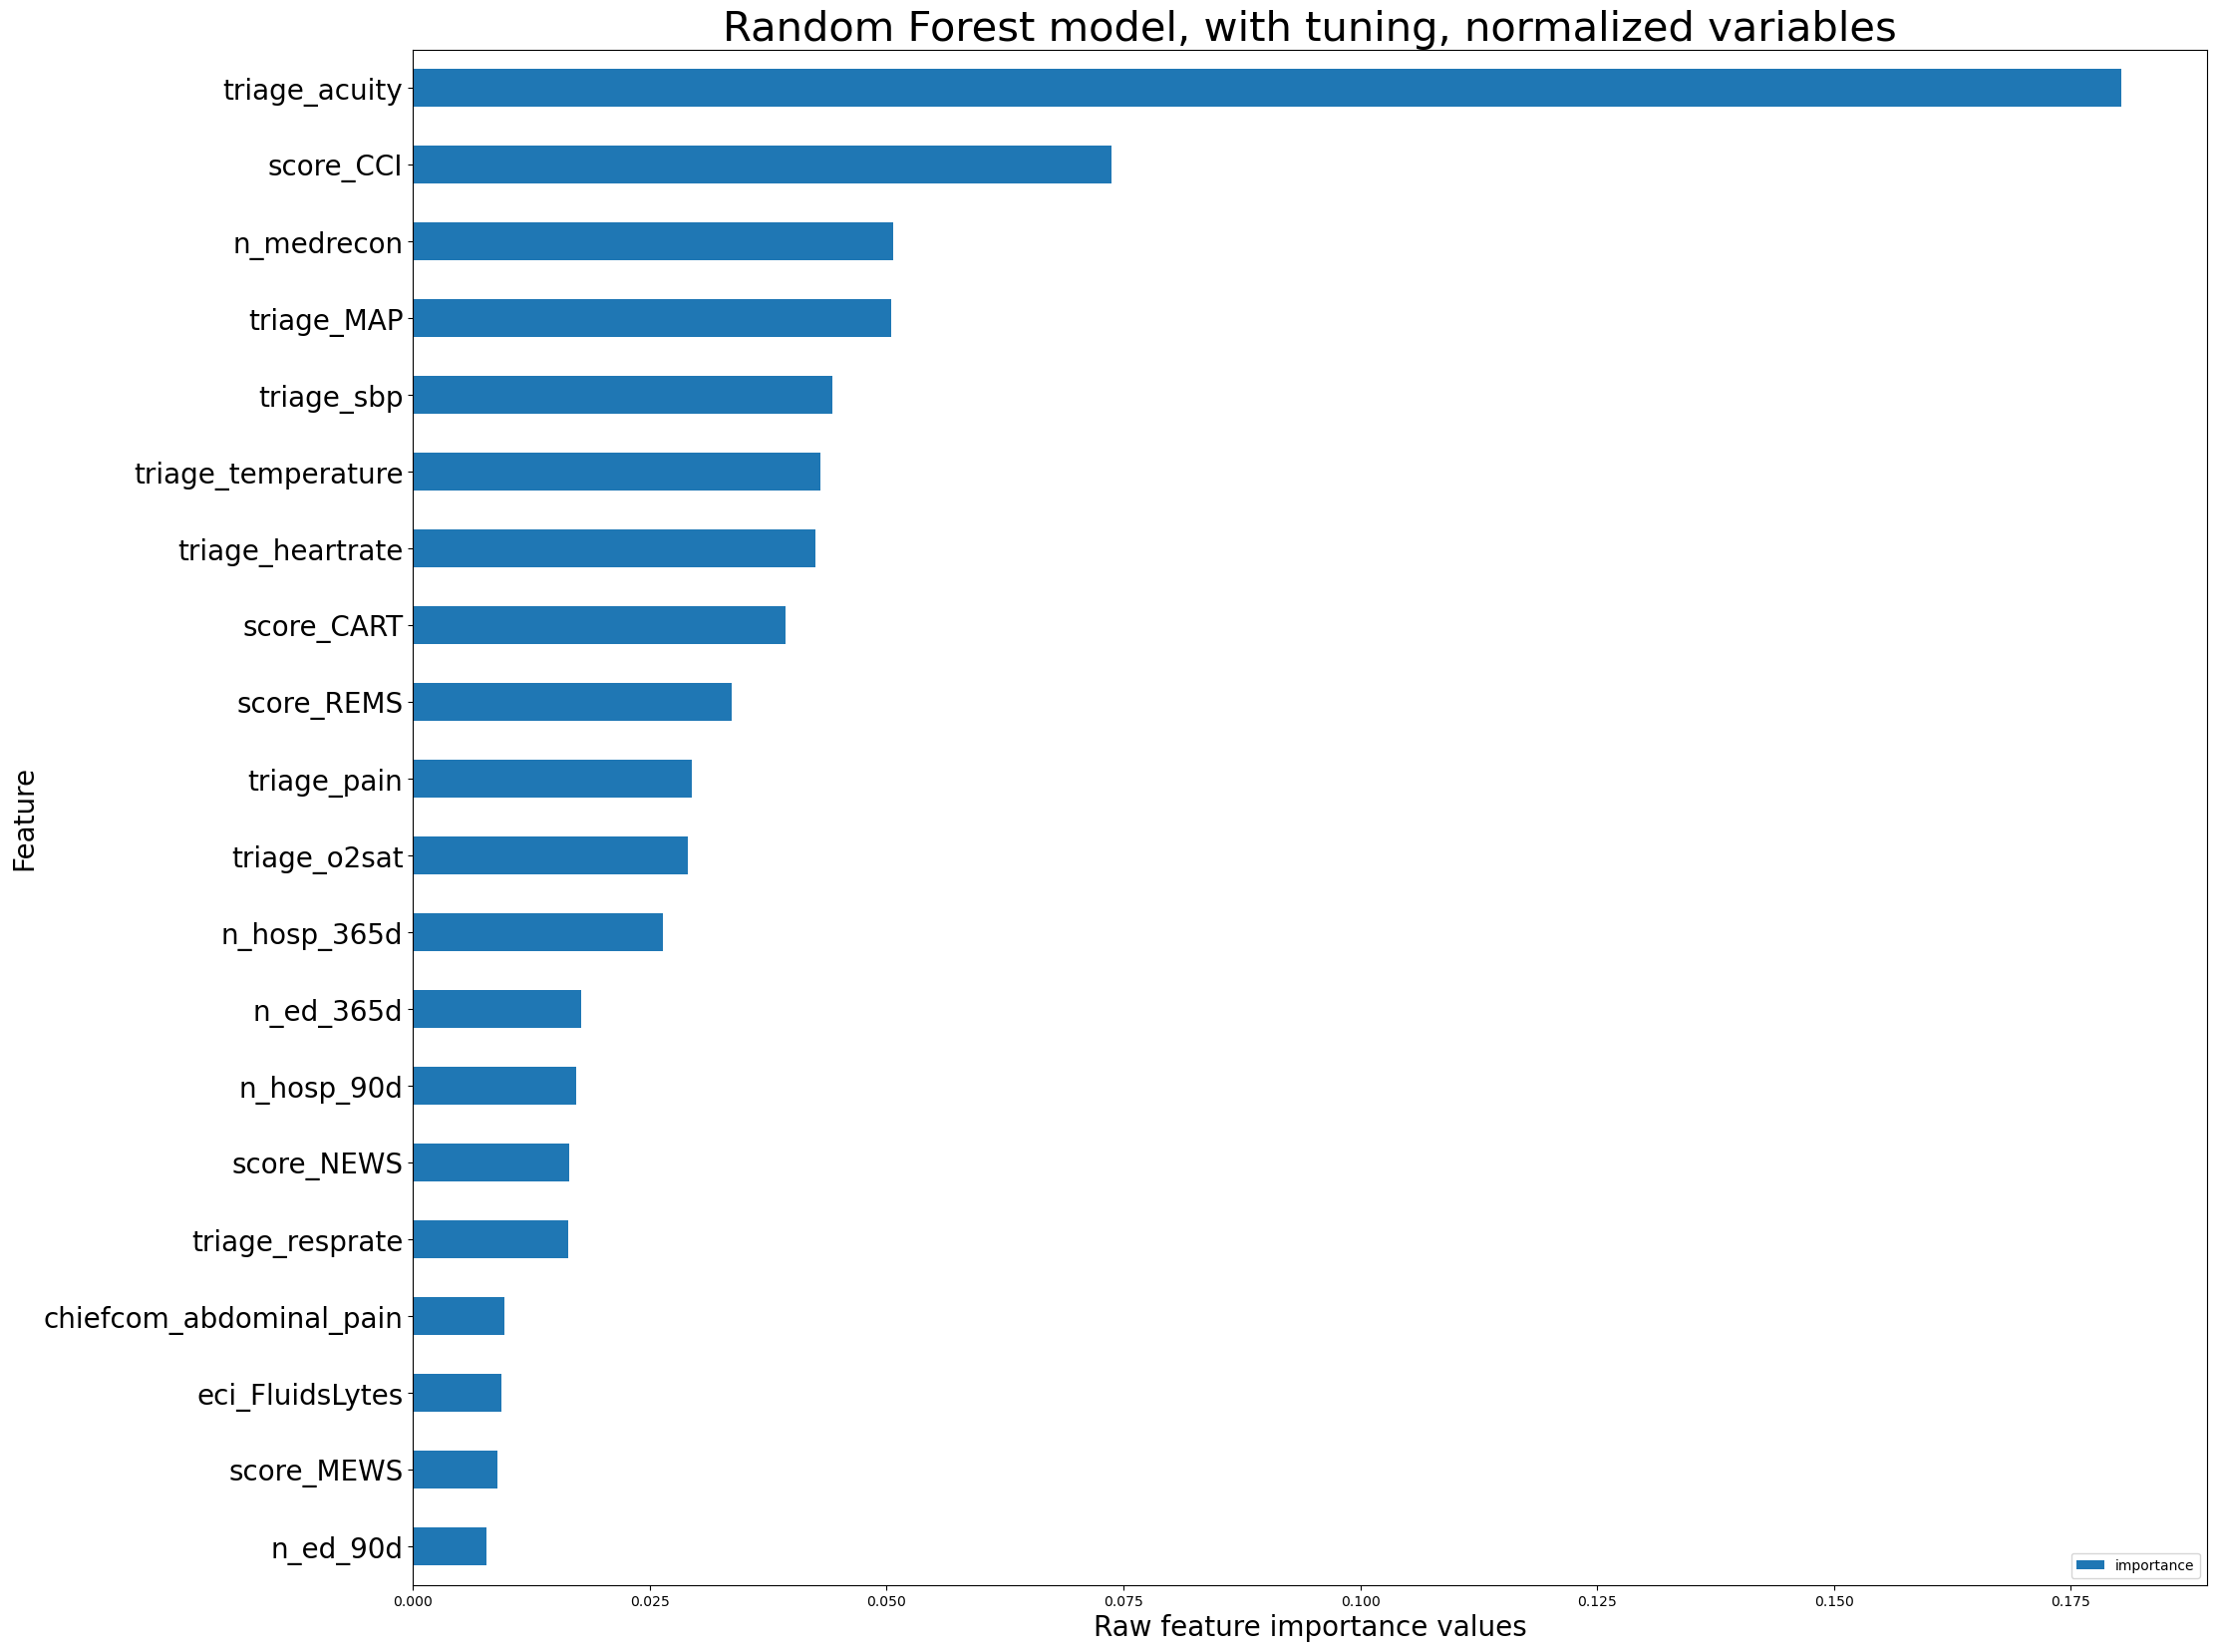

In [98]:
sorted_feature_importance = rf_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20].set_index('features')

sorted_feature_importance.sort_values(by='importance',key=lambda x:abs(x)).plot.barh(figsize=(30, 20))
plt.title("Random Forest model, with tuning, normalized variables", fontsize=30)
plt.xlabel("Raw feature importance values", fontsize=20)
plt.ylabel('Feature',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

#### c. Gradient Boosting

In [32]:
# Containers for all results
result_list_gb = []

(i) Model with no scaling of numeric features

GradientBoosting:
Training time: 111.90510058403015 seconds
AUC: 0.8178318072740507
AUPRC: 0.790714770036533
Sensitivity: 0.7374841229899106
Specificity: 0.7414366550041035
Score thresold: 0.4972404564864646
2.5 97.5


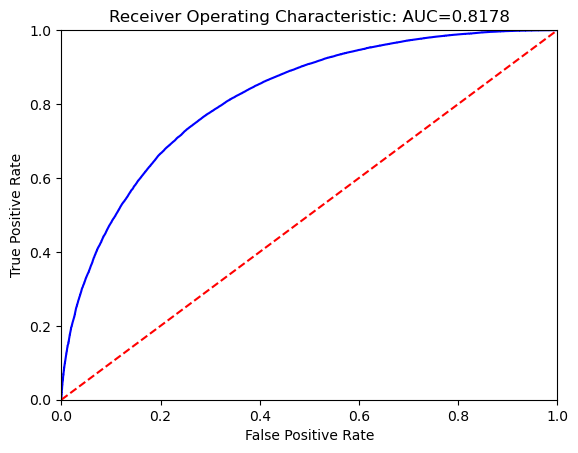

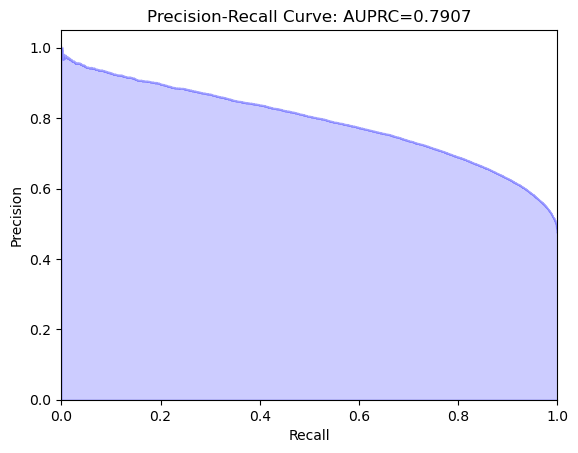

In [33]:
print("GradientBoosting:")

gb = GradientBoostingClassifier(random_state=1234)
start = time.time()
gb.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB_without_scaling"]
results.extend(result)
results.append(runtime)
result_list_gb.append(results)

(ii) Model with MinMax Scaling of numeric features

GradientBoosting:
Training time: 108.11860704421997 seconds
AUC: 0.8178318072740507
AUPRC: 0.790714770036533
Sensitivity: 0.7374841229899106
Specificity: 0.7414366550041035
Score thresold: 0.4972404564864646
2.5 97.5


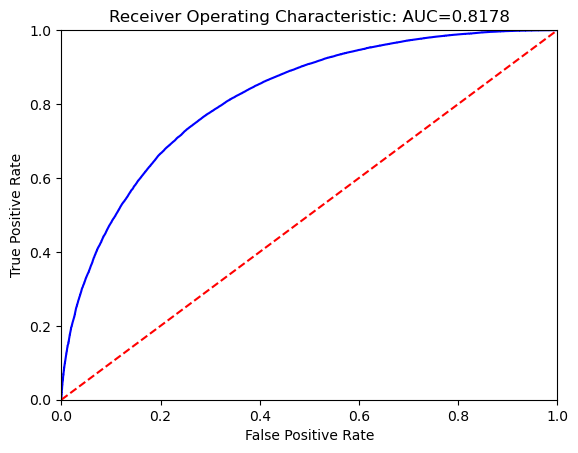

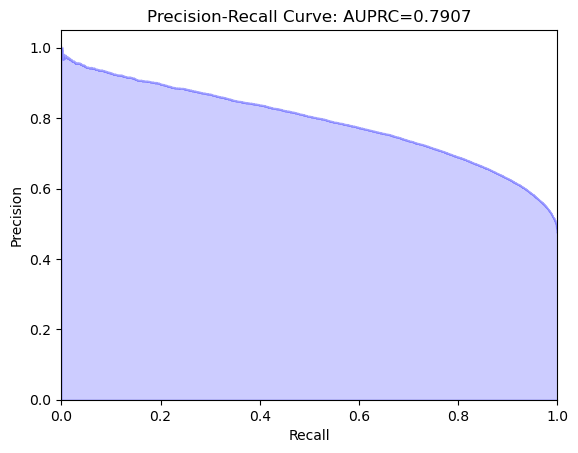

In [34]:
print("GradientBoosting:")

gb = GradientBoostingClassifier(random_state=1234)
start = time.time()
gb.fit(X_train_minmax,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test_minmax)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB_with_minmax_scaling"]
results.extend(result)
results.append(runtime)
result_list_gb.append(results)

(iii) Model with Robust Scaling of numeric features

GradientBoosting:
Training time: 117.34148216247559 seconds
AUC: 0.8178318072740507
AUPRC: 0.790714770036533
Sensitivity: 0.7374841229899106
Specificity: 0.7414366550041035
Score thresold: 0.4972404564864646
2.5 97.5


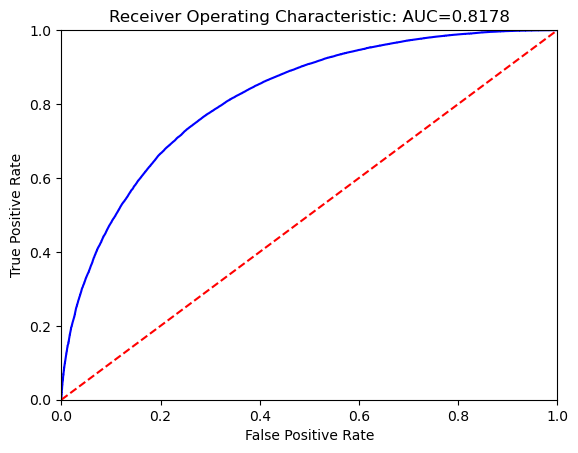

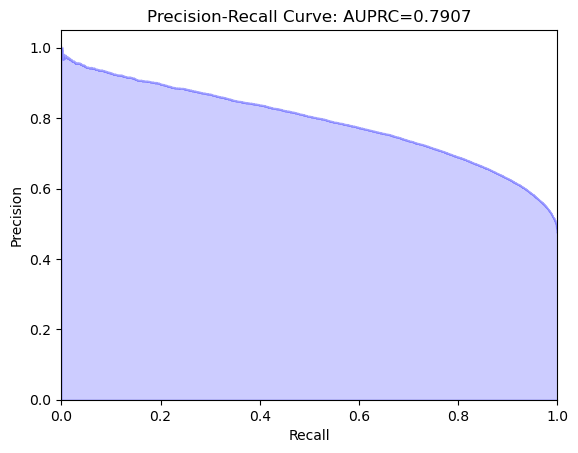

In [35]:
print("GradientBoosting:")

gb = GradientBoostingClassifier(random_state=1234)
start = time.time()
gb.fit(X_train_robust,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test_robust)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB_with_robust_scaling"]
results.extend(result)
results.append(runtime)
result_list_gb.append(results)

(iv) Model with Standard Scaling of numeric features

GradientBoosting:
Training time: 110.72417211532593 seconds
AUC: 0.8178318072740507
AUPRC: 0.790714770036533
Sensitivity: 0.7374841229899106
Specificity: 0.7414366550041035
Score thresold: 0.4972404564864646
2.5 97.5


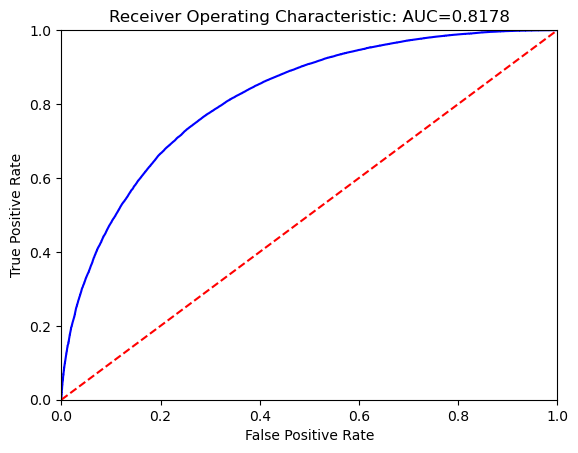

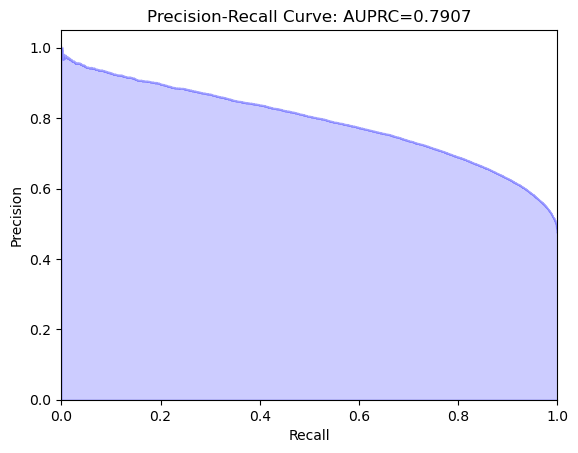

In [36]:
print("GradientBoosting:")

gb = GradientBoostingClassifier(random_state=1234)
start = time.time()
gb.fit(X_train_scaled,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test_scaled)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB_with_standard_scaling"]
results.extend(result)
results.append(runtime)
result_list_gb.append(results)

In [37]:
# Print hyperparameters used in the current model
print('Parameters currently in use:\n')
pprint(gb.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 1234,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


(v) Model Tuning

Hyper-parameters to tune:

- learning_rate: shrinks the contribution of each tree by learning_rate
- max_depth: indicates how deep the built tree can be.
- min_samples_split: represents the minimum number of samples required to split an internal node
- min_samples_leaf: the minimum number of samples required to be at a leaf node. 
- max_features: the number of features to consider when looking for the best split.
- n_estimators: the number of trees in the forest

<br>References: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

<br>Other References:
- https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
- https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/

<br> Dataset used: The dataset with Minmax Scaling since there's no difference between this and the results of models with Robust or Standard scaling

In [211]:
# Assign range of values for the hyperparameters

# learning rate shrinks the contribution of each tree by learning_rate. 
# There is a trade-off between learning_rate and n_estimators.
learning_rate = [1, 0.75, 0.5, 0.25, 0.1, 0.05]

# n_estimators represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. 
# However, adding a lot of trees can slow down the training process considerably
n_estimators = [50,200,400,800]

#max_depth indicates how deep the built tree can be. 
#The deeper the tree, the more splits it has and it captures more information about how the data.
max_depth =  [int(x) for x in np.linspace(1, 10, 10, endpoint=True)]

# min_samples_split represents the minimum number of samples required to split an internal node
# Here we will vary the parameter from 10% to 100% of the samples
min_samples_split = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

#min_samples_leaf is the minimum number of samples required to be at a leaf node. 
#This similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs.
min_samples_leaf = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# max_features represents the number of features to consider when looking for the best split.
max_features = [5,10,15,20,25,50,100,None]


- Tune learning rate

In [214]:
# Create the parameters for tuning
param_grid = {'learning_rate': learning_rate}

clf = GradientBoostingClassifier(random_state=1234)
# Instantiate the grid search model
gb_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)
start = time.time()

# Fit the grid search model
gb_grid.fit(X_train_minmax,y_train)

runtime = time.time()-start

print('Random Grid Search Tuning time:', runtime, 'seconds')

gb_grid_results = pd.DataFrame(gb_grid.cv_results_)

print('Best Score: ', gb_grid.best_score_) 
print('Best Params: ', gb_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
gb_grid_results["mean_roc_auc"] = gb_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
gb_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head(10)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Random Grid Search Tuning time: 1047.1354613304138 seconds
Best Score:  0.8269713939700122
Best Params:  {'learning_rate': 0.5}


,param_learning_rate,mean_roc_auc,rank_test_score
0,0.5,0.826971,1
1,0.75,0.826355,2
2,0.25,0.825919,3
3,1,0.825032,4
4,0.1,0.820515,5
5,0.05,0.814044,6


In [216]:
# Replace tuned parameter(s) with best value
learning_rate = [] 
learning_rate.append(gb_grid.best_params_['learning_rate'])

learning_rate

[0.5]

- Tune max_depth

In [220]:
max_depth =  [int(x) for x in np.linspace(1, 10, 10, endpoint=True)]
max_depth

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [221]:
# Create the parameters for tuning
param_grid = {'learning_rate': learning_rate,
              'max_depth': max_depth}

print(param_grid)

clf = GradientBoostingClassifier(random_state=1234)
# Instantiate the grid search model
gb_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
gb_grid.fit(X_train_minmax,y_train)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

gb_grid_results = pd.DataFrame(gb_grid.cv_results_)

print('Best Score: ', gb_grid.best_score_) 
print('Best Params: ', gb_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
gb_grid_results["mean_roc_auc"] = gb_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
gb_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head(10)

{'learning_rate': [0.5], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Grid Search Tuning time: 3054.3400132656097 seconds
Best Score:  0.8274290703265118
Best Params:  {'learning_rate': 0.5, 'max_depth': 4}


,param_learning_rate,param_max_depth,mean_roc_auc,rank_test_score
0,0.5,4,0.827429,1
1,0.5,3,0.826971,2
2,0.5,5,0.826271,3
3,0.5,2,0.824095,4
4,0.5,6,0.823112,5
5,0.5,7,0.818193,6
6,0.5,1,0.816132,7
7,0.5,8,0.812864,8
8,0.5,9,0.805133,9
9,0.5,10,0.797042,10


In [223]:
# Replace tuned parameter(s) with best value
max_depth = [] 
max_depth.append(gb_grid.best_params_['max_depth'])

max_depth

[4]

- Tune min_samples_split and min_samples_leaf using Random Grid Search

In [225]:
# Create the parameters for tuning
param_grid = {'learning_rate': learning_rate,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

print(param_grid)

clf = GradientBoostingClassifier(random_state=1234)
rand_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, scoring='roc_auc', n_iter=50, n_jobs=-1, refit=True,cv=5, verbose =3)

start = time.time()

# Fit the grid search model
rand_search.fit(X_train_minmax,y_train)

runtime = time.time()-start

print('Random Grid Search Tuning time:', runtime, 'seconds')

rand_search_results = pd.DataFrame(rand_search.cv_results_)

print('Best Score: ', rand_search.best_score_) 
print('Best Params: ', rand_search.best_params_)

# Rename mean_test_score to mean_roc_auc
rand_search_results["mean_roc_auc"] = rand_search_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
rand_search_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head(10)

{'learning_rate': [0.5], 'max_depth': [4], 'min_samples_split': [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024], 'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Grid Search Tuning time: 10242.812541246414 seconds
Best Score:  0.8286265531373577
Best Params:  {'min_samples_split': 64, 'min_samples_leaf': 1024, 'max_depth': 4, 'learning_rate': 0.5}


,param_learning_rate,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_roc_auc,rank_test_score
0,0.5,4,64,1024,0.828627,1
1,0.5,4,4,1024,0.828627,1
2,0.5,4,2,1024,0.828627,1
3,0.5,4,8,512,0.828551,4
4,0.5,4,4,512,0.828551,4
5,0.5,4,64,512,0.828551,4
6,0.5,4,512,64,0.828275,7
7,0.5,4,4,128,0.828265,8
8,0.5,4,128,128,0.828265,8
9,0.5,4,32,128,0.828265,8


In [226]:
# Replace tuned parameter(s) with best value
min_samples_split = [] 
min_samples_split.append(rand_search.best_params_['min_samples_split'])

min_samples_leaf = [] 
min_samples_leaf.append(rand_search.best_params_['min_samples_leaf'])

min_samples_split, min_samples_leaf

([64], [1024])

- Tune max features

In [227]:
# Create the parameters for tuning
param_grid = {'learning_rate': learning_rate,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features}

print(param_grid)

clf = GradientBoostingClassifier(random_state=1234)
# Instantiate the grid search model
gb_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
gb_grid.fit(X_train_minmax,y_train)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

gb_grid_results = pd.DataFrame(gb_grid.cv_results_)

print('Best Score: ', gb_grid.best_score_) 
print('Best Params: ', gb_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
gb_grid_results["mean_roc_auc"] = gb_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
gb_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head(10)

{'learning_rate': [0.5], 'max_depth': [4], 'min_samples_split': [64], 'min_samples_leaf': [1024], 'max_features': [5, 10, 15, 20, 25, 50, 100, None]}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid Search Tuning time: 757.0275657176971 seconds
Best Score:  0.8286265531373577
Best Params:  {'learning_rate': 0.5, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1024, 'min_samples_split': 64}


,param_learning_rate,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_roc_auc,rank_test_score
0,0.5,4,64,1024,None,0.828627,1
1,0.5,4,64,1024,100,0.828112,2
2,0.5,4,64,1024,50,0.827188,3
3,0.5,4,64,1024,25,0.826791,4
4,0.5,4,64,1024,20,0.825775,5
5,0.5,4,64,1024,15,0.825620,6
6,0.5,4,64,1024,10,0.824832,7
7,0.5,4,64,1024,5,0.823267,8


In [228]:
# Replace tuned parameter(s) with best value
max_features = [] 
max_features.append(gb_grid.best_params_['max_features'])

max_features

[None]

- tune n_estimators

In [229]:
n_estimators = [50,200,400,800]

In [230]:
# Create the parameters for tuning
param_grid = {'learning_rate': learning_rate,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'n_estimators': n_estimators}

print(param_grid)

clf = GradientBoostingClassifier(random_state=1234)
# Instantiate the grid search model
gb_grid = GridSearchCV(estimator = clf, param_grid = param_grid, 
                       scoring = 'roc_auc', cv = 5, refit = True,
                       n_jobs = -1, verbose = 3)

start = time.time()

# Fit the grid search model
gb_grid.fit(X_train_minmax,y_train)

runtime = time.time()-start

print('Grid Search Tuning time:', runtime, 'seconds')

gb_grid_results = pd.DataFrame(gb_grid.cv_results_)

print('Best Score: ', gb_grid.best_score_) 
print('Best Params: ', gb_grid.best_params_)

# Rename mean_test_score to mean_roc_auc
gb_grid_results["mean_roc_auc"] = gb_grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
gb_grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head(10)

{'learning_rate': [0.5], 'max_depth': [4], 'min_samples_split': [64], 'min_samples_leaf': [1024], 'max_features': [None], 'n_estimators': [50, 200, 400, 800]}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid Search Tuning time: 3351.3228211402893 seconds
Best Score:  0.8291559320290414
Best Params:  {'learning_rate': 0.5, 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1024, 'min_samples_split': 64, 'n_estimators': 200}


,param_learning_rate,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_n_estimators,mean_roc_auc,rank_test_score
0,0.5,4,64,1024,None,200,0.829156,1
1,0.5,4,64,1024,None,400,0.828757,2
2,0.5,4,64,1024,None,800,0.827161,3
3,0.5,4,64,1024,None,50,0.826799,4


In [231]:
# Replace tuned parameter(s) with best value
n_estimators = [] 
n_estimators.append(gb_grid.best_params_['n_estimators'])

n_estimators

[200]

In [232]:
# Best Parameters
gb_grid.best_params_

{'learning_rate': 0.5,
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 1024,
 'min_samples_split': 64,
 'n_estimators': 200}

In [233]:
# Assign the best estimator to to log_reg_tuned
gb_tuned = gb_grid.best_estimator_
gb_tuned

GradientBoostingClassifier(learning_rate=0.5, max_depth=4,
                           min_samples_leaf=1024, min_samples_split=64,
                           n_estimators=200, random_state=1234)

In [38]:
# Save the tuned model
# pickle.dump(gb_tuned, open('gb_tuned.pkl', 'wb'))

# load the tuned model
gb_tuned = pickle.load(open('gb_tuned.pkl', 'rb'))

GradientBoosting:
Training time: 287.40363597869873 seconds
AUC: 0.8271244978880016
AUPRC: 0.801795077445185
Sensitivity: 0.7512402041843411
Specificity: 0.7445682691892359
Score thresold: 0.4836434105237071
2.5 97.5


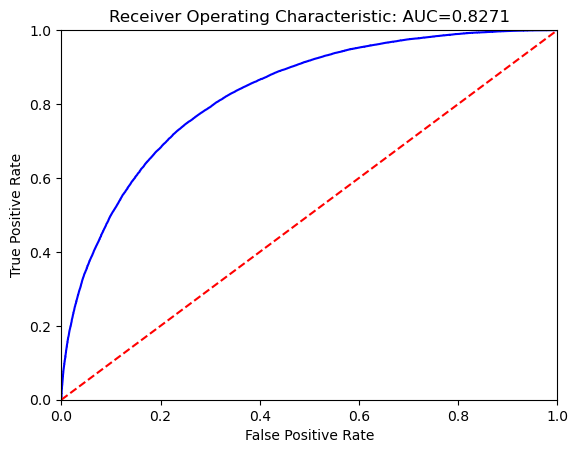

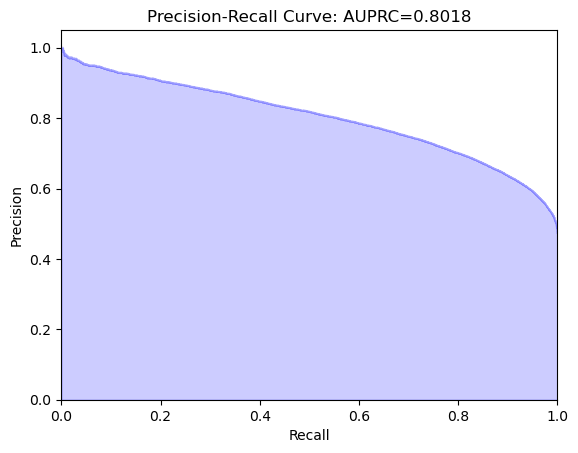

In [39]:
print("GradientBoosting:")

# gb= GradientBoostingClassifier(random_state=1234)
start = time.time()
gb_tuned.fit(X_train_minmax,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb_tuned.predict_proba(X_test_minmax)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB_tuned_with_MinMax"]
results.extend(result)
results.append(runtime)
result_list_gb.append(results)

(vi) Performance Output for tuned model

In [40]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list_gb, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]

# Save table to Excel
formatted_result_df.to_csv(os.path.join(path, 'gb_table.csv'), index=False)

# Print the table
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,GB_without_scaling,0.497,0.818 (0.815-0.82),0.791 (0.786-0.796),0.737 (0.735-0.757),0.741 (0.725-0.747),111.905
1,GB_with_minmax_scaling,0.497,0.818 (0.815-0.82),0.791 (0.786-0.796),0.737 (0.735-0.757),0.741 (0.725-0.747),108.119
2,GB_with_robust_scaling,0.497,0.818 (0.815-0.82),0.791 (0.786-0.796),0.737 (0.735-0.757),0.741 (0.725-0.747),117.341
3,GB_with_standard_scaling,0.497,0.818 (0.815-0.82),0.791 (0.786-0.796),0.737 (0.735-0.757),0.741 (0.725-0.747),110.724
4,GB_tuned_with_MinMax,0.484,0.827 (0.825-0.829),0.802 (0.798-0.806),0.751 (0.742-0.754),0.745 (0.741-0.755),287.404


(vii) Important features

In [41]:
# Feature importance for LR model
gb_feature_importance = pd.DataFrame(
        {
            'features': np.array(X_train_minmax.columns),    
            'importance' : gb_tuned.feature_importances_
            })

# Save table to Excel
gb_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False).to_csv(os.path.join(path, 'gb_feature_impt.csv'), index=False)

# Check top 20 features
gb_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20]

,features,importance
119,triage_acuity,0.453571
121,score_CCI,0.252536
116,triage_o2sat,0.028696
108,n_hosp_90d,0.027134
126,n_medrecon,0.021669
118,triage_pain,0.019561
106,n_ed_365d,0.019478
109,n_hosp_365d,0.018403
124,score_NEWS,0.016760
2,chiefcom_abdominal_pain,0.012741


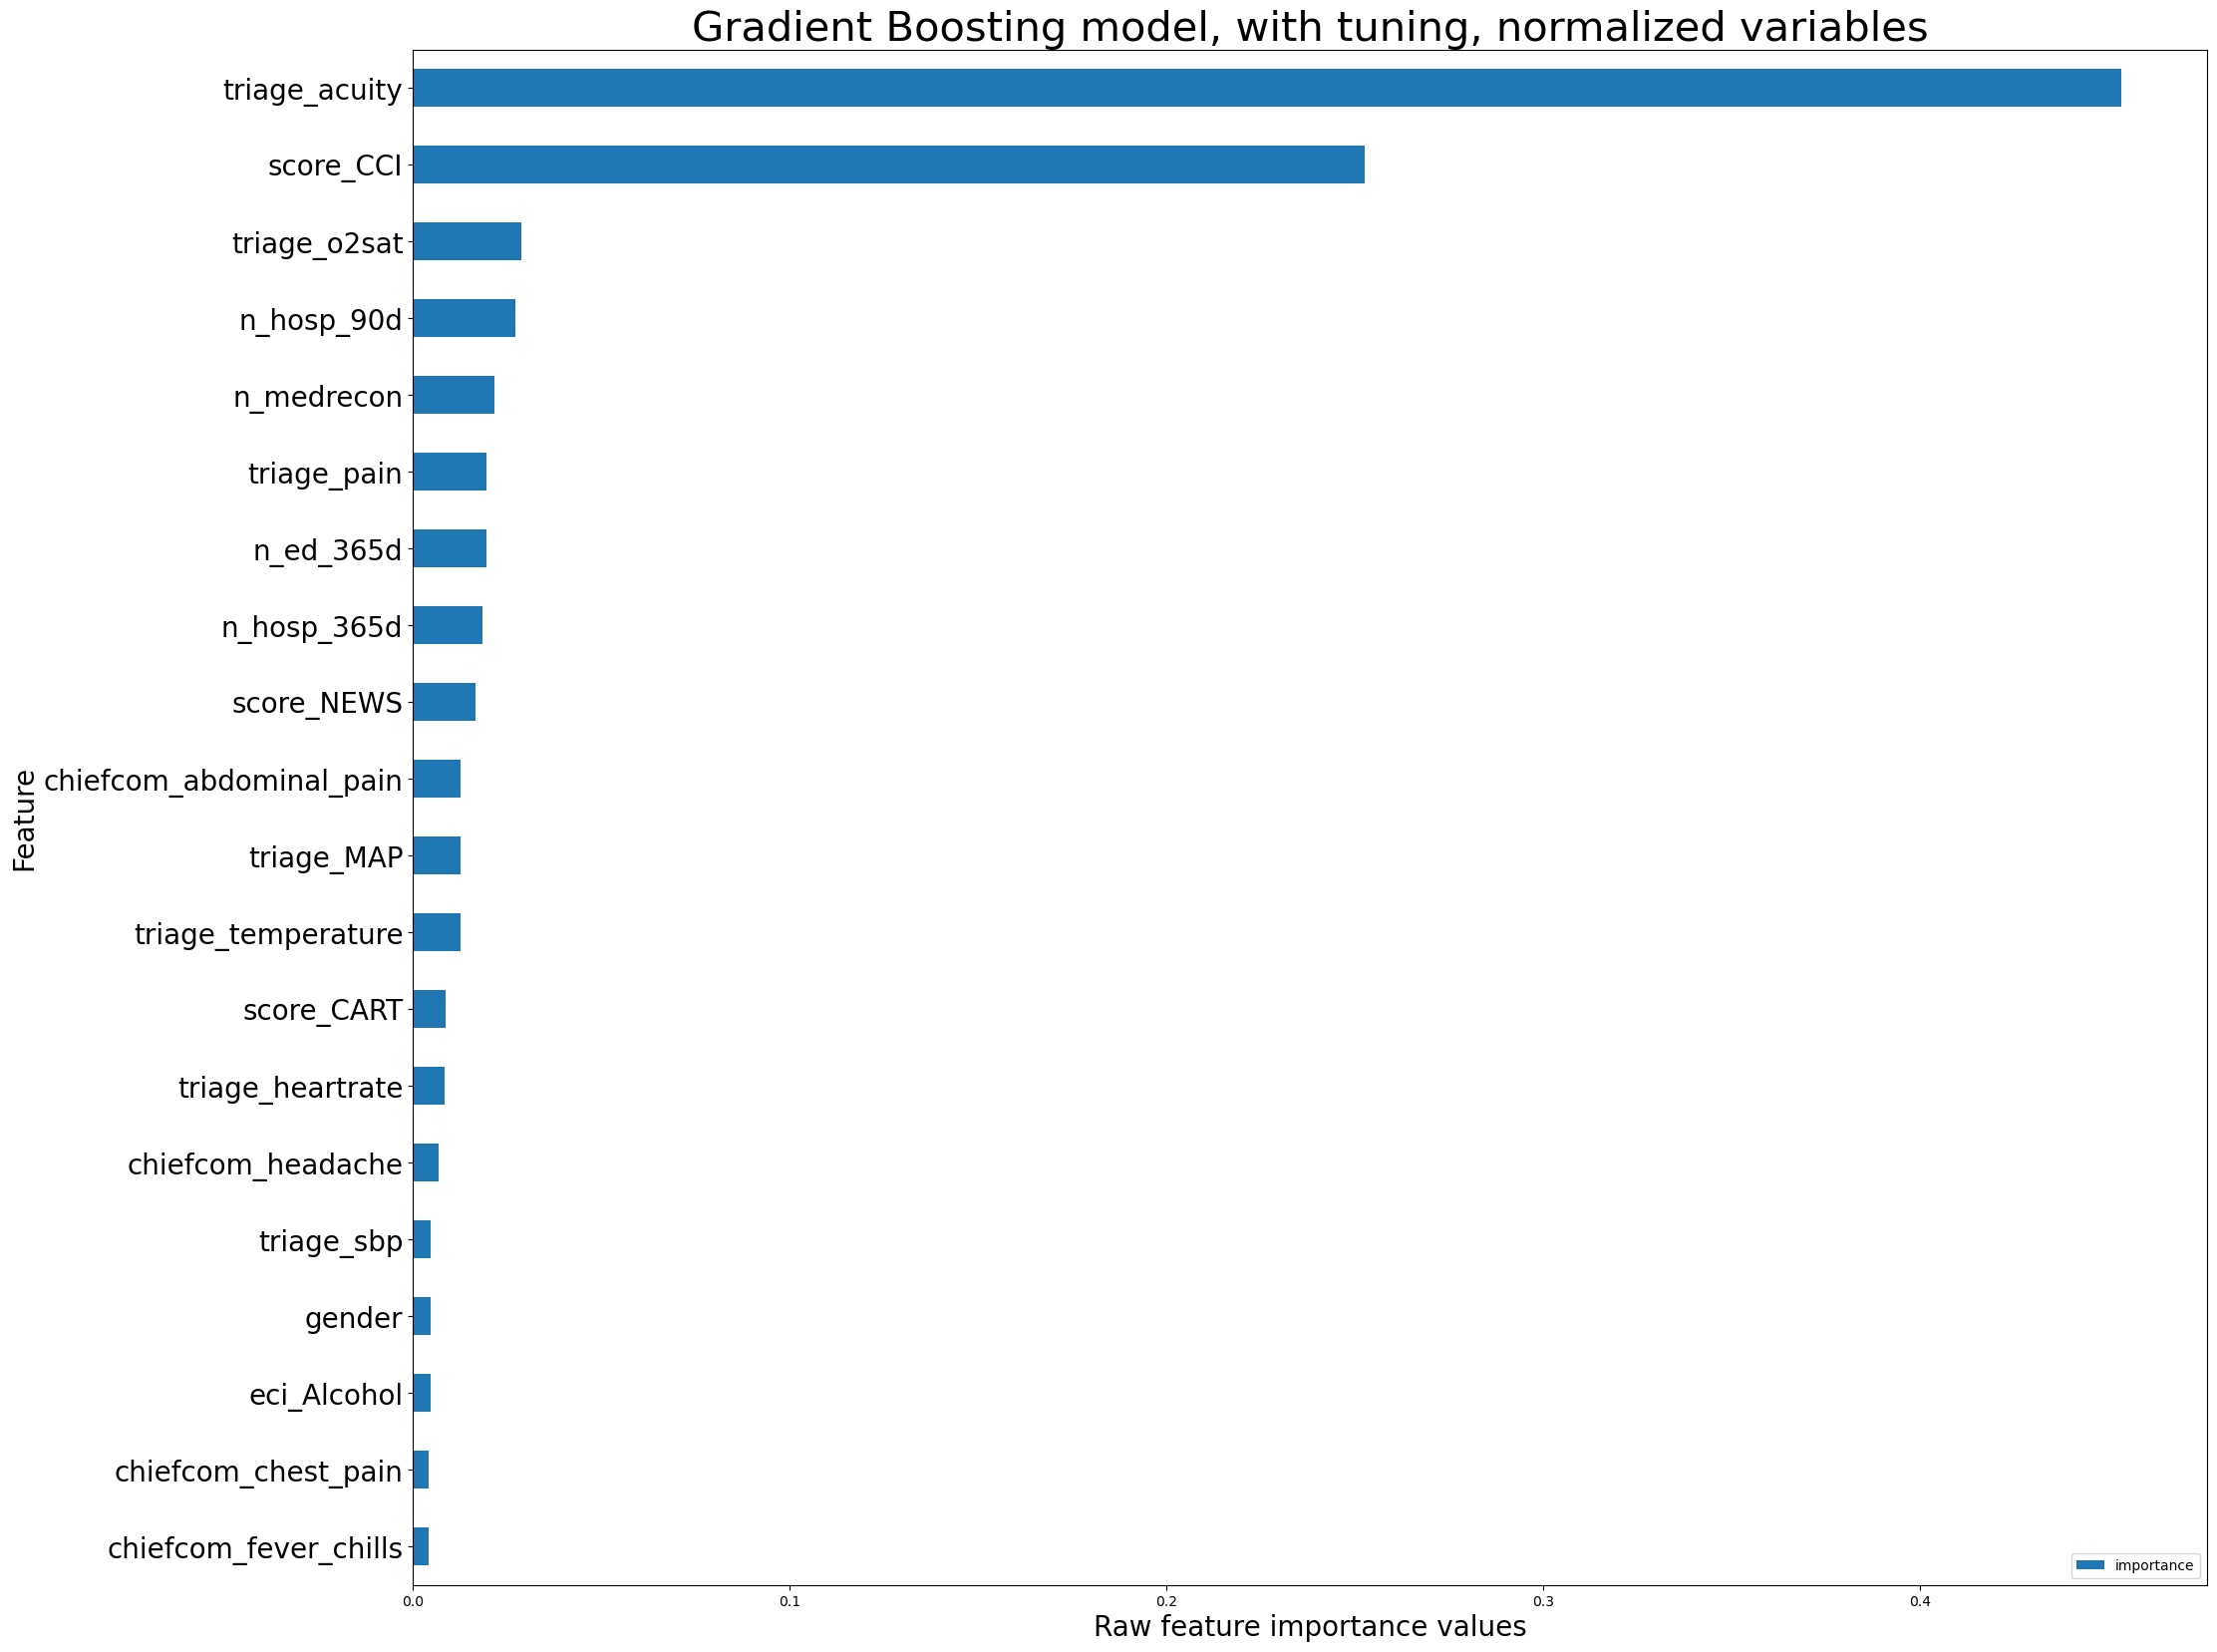

In [42]:
sorted_feature_importance = gb_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20].set_index('features')

sorted_feature_importance.sort_values(by='importance',key=lambda x:abs(x)).plot.barh(figsize=(30, 20))
plt.title("Gradient Boosting model, with tuning, normalized variables", fontsize=30)
plt.xlabel("Raw feature importance values", fontsize=20)
plt.ylabel('Feature',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

#### d. MLP

In [239]:
# Containers for all results
result_list_mlp = []

(i) Model with no scaling of numeric features

In [240]:
# Build MLP architecture

class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [241]:
# Compile and fit model
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

Epoch 1/20
1761/1761 [==============================] - 4s 1ms/step - loss: 0.5740 - accuracy: 0.7155 - auc: 0.7839 - auprc: 0.7469 - true_positives: 111233.0000 - true_negatives: 140718.0000 - precision: 0.7115 - recall: 0.6689
Epoch 2/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5335 - accuracy: 0.7323 - auc: 0.8081 - auprc: 0.7790 - true_positives: 117032.0000 - true_negatives: 140822.0000 - precision: 0.7222 - recall: 0.7038
Epoch 3/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5269 - accuracy: 0.7363 - auc: 0.8129 - auprc: 0.7839 - true_positives: 119421.0000 - true_negatives: 139857.0000 - precision: 0.7220 - recall: 0.7182
Epoch 4/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5245 - accuracy: 0.7383 - auc: 0.8146 - auprc: 0.7862 - true_positives: 120366.0000 - true_negatives: 139601.0000 - precision: 0.7225 - recall: 0.7238
Epoch 5/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5217 -

MLP:
2751/2751 [==============================] - 1s 523us/step
AUC: 0.8250496135036922
AUPRC: 0.7997279896521172
Sensitivity: 0.7585496201500228
Specificity: 0.7314586842900954
Score thresold: 0.5196767
2.5 97.5


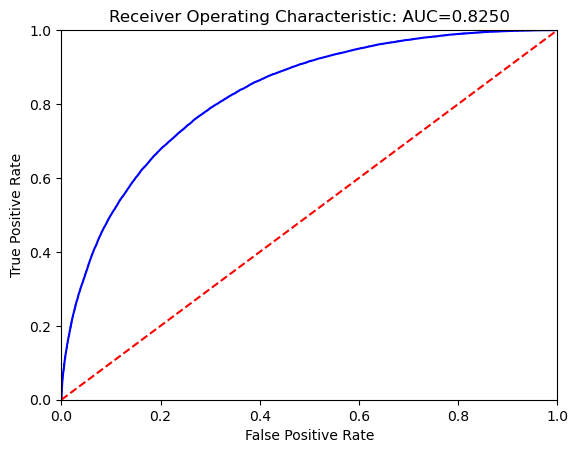

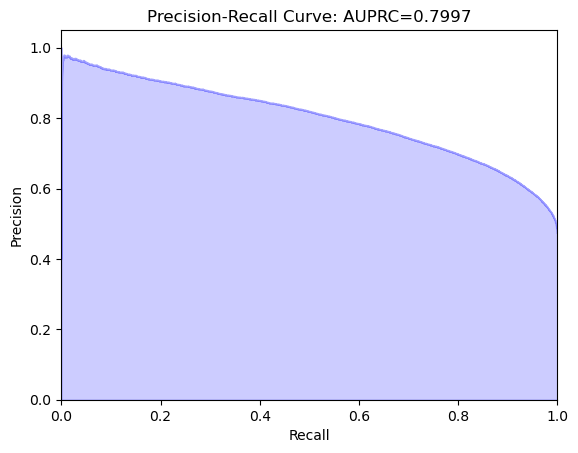

In [242]:
print("MLP:")
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP_without_scaling"]
results.extend(result)
results.append(runtime)
result_list_mlp.append(results)

(ii) Model with MinMax Scaling of numeric features

In [243]:
# Compule MLP and fit model
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train_minmax.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

Epoch 1/20
1761/1761 [==============================] - 3s 1ms/step - loss: 0.5317 - accuracy: 0.7324 - auc: 0.8082 - auprc: 0.7772 - true_positives: 119262.0000 - true_negatives: 138619.0000 - precision: 0.7164 - recall: 0.7172
Epoch 2/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5166 - accuracy: 0.7430 - auc: 0.8208 - auprc: 0.7927 - true_positives: 122557.0000 - true_negatives: 139079.0000 - precision: 0.7239 - recall: 0.7370
Epoch 3/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5127 - accuracy: 0.7453 - auc: 0.8239 - auprc: 0.7970 - true_positives: 123122.0000 - true_negatives: 139312.0000 - precision: 0.7258 - recall: 0.7404
Epoch 4/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5093 - accuracy: 0.7472 - auc: 0.8265 - auprc: 0.8006 - true_positives: 123360.0000 - true_negatives: 139757.0000 - precision: 0.7281 - recall: 0.7419
Epoch 5/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5069 -

MLP:
2751/2751 [==============================] - 1s 509us/step
AUC: 0.8163331347964011
AUPRC: 0.7869146608519395
Sensitivity: 0.7466867975171951
Specificity: 0.7338127942637467
Score thresold: 0.4599482
2.5 97.5


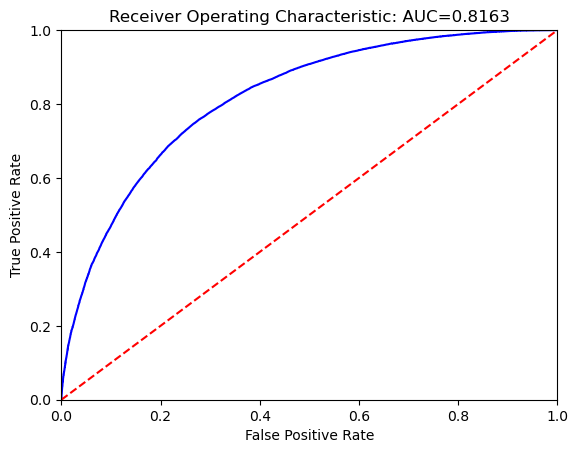

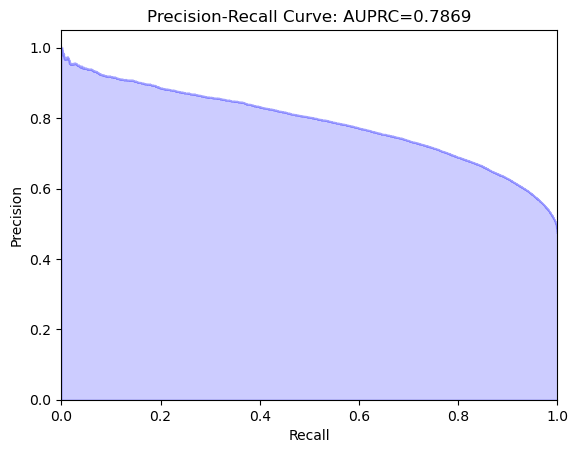

In [244]:
print("MLP:")
probs = mlp.predict(X_test_minmax.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP_with_minmax_scaling"]
results.extend(result)
results.append(runtime)
result_list_mlp.append(results)

(iii) Model with Robust Scaling of numeric features

In [245]:
# Compule MLP and fit model
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train_robust.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

Epoch 1/20
1761/1761 [==============================] - 3s 1ms/step - loss: 0.5172 - accuracy: 0.7425 - auc: 0.8205 - auprc: 0.7920 - true_positives: 122723.0000 - true_negatives: 138724.0000 - precision: 0.7226 - recall: 0.7380
Epoch 2/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5069 - accuracy: 0.7494 - auc: 0.8285 - auprc: 0.8024 - true_positives: 123903.0000 - true_negatives: 139985.0000 - precision: 0.7299 - recall: 0.7451
Epoch 3/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5034 - accuracy: 0.7512 - auc: 0.8312 - auprc: 0.8061 - true_positives: 124160.0000 - true_negatives: 140360.0000 - precision: 0.7320 - recall: 0.7467
Epoch 4/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5007 - accuracy: 0.7533 - auc: 0.8334 - auprc: 0.8089 - true_positives: 124392.0000 - true_negatives: 140873.0000 - precision: 0.7345 - recall: 0.7481
Epoch 5/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.4982 -

MLP:
2751/2751 [==============================] - 1s 491us/step
AUC: 0.816156987111068
AUPRC: 0.7884633531964096
Sensitivity: 0.7518633019387926
Specificity: 0.7263401148978446
Score thresold: 0.46702322
2.5 97.5


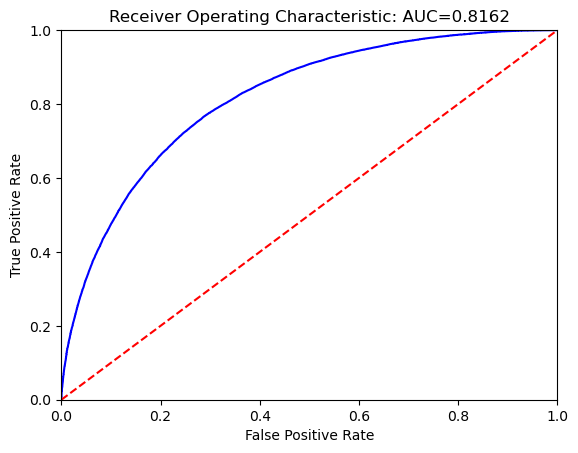

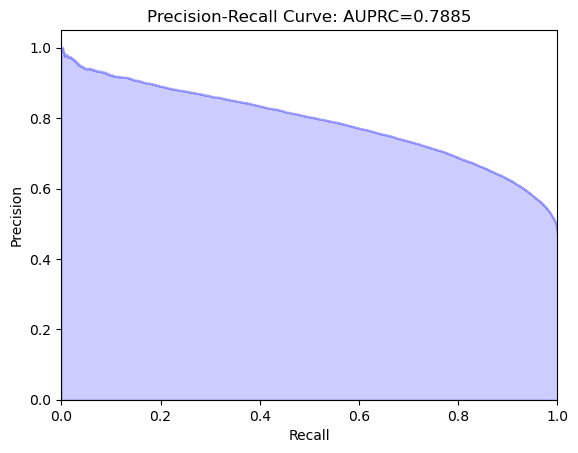

In [246]:
print("MLP:")
probs = mlp.predict(X_test_robust.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP_with_robust_scaling"]
results.extend(result)
results.append(runtime)
result_list_mlp.append(results)

(iv) Model with Standard Scaling of numeric features

In [247]:
# Compule MLP and fit model
mlp = MLP()
mlp.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train_scaled.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

Epoch 1/20
1761/1761 [==============================] - 3s 1ms/step - loss: 0.5164 - accuracy: 0.7427 - auc: 0.8209 - auprc: 0.7925 - true_positives: 122500.0000 - true_negatives: 139030.0000 - precision: 0.7236 - recall: 0.7367
Epoch 2/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5068 - accuracy: 0.7495 - auc: 0.8287 - auprc: 0.8028 - true_positives: 123868.0000 - true_negatives: 140029.0000 - precision: 0.7301 - recall: 0.7449
Epoch 3/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5034 - accuracy: 0.7516 - auc: 0.8313 - auprc: 0.8067 - true_positives: 124048.0000 - true_negatives: 140611.0000 - precision: 0.7329 - recall: 0.7460
Epoch 4/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.5007 - accuracy: 0.7535 - auc: 0.8333 - auprc: 0.8093 - true_positives: 124268.0000 - true_negatives: 141043.0000 - precision: 0.7351 - recall: 0.7473
Epoch 5/20
1761/1761 [==============================] - 2s 1ms/step - loss: 0.4983 -

MLP:
2751/2751 [==============================] - 1s 490us/step
AUC: 0.8170170104250145
AUPRC: 0.7892427259909365
Sensitivity: 0.7422292520430417
Specificity: 0.7352166213122544
Score thresold: 0.4401438
2.5 97.5


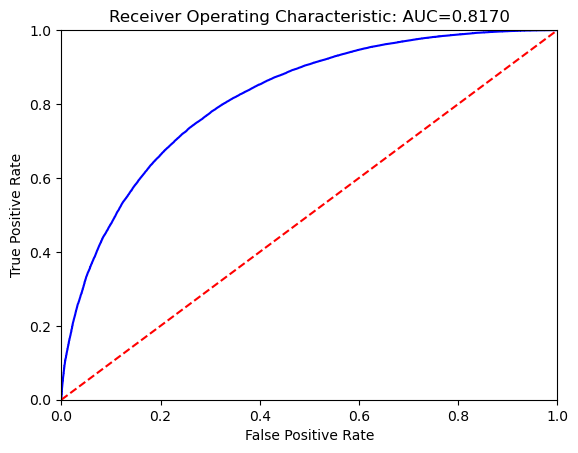

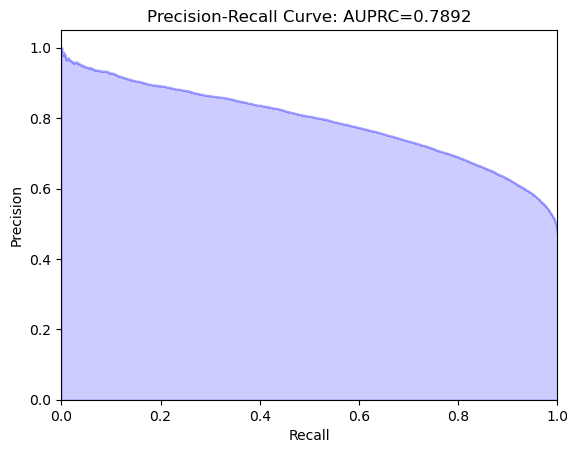

In [248]:
print("MLP:")
probs = mlp.predict(X_test_scaled.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP_with_standard_scaling"]
results.extend(result)
results.append(runtime)
result_list_mlp.append(results)

(v) Model Tuning

Dataset: Using the dataset without any scaling as it gives the best AUROC score

- Tune Number of Layers and Neurons using Optuna

In [260]:
#Convert pandas DataFrames to numpy arrays:
X_train_array = X_train.values.astype(np.float32)
y_train_array = y_train.values.astype(np.float32)
X_test_array = X_test.values.astype(np.float32)
y_test_array = y_test.values.astype(np.float32)

In [263]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_auc_score

# Generates a Keras Sequential model based on the hyperparameters sampled by Optuna
# Set n_layers between 1 to 5 and neurons to between 1 to 128 to balance between time-complexity and accuracy
def create_model(trial):
    model = Sequential()
    n_layers = trial.suggest_int('n_layers', 1, 5)
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_{i}', 1, 128)
        model.add(Dense(n_units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.optimizers.Adam(learning_rate=0.001), 
                  metrics=['accuracy', 'AUC', 
                           tf.keras.metrics.AUC(name='auprc', curve='PR'),
                           'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
    return model

def create_keras_model(trial):
    return lambda: create_model(trial)

def func(trial):
    model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)
    model.fit(X_train_array, y_train_array)

    y_pred = model.predict_proba(X_test_array)
    y_pred_positive = y_pred[:, 1]  # Extract positive class probabilities
    auroc = roc_auc_score(y_test_array, y_pred_positive)
    
    return auroc

# We want to maximize AUROC
study = optuna.create_study(direction="maximize")  
study.optimize(func, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2023-08-15 20:54:44,005] A new study created in memory with name: no-name-bc9fe4af-471e-48ac-978b-183b90b51997
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 551us/step


[I 2023-08-15 20:55:41,386] Trial 0 finished with value: 0.8244851373573123 and parameters: {'n_layers': 5, 'n_units_0': 41, 'n_units_1': 112, 'n_units_2': 104, 'n_units_3': 6, 'n_units_4': 6}. Best is trial 0 with value: 0.8244851373573123.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 487us/step


[I 2023-08-15 20:56:24,987] Trial 1 finished with value: 0.813765221671602 and parameters: {'n_layers': 3, 'n_units_0': 1, 'n_units_1': 85, 'n_units_2': 107}. Best is trial 0 with value: 0.8244851373573123.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 506us/step


[I 2023-08-15 20:57:06,882] Trial 2 finished with value: 0.8250865622049015 and parameters: {'n_layers': 2, 'n_units_0': 122, 'n_units_1': 19}. Best is trial 2 with value: 0.8250865622049015.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 545us/step


[I 2023-08-15 20:57:59,942] Trial 3 finished with value: 0.8248871500336787 and parameters: {'n_layers': 5, 'n_units_0': 94, 'n_units_1': 11, 'n_units_2': 110, 'n_units_3': 116, 'n_units_4': 41}. Best is trial 2 with value: 0.8250865622049015.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 524us/step


[I 2023-08-15 20:58:45,685] Trial 4 finished with value: 0.8199089030474311 and parameters: {'n_layers': 5, 'n_units_0': 3, 'n_units_1': 103, 'n_units_2': 56, 'n_units_3': 35, 'n_units_4': 128}. Best is trial 2 with value: 0.8250865622049015.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 504us/step


[I 2023-08-15 20:59:17,578] Trial 5 finished with value: 0.8218551454042426 and parameters: {'n_layers': 2, 'n_units_0': 22, 'n_units_1': 15}. Best is trial 2 with value: 0.8250865622049015.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 529us/step


[I 2023-08-15 21:00:07,057] Trial 6 finished with value: 0.8251817818492099 and parameters: {'n_layers': 4, 'n_units_0': 71, 'n_units_1': 86, 'n_units_2': 94, 'n_units_3': 31}. Best is trial 6 with value: 0.8251817818492099.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 541us/step


[I 2023-08-15 21:01:07,412] Trial 7 finished with value: 0.8244449744428485 and parameters: {'n_layers': 5, 'n_units_0': 41, 'n_units_1': 126, 'n_units_2': 72, 'n_units_3': 17, 'n_units_4': 45}. Best is trial 6 with value: 0.8251817818492099.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 510us/step


[I 2023-08-15 21:01:41,803] Trial 8 finished with value: 0.8220464513917475 and parameters: {'n_layers': 1, 'n_units_0': 41}. Best is trial 6 with value: 0.8251817818492099.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 547us/step


[I 2023-08-15 21:02:41,258] Trial 9 finished with value: 0.8258255561561736 and parameters: {'n_layers': 5, 'n_units_0': 84, 'n_units_1': 32, 'n_units_2': 63, 'n_units_3': 90, 'n_units_4': 56}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 528us/step


[I 2023-08-15 21:03:29,819] Trial 10 finished with value: 0.5 and parameters: {'n_layers': 4, 'n_units_0': 89, 'n_units_1': 47, 'n_units_2': 5, 'n_units_3': 97}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 532us/step


[I 2023-08-15 21:04:27,347] Trial 11 finished with value: 0.825506290579203 and parameters: {'n_layers': 4, 'n_units_0': 74, 'n_units_1': 53, 'n_units_2': 61, 'n_units_3': 72}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 527us/step


[I 2023-08-15 21:05:18,429] Trial 12 finished with value: 0.8243612167554686 and parameters: {'n_layers': 4, 'n_units_0': 79, 'n_units_1': 46, 'n_units_2': 42, 'n_units_3': 74}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 570us/step


[I 2023-08-15 21:06:08,076] Trial 13 finished with value: 0.8247234743756713 and parameters: {'n_layers': 3, 'n_units_0': 112, 'n_units_1': 44, 'n_units_2': 27}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 531us/step


[I 2023-08-15 21:07:18,907] Trial 14 finished with value: 0.8246566580765601 and parameters: {'n_layers': 4, 'n_units_0': 61, 'n_units_1': 65, 'n_units_2': 75, 'n_units_3': 69}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 521us/step


[I 2023-08-15 21:08:22,825] Trial 15 finished with value: 0.8244784941323325 and parameters: {'n_layers': 4, 'n_units_0': 103, 'n_units_1': 32, 'n_units_2': 48, 'n_units_3': 95}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 569us/step


[I 2023-08-15 21:09:38,185] Trial 16 finished with value: 0.825510580078776 and parameters: {'n_layers': 5, 'n_units_0': 58, 'n_units_1': 65, 'n_units_2': 83, 'n_units_3': 57, 'n_units_4': 97}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 557us/step


[I 2023-08-15 21:10:54,339] Trial 17 finished with value: 0.824315569233798 and parameters: {'n_layers': 5, 'n_units_0': 57, 'n_units_1': 71, 'n_units_2': 128, 'n_units_3': 49, 'n_units_4': 95}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 511us/step


[I 2023-08-15 21:11:40,049] Trial 18 finished with value: 0.8243789508277308 and parameters: {'n_layers': 3, 'n_units_0': 53, 'n_units_1': 28, 'n_units_2': 84}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 557us/step


[I 2023-08-15 21:12:51,454] Trial 19 finished with value: 0.8231938121722073 and parameters: {'n_layers': 5, 'n_units_0': 85, 'n_units_1': 74, 'n_units_2': 31, 'n_units_3': 92, 'n_units_4': 83}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 518us/step


[I 2023-08-15 21:13:27,710] Trial 20 finished with value: 0.8209317953605513 and parameters: {'n_layers': 2, 'n_units_0': 24, 'n_units_1': 31}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 543us/step


[I 2023-08-15 21:14:31,465] Trial 21 finished with value: 0.824898653138748 and parameters: {'n_layers': 4, 'n_units_0': 73, 'n_units_1': 55, 'n_units_2': 61, 'n_units_3': 55}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 563us/step


[I 2023-08-15 21:15:52,770] Trial 22 finished with value: 0.8230518738606034 and parameters: {'n_layers': 5, 'n_units_0': 101, 'n_units_1': 3, 'n_units_2': 81, 'n_units_3': 84, 'n_units_4': 104}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 549us/step


[I 2023-08-15 21:17:01,211] Trial 23 finished with value: 0.8237182038185046 and parameters: {'n_layers': 4, 'n_units_0': 68, 'n_units_1': 58, 'n_units_2': 60, 'n_units_3': 123}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 545us/step


[I 2023-08-15 21:18:12,404] Trial 24 finished with value: 0.8243795137032404 and parameters: {'n_layers': 5, 'n_units_0': 51, 'n_units_1': 85, 'n_units_2': 89, 'n_units_3': 57, 'n_units_4': 60}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 513us/step


[I 2023-08-15 21:19:02,630] Trial 25 finished with value: 0.8244330753839724 and parameters: {'n_layers': 3, 'n_units_0': 82, 'n_units_1': 40, 'n_units_2': 70}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 536us/step


[I 2023-08-15 21:19:59,440] Trial 26 finished with value: 0.8237340763902883 and parameters: {'n_layers': 4, 'n_units_0': 96, 'n_units_1': 54, 'n_units_2': 41, 'n_units_3': 74}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 547us/step


[I 2023-08-15 21:21:02,758] Trial 27 finished with value: 0.8252898896605309 and parameters: {'n_layers': 5, 'n_units_0': 110, 'n_units_1': 73, 'n_units_2': 51, 'n_units_3': 41, 'n_units_4': 75}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 514us/step


[I 2023-08-15 21:22:13,401] Trial 28 finished with value: 0.8248698714376912 and parameters: {'n_layers': 4, 'n_units_0': 77, 'n_units_1': 36, 'n_units_2': 96, 'n_units_3': 108}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 541us/step


[I 2023-08-15 21:23:22,118] Trial 29 finished with value: 0.8243315836243306 and parameters: {'n_layers': 5, 'n_units_0': 66, 'n_units_1': 25, 'n_units_2': 20, 'n_units_3': 83, 'n_units_4': 117}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 545us/step


[I 2023-08-15 21:24:27,495] Trial 30 finished with value: 0.8240183854571634 and parameters: {'n_layers': 5, 'n_units_0': 48, 'n_units_1': 100, 'n_units_2': 69, 'n_units_3': 60, 'n_units_4': 17}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 569us/step


[I 2023-08-15 21:25:40,432] Trial 31 finished with value: 0.8243889537078211 and parameters: {'n_layers': 5, 'n_units_0': 113, 'n_units_1': 76, 'n_units_2': 51, 'n_units_3': 42, 'n_units_4': 78}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 582us/step


[I 2023-08-15 21:26:54,044] Trial 32 finished with value: 0.8235548180090354 and parameters: {'n_layers': 5, 'n_units_0': 125, 'n_units_1': 65, 'n_units_2': 65, 'n_units_3': 45, 'n_units_4': 67}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 543us/step


[I 2023-08-15 21:28:00,179] Trial 33 finished with value: 0.8242649078500018 and parameters: {'n_layers': 5, 'n_units_0': 114, 'n_units_1': 82, 'n_units_2': 41, 'n_units_3': 26, 'n_units_4': 52}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 596us/step


[I 2023-08-15 21:29:40,194] Trial 34 finished with value: 0.8252265440388722 and parameters: {'n_layers': 5, 'n_units_0': 90, 'n_units_1': 94, 'n_units_2': 78, 'n_units_3': 66, 'n_units_4': 82}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 529us/step


[I 2023-08-15 21:30:40,496] Trial 35 finished with value: 0.8223326351575613 and parameters: {'n_layers': 4, 'n_units_0': 31, 'n_units_1': 58, 'n_units_2': 53, 'n_units_3': 82}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 569us/step


[I 2023-08-15 21:31:56,554] Trial 36 finished with value: 0.8251316082908553 and parameters: {'n_layers': 5, 'n_units_0': 103, 'n_units_1': 67, 'n_units_2': 63, 'n_units_3': 53, 'n_units_4': 30}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 487us/step


[I 2023-08-15 21:32:36,421] Trial 37 finished with value: 0.8211635931888521 and parameters: {'n_layers': 1, 'n_units_0': 62}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 531us/step


[I 2023-08-15 21:33:35,626] Trial 38 finished with value: 0.8251856086262951 and parameters: {'n_layers': 3, 'n_units_0': 74, 'n_units_1': 51, 'n_units_2': 112}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 587us/step


[I 2023-08-15 21:34:55,453] Trial 39 finished with value: 0.8249494666930267 and parameters: {'n_layers': 5, 'n_units_0': 120, 'n_units_1': 20, 'n_units_2': 102, 'n_units_3': 106, 'n_units_4': 100}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 548us/step


[I 2023-08-15 21:35:54,441] Trial 40 finished with value: 0.8250045951086256 and parameters: {'n_layers': 4, 'n_units_0': 97, 'n_units_1': 78, 'n_units_2': 89, 'n_units_3': 9}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 568us/step


[I 2023-08-15 21:37:26,584] Trial 41 finished with value: 0.8255578323779341 and parameters: {'n_layers': 5, 'n_units_0': 90, 'n_units_1': 106, 'n_units_2': 78, 'n_units_3': 65, 'n_units_4': 76}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 573us/step


[I 2023-08-15 21:38:51,367] Trial 42 finished with value: 0.8254647306983018 and parameters: {'n_layers': 5, 'n_units_0': 84, 'n_units_1': 117, 'n_units_2': 57, 'n_units_3': 66, 'n_units_4': 68}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 624us/step


[I 2023-08-15 21:40:19,942] Trial 43 finished with value: 0.8255501583790901 and parameters: {'n_layers': 5, 'n_units_0': 87, 'n_units_1': 118, 'n_units_2': 76, 'n_units_3': 75, 'n_units_4': 64}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 587us/step


[I 2023-08-15 21:41:52,507] Trial 44 finished with value: 0.8227671659931948 and parameters: {'n_layers': 5, 'n_units_0': 89, 'n_units_1': 124, 'n_units_2': 83, 'n_units_3': 74, 'n_units_4': 89}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 550us/step


[I 2023-08-15 21:43:03,632] Trial 45 finished with value: 0.8257065798010472 and parameters: {'n_layers': 4, 'n_units_0': 80, 'n_units_1': 109, 'n_units_2': 72, 'n_units_3': 86}. Best is trial 9 with value: 0.8258255561561736.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 568us/step


[I 2023-08-15 21:44:20,941] Trial 46 finished with value: 0.8258936700450802 and parameters: {'n_layers': 5, 'n_units_0': 81, 'n_units_1': 109, 'n_units_2': 74, 'n_units_3': 90, 'n_units_4': 59}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 562us/step


[I 2023-08-15 21:45:31,773] Trial 47 finished with value: 0.8255462019465426 and parameters: {'n_layers': 4, 'n_units_0': 93, 'n_units_1': 108, 'n_units_2': 69, 'n_units_3': 89}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 549us/step


[I 2023-08-15 21:46:24,793] Trial 48 finished with value: 0.8246117460455552 and parameters: {'n_layers': 2, 'n_units_0': 80, 'n_units_1': 117}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 555us/step


[I 2023-08-15 21:48:12,254] Trial 49 finished with value: 0.8255451033688239 and parameters: {'n_layers': 5, 'n_units_0': 85, 'n_units_1': 93, 'n_units_2': 76, 'n_units_3': 104, 'n_units_4': 57}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 572us/step


[I 2023-08-15 21:49:44,910] Trial 50 finished with value: 0.8242778860770963 and parameters: {'n_layers': 3, 'n_units_0': 107, 'n_units_1': 106, 'n_units_2': 92}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 585us/step


[I 2023-08-15 21:51:19,451] Trial 51 finished with value: 0.824754750844504 and parameters: {'n_layers': 4, 'n_units_0': 93, 'n_units_1': 110, 'n_units_2': 73, 'n_units_3': 89}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 548us/step


[I 2023-08-15 21:52:47,976] Trial 52 finished with value: 0.8254035457422197 and parameters: {'n_layers': 4, 'n_units_0': 89, 'n_units_1': 117, 'n_units_2': 65, 'n_units_3': 99}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 575us/step


[I 2023-08-15 21:54:10,739] Trial 53 finished with value: 0.8253839985638336 and parameters: {'n_layers': 5, 'n_units_0': 98, 'n_units_1': 99, 'n_units_2': 70, 'n_units_3': 82, 'n_units_4': 37}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 568us/step


[I 2023-08-15 21:55:33,019] Trial 54 finished with value: 0.8252790516543398 and parameters: {'n_layers': 4, 'n_units_0': 77, 'n_units_1': 110, 'n_units_2': 75, 'n_units_3': 114}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 762us/step


[I 2023-08-15 21:56:50,360] Trial 55 finished with value: 0.8186153946817287 and parameters: {'n_layers': 5, 'n_units_0': 6, 'n_units_1': 128, 'n_units_2': 98, 'n_units_3': 87, 'n_units_4': 51}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 573us/step


[I 2023-08-15 21:58:20,185] Trial 56 finished with value: 0.8243688695332589 and parameters: {'n_layers': 4, 'n_units_0': 70, 'n_units_1': 122, 'n_units_2': 66, 'n_units_3': 77}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 616us/step


[I 2023-08-15 22:00:15,611] Trial 57 finished with value: 0.8255064217874253 and parameters: {'n_layers': 5, 'n_units_0': 93, 'n_units_1': 104, 'n_units_2': 86, 'n_units_3': 98, 'n_units_4': 69}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 557us/step


[I 2023-08-15 22:01:41,013] Trial 58 finished with value: 0.8247710693172086 and parameters: {'n_layers': 5, 'n_units_0': 86, 'n_units_1': 95, 'n_units_2': 57, 'n_units_3': 92, 'n_units_4': 27}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 584us/step


[I 2023-08-15 22:02:56,650] Trial 59 finished with value: 0.8256763799124996 and parameters: {'n_layers': 3, 'n_units_0': 80, 'n_units_1': 113, 'n_units_2': 79}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 612us/step


[I 2023-08-15 22:04:10,083] Trial 60 finished with value: 0.8257276119356054 and parameters: {'n_layers': 3, 'n_units_0': 80, 'n_units_1': 113, 'n_units_2': 78}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 618us/step


[I 2023-08-15 22:05:24,609] Trial 61 finished with value: 0.8255678124842107 and parameters: {'n_layers': 3, 'n_units_0': 79, 'n_units_1': 114, 'n_units_2': 78}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 587us/step


[I 2023-08-15 22:06:36,215] Trial 62 finished with value: 0.8252855214877831 and parameters: {'n_layers': 3, 'n_units_0': 80, 'n_units_1': 113, 'n_units_2': 81}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 561us/step


[I 2023-08-15 22:08:23,962] Trial 63 finished with value: 0.8245059963591276 and parameters: {'n_layers': 3, 'n_units_0': 74, 'n_units_1': 113, 'n_units_2': 87}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 543us/step


[I 2023-08-15 22:09:52,427] Trial 64 finished with value: 0.8242396902507925 and parameters: {'n_layers': 3, 'n_units_0': 65, 'n_units_1': 100, 'n_units_2': 80}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 556us/step


[I 2023-08-15 22:11:18,711] Trial 65 finished with value: 0.8248724492781285 and parameters: {'n_layers': 3, 'n_units_0': 77, 'n_units_1': 90, 'n_units_2': 93}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 521us/step


[I 2023-08-15 22:12:25,494] Trial 66 finished with value: 0.8250160042717132 and parameters: {'n_layers': 2, 'n_units_0': 70, 'n_units_1': 122}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 535us/step


[I 2023-08-15 22:13:31,493] Trial 67 finished with value: 0.8239951331345609 and parameters: {'n_layers': 2, 'n_units_0': 81, 'n_units_1': 103}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 521us/step


[I 2023-08-15 22:14:16,230] Trial 68 finished with value: 0.5 and parameters: {'n_layers': 3, 'n_units_0': 59, 'n_units_1': 1, 'n_units_2': 72}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 563us/step


[I 2023-08-15 22:15:32,013] Trial 69 finished with value: 0.8245500830981785 and parameters: {'n_layers': 3, 'n_units_0': 100, 'n_units_1': 113, 'n_units_2': 79}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 549us/step


[I 2023-08-15 22:16:44,181] Trial 70 finished with value: 0.8250699349917451 and parameters: {'n_layers': 3, 'n_units_0': 68, 'n_units_1': 120, 'n_units_2': 111}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 575us/step


[I 2023-08-15 22:18:29,560] Trial 71 finished with value: 0.8237547834804142 and parameters: {'n_layers': 3, 'n_units_0': 88, 'n_units_1': 117, 'n_units_2': 76}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 581us/step


[I 2023-08-15 22:20:12,683] Trial 72 finished with value: 0.8252338704782636 and parameters: {'n_layers': 3, 'n_units_0': 83, 'n_units_1': 108, 'n_units_2': 84}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 557us/step


[I 2023-08-15 22:21:51,335] Trial 73 finished with value: 0.8246099399268512 and parameters: {'n_layers': 3, 'n_units_0': 74, 'n_units_1': 125, 'n_units_2': 67}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 588us/step


[I 2023-08-15 22:22:52,579] Trial 74 finished with value: 0.823301594680303 and parameters: {'n_layers': 2, 'n_units_0': 78, 'n_units_1': 7}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 697us/step


[I 2023-08-15 22:24:45,718] Trial 75 finished with value: 0.8253036401269451 and parameters: {'n_layers': 5, 'n_units_0': 91, 'n_units_1': 100, 'n_units_2': 73, 'n_units_3': 78, 'n_units_4': 61}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 611us/step


[I 2023-08-15 22:26:11,383] Trial 76 finished with value: 0.8253360043041763 and parameters: {'n_layers': 3, 'n_units_0': 86, 'n_units_1': 120, 'n_units_2': 61}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 592us/step


[I 2023-08-15 22:27:48,879] Trial 77 finished with value: 0.8253396804635389 and parameters: {'n_layers': 4, 'n_units_0': 95, 'n_units_1': 128, 'n_units_2': 79, 'n_units_3': 63}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 619us/step


[I 2023-08-15 22:29:29,163] Trial 78 finished with value: 0.8251413604002014 and parameters: {'n_layers': 5, 'n_units_0': 106, 'n_units_1': 114, 'n_units_2': 47, 'n_units_3': 128, 'n_units_4': 49}. Best is trial 46 with value: 0.8258936700450802.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 647us/step


[I 2023-08-15 22:32:00,386] Trial 79 finished with value: 0.825923828009107 and parameters: {'n_layers': 5, 'n_units_0': 82, 'n_units_1': 104, 'n_units_2': 90, 'n_units_3': 72, 'n_units_4': 68}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 613us/step


[I 2023-08-15 22:34:07,672] Trial 80 finished with value: 0.8252367671520928 and parameters: {'n_layers': 5, 'n_units_0': 62, 'n_units_1': 104, 'n_units_2': 99, 'n_units_3': 69, 'n_units_4': 71}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 629us/step


[I 2023-08-15 22:36:19,409] Trial 81 finished with value: 0.8243561764964228 and parameters: {'n_layers': 5, 'n_units_0': 83, 'n_units_1': 107, 'n_units_2': 91, 'n_units_3': 79, 'n_units_4': 56}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 609us/step


[I 2023-08-15 22:38:16,346] Trial 82 finished with value: 0.8258262486871453 and parameters: {'n_layers': 5, 'n_units_0': 76, 'n_units_1': 110, 'n_units_2': 86, 'n_units_3': 71, 'n_units_4': 40}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 615us/step


[I 2023-08-15 22:40:01,097] Trial 83 finished with value: 0.8250948311696289 and parameters: {'n_layers': 5, 'n_units_0': 71, 'n_units_1': 97, 'n_units_2': 106, 'n_units_3': 71, 'n_units_4': 42}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 581us/step


[I 2023-08-15 22:41:29,059] Trial 84 finished with value: 0.8256261002488766 and parameters: {'n_layers': 5, 'n_units_0': 76, 'n_units_1': 88, 'n_units_2': 86, 'n_units_3': 62, 'n_units_4': 6}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 599us/step


[I 2023-08-15 22:43:00,025] Trial 85 finished with value: 0.8237355662635336 and parameters: {'n_layers': 5, 'n_units_0': 76, 'n_units_1': 88, 'n_units_2': 86, 'n_units_3': 101, 'n_units_4': 3}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 586us/step


[I 2023-08-15 22:45:08,982] Trial 86 finished with value: 0.8255000857501373 and parameters: {'n_layers': 5, 'n_units_0': 81, 'n_units_1': 110, 'n_units_2': 88, 'n_units_3': 50, 'n_units_4': 20}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 569us/step


[I 2023-08-15 22:46:49,536] Trial 87 finished with value: 0.8249201265159471 and parameters: {'n_layers': 3, 'n_units_0': 67, 'n_units_1': 115, 'n_units_2': 94}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 602us/step


[I 2023-08-15 22:48:11,886] Trial 88 finished with value: 0.824919411469955 and parameters: {'n_layers': 4, 'n_units_0': 74, 'n_units_1': 91, 'n_units_2': 7, 'n_units_3': 92}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 557us/step


[I 2023-08-15 22:50:00,861] Trial 89 finished with value: 0.824861660960258 and parameters: {'n_layers': 5, 'n_units_0': 79, 'n_units_1': 102, 'n_units_2': 83, 'n_units_3': 61, 'n_units_4': 14}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 1s 508us/step


[I 2023-08-15 22:51:14,401] Trial 90 finished with value: 0.82474296591349 and parameters: {'n_layers': 3, 'n_units_0': 71, 'n_units_1': 82, 'n_units_2': 70}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 589us/step


[I 2023-08-15 22:52:58,983] Trial 91 finished with value: 0.8255672995558153 and parameters: {'n_layers': 5, 'n_units_0': 84, 'n_units_1': 105, 'n_units_2': 82, 'n_units_3': 86, 'n_units_4': 38}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 652us/step


[I 2023-08-15 22:54:45,768] Trial 92 finished with value: 0.8257348428802553 and parameters: {'n_layers': 5, 'n_units_0': 83, 'n_units_1': 97, 'n_units_2': 90, 'n_units_3': 85, 'n_units_4': 34}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 596us/step


[I 2023-08-15 22:57:10,119] Trial 93 finished with value: 0.8250591213121274 and parameters: {'n_layers': 5, 'n_units_0': 76, 'n_units_1': 97, 'n_units_2': 101, 'n_units_3': 93, 'n_units_4': 29}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 621us/step


[I 2023-08-15 22:59:28,645] Trial 94 finished with value: 0.82472868078004 and parameters: {'n_layers': 5, 'n_units_0': 81, 'n_units_1': 108, 'n_units_2': 89, 'n_units_3': 81, 'n_units_4': 46}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 584us/step


[I 2023-08-15 23:01:30,251] Trial 95 finished with value: 0.824961149918259 and parameters: {'n_layers': 5, 'n_units_0': 72, 'n_units_1': 110, 'n_units_2': 96, 'n_units_3': 69, 'n_units_4': 34}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 607us/step


[I 2023-08-15 23:03:26,437] Trial 96 finished with value: 0.8249233596211154 and parameters: {'n_layers': 5, 'n_units_0': 64, 'n_units_1': 97, 'n_units_2': 115, 'n_units_3': 84, 'n_units_4': 24}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 579us/step


[I 2023-08-15 23:05:02,855] Trial 97 finished with value: 0.8255081704540084 and parameters: {'n_layers': 5, 'n_units_0': 55, 'n_units_1': 111, 'n_units_2': 84, 'n_units_3': 59, 'n_units_4': 42}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 618us/step


[I 2023-08-15 23:06:57,252] Trial 98 finished with value: 0.8247078442932452 and parameters: {'n_layers': 5, 'n_units_0': 85, 'n_units_1': 121, 'n_units_2': 73, 'n_units_3': 114, 'n_units_4': 56}. Best is trial 79 with value: 0.825923828009107.
C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\3501435996.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model(trial), epochs=20, batch_size=200, verbose=0)


2751/2751 [==============================] - 2s 586us/step


[I 2023-08-15 23:08:34,791] Trial 99 finished with value: 0.8253180725138042 and parameters: {'n_layers': 3, 'n_units_0': 91, 'n_units_1': 70, 'n_units_2': 90}. Best is trial 79 with value: 0.825923828009107.


Number of finished trials:  100
Best trial:
Value:  0.825923828009107
Params: 
    n_layers: 5
    n_units_0: 82
    n_units_1: 104
    n_units_2: 90
    n_units_3: 72
    n_units_4: 68


Number of finished trials:  100
<br>Best trial:
<br>Value:  0.825923828009107
<br>Params: 
    <br>n_layers: 5
    <br>n_units_0: 82
    <br>n_units_1: 104
    <br>n_units_2: 90
    <br>n_units_3: 72
    <br>n_units_4: 68

- Tune: Dropout Rates, Learning Rate

In [265]:
# Define MLP model creation function with dropout and learning rates
# The no. of layer and no. of neurons were inherited from the previous step
def create_mlp_with_dropout(dropout_rate, learning_rate):
    model = tf.keras.Sequential()
    model.add(Dense(82, activation='relu', input_dim=X_train_array.shape[1]))
    model.add(Dense(104, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(90, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(72, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(68, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy', 'AUC', 
                           tf.keras.metrics.AUC(name='auprc', curve='PR'),
                           'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
    
    return model

# Create the KerasClassifier wrapper
model_with_dropout = KerasClassifier(build_fn=create_mlp_with_dropout, verbose=0)

# Define the dropout rates and learning rates for grid search
param_grid_with_dropout = {
    'dropout_rate': [0.0, 0.2, 0.4, 0.6],  # Experiment with different dropout rates
    'learning_rate': [0.0001, 0.001, 0.01, 0.1]
}

# Perform grid search using GridSearchCV
grid_with_dropout = GridSearchCV(estimator=model_with_dropout, param_grid=param_grid_with_dropout,
                                 scoring='roc_auc', refit=True, cv=5, n_jobs=-1, verbose=3)

start = time.time()
grid_result_with_dropout = grid_with_dropout.fit(X_train_array, y_train_array, batch_size=200, epochs=20)

runtime = time.time() - start

print('Grid Search Tuning time:', runtime, 'seconds')

# Print the best parameters and results
print("Best: %f using %s" % (grid_result_with_dropout.best_score_, grid_result_with_dropout.best_params_))

C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\1906201324.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_with_dropout = KerasClassifier(build_fn=create_mlp_with_dropout, verbose=0)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Grid Search Tuning time: 2190.896164417267 seconds
Best: 0.826766 using {'dropout_rate': 0.0, 'learning_rate': 0.001}


In [266]:
grid_results = pd.DataFrame(grid_result_with_dropout.cv_results_)

print('Best Score: ', grid_result_with_dropout.best_score_) 
print('Best Params: ', grid_result_with_dropout.best_params_)

# Rename mean_test_score to mean_roc_auc
grid_results["mean_roc_auc"] = grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid_with_dropout.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head(10)

Best Score:  0.826765632541577
Best Params:  {'dropout_rate': 0.0, 'learning_rate': 0.001}


,param_dropout_rate,param_learning_rate,mean_roc_auc,rank_test_score
0,0.0,0.001,0.826766,1
1,0.2,0.001,0.826012,2
2,0.4,0.001,0.824223,3
3,0.0,0.0001,0.823770,4
4,0.0,0.01,0.823429,5
5,0.2,0.0001,0.823238,6
6,0.4,0.0001,0.820772,7
7,0.6,0.001,0.820494,8
8,0.6,0.0001,0.808754,9
9,0.2,0.01,0.796656,10


- Tune epoch size

In [267]:
 # Define MLP model creation function with dropout and learning rate
def create_mlp_full(dropout_rate, learning_rate):
    model = tf.keras.Sequential()
    model.add(Dense(82, activation='relu', input_dim=X_train_array.shape[1]))
    model.add(Dense(104, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(90, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(72, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(68, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy', 'AUC', 
                           tf.keras.metrics.AUC(name='auprc', curve='PR'),
                           'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
    
    return model

# Create the KerasClassifier wrapper
model_full = KerasClassifier(build_fn=create_mlp_full, verbose=0)

# Define the extended parameter grid for grid search (including epochs)
param_grid_full = {
    'dropout_rate': [0.0],         # From previous step
    'learning_rate': [0.001],      # From previous step
    'epochs': [20, 30, 40,50, 60]     # Experiment with different numbers of epochs
}

# Perform grid search using GridSearchCV
grid_full = GridSearchCV(estimator=model_full, param_grid=param_grid_full, scoring='roc_auc', refit=True, cv=5, n_jobs=-1, verbose=3)
grid_result_full = grid_full.fit(X_train_array, y_train_array, batch_size=200)

# Print the best parameters and results
print("Best: %f using %s" % (grid_result_full.best_score_, grid_result_full.best_params_))

C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\1351757558.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_full = KerasClassifier(build_fn=create_mlp_full, verbose=0)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best: 0.827487 using {'dropout_rate': 0.0, 'epochs': 30, 'learning_rate': 0.001}


In [268]:
grid_results = pd.DataFrame(grid_result_full.cv_results_)

print('Best Score: ', grid_result_full.best_score_) 
print('Best Params: ', grid_result_full.best_params_)

# Rename mean_test_score to mean_roc_auc
grid_results["mean_roc_auc"] = grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid_full.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head(10)

Best Score:  0.8274869844088037
Best Params:  {'dropout_rate': 0.0, 'epochs': 30, 'learning_rate': 0.001}


,param_dropout_rate,param_learning_rate,param_epochs,mean_roc_auc,rank_test_score
0,0.0,0.001,30,0.827487,1
1,0.0,0.001,40,0.827307,2
2,0.0,0.001,20,0.826784,3
3,0.0,0.001,50,0.826362,4
4,0.0,0.001,60,0.824654,5


- Tune Batch Size

In [271]:
# Define MLP model creation function with dropout, learning rate, and epochs
def create_mlp_batch(dropout_rate, learning_rate, epochs, batch_size):
    model = tf.keras.Sequential()
    model.add(Dense(82, activation='relu', input_dim=X_train_array.shape[1]))
    model.add(Dense(104, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(90, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(72, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(68, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy', 'AUC', 
                           tf.keras.metrics.AUC(name='auprc', curve='PR'),
                           'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
    
    return model

# Create the KerasClassifier wrapper
model_batch = KerasClassifier(build_fn=create_mlp_batch, verbose=0)

# Define the extended parameter grid for grid search (including epochs and batch size)
param_grid_batch = {
    'dropout_rate': [0.0],         # From previous step
    'learning_rate': [0.001],      # From previous step
    'epochs': [30],                 # From previous step
    'batch_size': [150, 175, 225, 250] # Experiment with different batch sizes
}

# Perform grid search using GridSearchCV
grid_batch = GridSearchCV(estimator=model_batch, param_grid=param_grid_batch, scoring='roc_auc', refit=True, cv=5, n_jobs=-1, verbose=3)
grid_result_batch = grid_batch.fit(X_train_array, y_train_array)

# Print the best parameters and results
print("Best: %f using %s" % (grid_result_batch.best_score_, grid_result_batch.best_params_))

C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\2738894410.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_batch = KerasClassifier(build_fn=create_mlp_batch, verbose=0)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 0.827709 using {'batch_size': 175, 'dropout_rate': 0.0, 'epochs': 30, 'learning_rate': 0.001}


In [272]:
grid_results = pd.DataFrame(grid_result_batch.cv_results_)

print('Best Score: ', grid_result_batch.best_score_) 
print('Best Params: ', grid_result_batch.best_params_)

# Rename mean_test_score to mean_roc_auc
grid_results["mean_roc_auc"] = grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid_batch.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head(10)

Best Score:  0.8277090734040196
Best Params:  {'batch_size': 175, 'dropout_rate': 0.0, 'epochs': 30, 'learning_rate': 0.001}


,param_dropout_rate,param_learning_rate,param_epochs,param_batch_size,mean_roc_auc,rank_test_score
0,0.0,0.001,30,175,0.827709,1
1,0.0,0.001,30,225,0.827432,2
2,0.0,0.001,30,250,0.827086,3
3,0.0,0.001,30,150,0.826049,4


- Tune Activation Function

In [273]:
# Define the MLP model
# Define MLP model creation function with dropout, learning rate, and epochs
def create_mlp_activation(dropout_rate, learning_rate, epochs, batch_size, activation):
    model = tf.keras.Sequential()
    model.add(Dense(82, activation='relu', input_dim=X_train_array.shape[1]))
    model.add(Dense(104, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(90, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(72, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(68, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=learning_rate), 
                  metrics=['accuracy', 'AUC', 
                           tf.keras.metrics.AUC(name='auprc', curve='PR'),
                           'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
    
    return model

# Create the KerasClassifier wrapper
model_activation = KerasClassifier(build_fn=create_mlp_activation, verbose=0)

# Define the extended parameter grid for grid search (including epochs and batch size)
param_grid_activation = {
    'dropout_rate': [0.0],         # From previous step
    'learning_rate': [0.001],      # From previous step
    'epochs': [30],                 # From previous step
    'batch_size': [175], # From previous step
    'activation': ['relu', 'tanh', 'LeakyReLU']
}

# Perform grid search using GridSearchCV
grid_activation = GridSearchCV(estimator=model_activation, param_grid=param_grid_activation, scoring='roc_auc', refit=True, cv=5, n_jobs=-1, verbose=3)
grid_result_activation = grid_activation.fit(X_train_array, y_train_array)

# Print the best parameters and results
print("Best: %f using %s" % (grid_result_activation.best_score_, grid_result_activation.best_params_))

C:\Users\kkb74\AppData\Local\Temp\ipykernel_8980\1648543807.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_activation = KerasClassifier(build_fn=create_mlp_activation, verbose=0)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.827732 using {'activation': 'tanh', 'batch_size': 175, 'dropout_rate': 0.0, 'epochs': 30, 'learning_rate': 0.001}


In [274]:
grid_results = pd.DataFrame(grid_result_activation.cv_results_)

print('Best Score: ', grid_result_activation.best_score_) 
print('Best Params: ', grid_result_activation.best_params_)

# Rename mean_test_score to mean_roc_auc
grid_results["mean_roc_auc"] = grid_results['mean_test_score']

# For rearranging of columns
columns = [f"param_{name}" for name in param_grid_activation.keys()]
columns += ["mean_roc_auc","rank_test_score"]

#Output results from Grid Search
grid_results[columns].sort_values(by="rank_test_score", ascending=True).reset_index(drop=True).head(10)

Best Score:  0.8277324478793359
Best Params:  {'activation': 'tanh', 'batch_size': 175, 'dropout_rate': 0.0, 'epochs': 30, 'learning_rate': 0.001}


,param_dropout_rate,param_learning_rate,param_epochs,param_batch_size,param_activation,mean_roc_auc,rank_test_score
0,0.0,0.001,30,175,tanh,0.827732,1
1,0.0,0.001,30,175,relu,0.827080,2
2,0.0,0.001,30,175,LeakyReLU,0.827077,3


In [285]:
# Re-run Model on Tuned Hyper-parameters
mlp_tuned = grid_result_activation.best_estimator_.model
mlp_tuned

MLP:
2751/2751 [==============================] - 2s 568us/step
AUC: 0.8249487609635947
AUPRC: 0.7997852476455966
Sensitivity: 0.7518633019387926
Specificity: 0.7391905317264913
Score thresold: 0.52638274
2.5 97.5


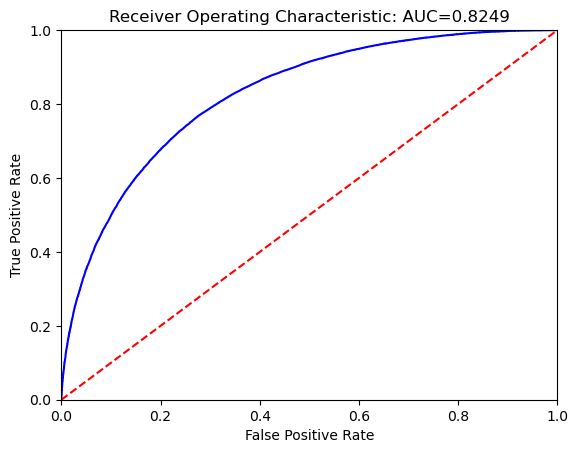

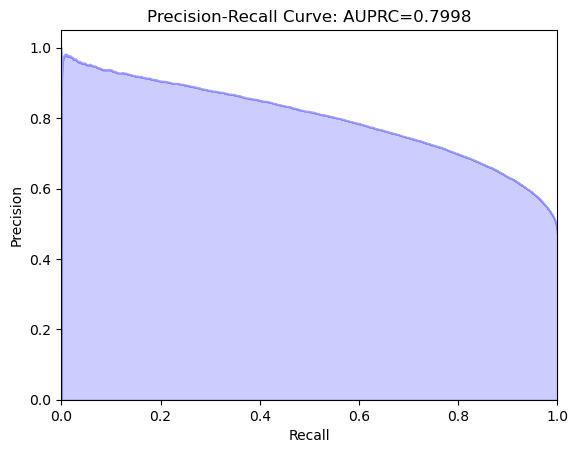

In [290]:
print("MLP:")
probs = mlp_tuned.predict(X_test_array)
result = PlotROCCurve(probs,y_test_array, ci=confidence_interval, random_seed=random_seed)
results = ["MLP_tuned_with_no_scaling"]
results.extend(result)
results.append(runtime)
result_list_mlp.append(results)

In [291]:
# Save model
model.save('hospitalization_triage_mlp.h5')

(vi) Performance Output for tuned model

In [292]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list_mlp, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]

# Save table to Excel
formatted_result_df.to_csv(os.path.join(path, 'mlp_table.csv'), index=False)

# Print the table
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,MLP_without_scaling,0.520,0.825 (0.823-0.826),0.8 (0.796-0.804),0.759 (0.751-0.763),0.731 (0.726-0.74),815.225
1,MLP_with_minmax_scaling,0.460,0.816 (0.813-0.818),0.787 (0.782-0.791),0.747 (0.737-0.757),0.734 (0.723-0.739),749.615
2,MLP_with_robust_scaling,0.467,0.816 (0.813-0.818),0.788 (0.783-0.792),0.752 (0.735-0.755),0.726 (0.72-0.741),816.293
3,MLP_with_standard_scaling,0.440,0.817 (0.814-0.819),0.789 (0.784-0.793),0.742 (0.732-0.749),0.735 (0.729-0.742),750.368
4,MLP_tuned_with_no_scaling,0.526,0.825 (0.822-0.826),0.8 (0.796-0.804),0.752 (0.744-0.765),0.739 (0.729-0.747),182.499


(vii) Important features (using Shap to approximate)

In [294]:
import shap

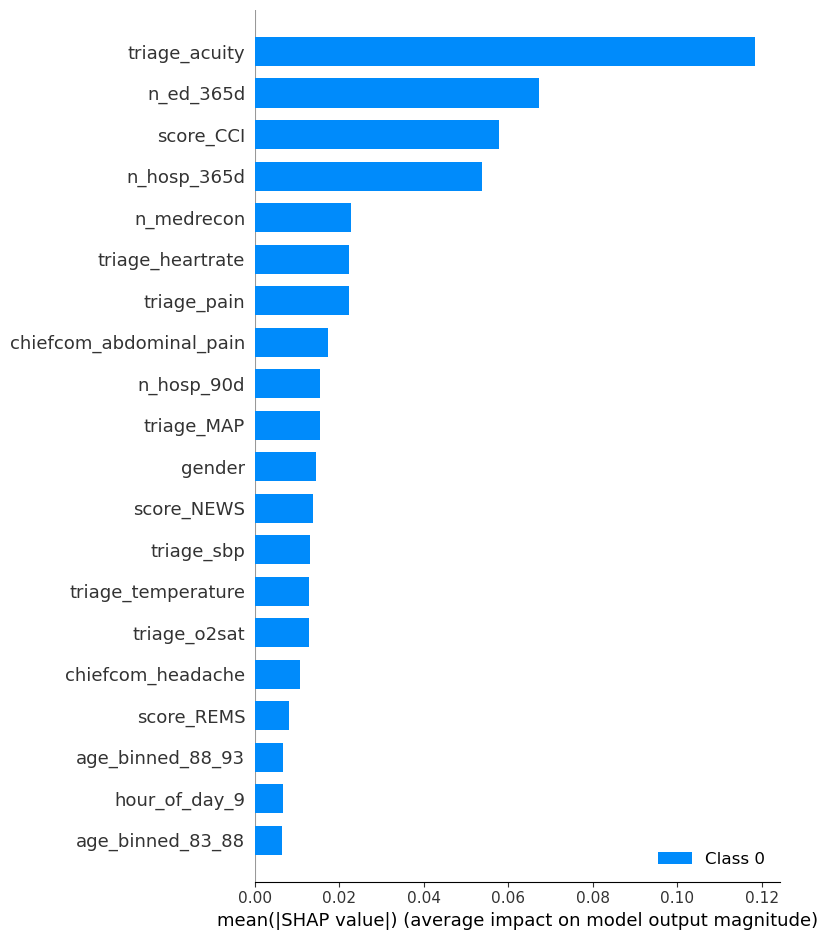

In [297]:
# Create a stratified background dataset to create a representative distribution of feature values in the test dataset
stratified_background_indices = []
for class_label in np.unique(y_train_array):
    class_indices = np.where(y_train_array == class_label)[0]
    num_samples = len(background_indices) // len(np.unique(y_train_array))
    sampled_indices = np.random.choice(class_indices, size=num_samples, replace=True)
    stratified_background_indices.extend(sampled_indices)

# Convert to numpy array
stratified_background_indices = np.array(stratified_background_indices)

# Combine the initial background indices with the stratified background indices
combined_background_indices = np.concatenate((background_indices, stratified_background_indices))

# Ensure the combined background dataset doesn't exceed the size of the training dataset
combined_background_indices = combined_background_indices[:len(X_train_array)]

# Use the combined background indices to create the final background dataset
combined_background = X_train_array[combined_background_indices]

# Create the DeepExplainer with the final background dataset
explainer = shap.DeepExplainer(mlp_tuned, combined_background)

# Generate SHAP values for the test set
shap_values = explainer.shap_values(X_test_array)

# Plot the SHAP values
shap.summary_plot(shap_values, X_test_array, feature_names=feature_names, plot_type='bar')


### Experimenting with PyCaret (AutoML)
To find a better performing alogrithm for the prediction task

In [32]:
import catboost

In [33]:
# check installed version
import pycaret
pycaret.__version__

'3.0.4'

In [34]:
# Concatenate the dataframes vertically
data = pd.concat([df_train, df_test], axis=0)

# Reset the index
data.reset_index(drop=True, inplace=True)

data.shape

(440144, 88)

In [35]:
# import pycaret classification and init setup
from pycaret.classification import *

start = time.time()
s = setup(data, target = 'outcome_hospitalization', session_id = 123, categorical_features = ['age_binned','day_of_week','hour_of_day'],
         fold=5,train_size=0.8)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')

,Description,Value
0,Session id,123
1,Target,outcome_hospitalization
2,Target type,Binary
3,Original data shape,"(440144, 88)"
4,Transformed data shape,"(440144, 133)"
5,Transformed train set shape,"(352115, 133)"
6,Transformed test set shape,"(88029, 133)"
7,Numeric features,84
8,Categorical features,3
9,Preprocess,True


Training time: 1948.0137825012207 seconds


In [37]:
print("No of classifiers:",len(models()))
models()

No of classifiers: 19


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


Define customised model evaluation metrics using measures that are the same for the LR, RF, GB and MLP to ensure that model performance are all quantified on the same basis.

In [123]:
# Define metric to evaluate model performance
def custom_threshold(y_true, y_pred_probs):
    fpr, tpr, threshold = roc_curve(y_true,y_pred_probs)
    a=np.sqrt(np.square(fpr-0)+np.square(tpr-1)).argmin()
    threshold = threshold[a]
    
    return threshold

# Add the Threshold metric to PyCaret
add_metric('custom_threshold', 'Custom Threshold', custom_threshold, target='pred_proba')

Name                                                  Custom Threshold
Display Name                                          Custom Threshold
Score Function       <function custom_threshold at 0x000001D7977B6B80>
Scorer               make_scorer(custom_threshold, needs_proba=True...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: custom_threshold, dtype: object

In [124]:
def custom_AUROC(y_true, y_pred_probs):
    fpr, tpr, threshold = roc_curve(y_true,y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    return roc_auc

# Add the AUROC metric to PyCaret
add_metric('custom_AUROC', 'Custom AUROC', custom_AUROC, target='pred_proba')

Name                                                      Custom AUROC
Display Name                                              Custom AUROC
Score Function           <function custom_AUROC at 0x000001D7977B6F70>
Scorer               make_scorer(custom_AUROC, needs_proba=True, er...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: custom_AUROC, dtype: object

In [125]:
# Define metric to evaluate model performance
def custom_auprc(y_true, y_pred_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    return auc(recall, precision)

# Add the AUPRC metric to PyCaret
add_metric('custom_auprc', 'Custom AUPRC', custom_auprc, target='pred_proba')

Name                                                      Custom AUPRC
Display Name                                              Custom AUPRC
Score Function           <function custom_auprc at 0x000001D7977B6310>
Scorer               make_scorer(custom_auprc, needs_proba=True, er...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: custom_auprc, dtype: object

In [126]:
# Define metric to evaluate model performance
def custom_sensitivity(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    actual_positives = np.sum(y_true == 1)
    return true_positives / actual_positives

# Add the Sensitivity metric to PyCaret
add_metric('custom_sensitivity', 'Custom Sensitivity', custom_sensitivity)

Name                                                Custom Sensitivity
Display Name                                        Custom Sensitivity
Score Function       <function custom_sensitivity at 0x000001D7977B...
Scorer                                 make_scorer(custom_sensitivity)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: custom_sensitivity, dtype: object

In [127]:
# Define metric to evaluate model performance
def custom_specificity(y_true, y_pred):
    true_negatives = np.sum((y_true == 0) & (y_pred == 0))
    actual_negatives = np.sum(y_true == 0)
    return true_negatives / actual_negatives

# Add the Sensitivity metric to PyCaret
add_metric('custom_specificity', 'Custom Specificity', custom_specificity)

Name                                                Custom Specificity
Display Name                                        Custom Specificity
Score Function       <function custom_specificity at 0x000001D7977B...
Scorer                                 make_scorer(custom_specificity)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: custom_specificity, dtype: object

In [128]:
#
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x000001D6540B3F70>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x000001D6540BC...,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x000001D6540BC...,make_scorer(matthews_corrcoef),pred,{},True,True,False
custom_threshold,Custom Threshold,Custom Threshold,<function custom_threshold at 0x000001D7977B6B80>,"make_scorer(custom_threshold, needs_proba=True...",pred_proba,{},True,True,True
custom_AUROC,Custom AUROC,Custom AUROC,<function custom_AUROC at 0x000001D7977B6F70>,"make_scorer(custom_AUROC, needs_proba=True, er...",pred_proba,{},True,True,True


In [129]:
# compare baseline models
start = time.time()
best = compare_models(include=['mlp','lr','knn','nb','dt','svm','ridge','rf','qda','ada','gbc','lda','et','xgboost','lightgbm','catboost','dummy'],
                     sort='AUC')
runtime = time.time()-start
print('Training time:', runtime, 'seconds')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custom Threshold,Custom AUROC,Custom AUPRC,Custom Sensitivity,Custom Specificity,TT (Sec)
catboost,CatBoost Classifier,0.7512,0.8307,0.7412,0.7347,0.7379,0.5011,0.5011,0.4840,0.8307,0.8057,0.7412,0.7602,31.1040
lightgbm,Light Gradient Boosting Machine,0.7494,0.8289,0.7416,0.7317,0.7366,0.4976,0.4976,0.4844,0.8289,0.8034,0.7416,0.7563,3.3960
xgboost,Extreme Gradient Boosting,0.7485,0.8279,0.7367,0.7326,0.7347,0.4956,0.4957,0.4809,0.8279,0.8016,0.7367,0.7590,34.4360
mlp,MLP Classifier,0.7435,0.8257,0.7269,0.7320,0.7273,0.4853,0.4879,0.4709,0.8257,0.7991,0.7269,0.7583,52.0700
rf,Random Forest Classifier,0.7434,0.8195,0.7305,0.7276,0.7290,0.4853,0.4853,0.4959,0.8195,0.7894,0.7305,0.7549,23.0100
gbc,Gradient Boosting Classifier,0.7407,0.8195,0.7320,0.7229,0.7274,0.4802,0.4802,0.4813,0.8195,0.7920,0.7320,0.7485,39.4180
et,Extra Trees Classifier,0.7415,0.8170,0.7285,0.7256,0.7270,0.4816,0.4816,0.4930,0.8170,0.7848,0.7285,0.7532,37.5640
lr,Logistic Regression,0.7373,0.8152,0.6951,0.7348,0.7144,0.4716,0.4722,0.4569,0.8152,0.7838,0.6951,0.7751,23.7380
lda,Linear Discriminant Analysis,0.7365,0.8142,0.6912,0.7354,0.7126,0.4698,0.4705,0.4475,0.8142,0.7829,0.6912,0.7771,3.5740
ada,Ada Boost Classifier,0.7343,0.8128,0.7059,0.7248,0.7152,0.4663,0.4665,0.4994,0.8128,0.7830,0.7059,0.7598,12.9860


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

Training time: 2029.99325299263 seconds


The above scoring grid reflects the average cross-validated scores during training. CatBoost Classifier produces the best AUC score.

In [130]:
# predict on test set using the best model, which is the CatBoost Classifer
holdout_pred = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custom Threshold,Custom AUROC,Custom AUPRC,Custom Sensitivity,Custom Specificity
0,CatBoost Classifier,0.7547,0.8346,0.7462,0.7377,0.7419,0.5082,0.5082,0.4720,0.8346,0.8104,0.7462,0.7622


#### e. CatBoot

We will build a model using CatBoost algorithm since it shows promising results from our AutoML trial

In [140]:
# Containers for all results
result_list_cb = []

(i) Model with no scaling of numeric features

CatBoost:
Learning rate set to 0.125999
0:	learn: 0.6545341	total: 31.9ms	remaining: 31.8s
1:	learn: 0.6256229	total: 85.6ms	remaining: 42.7s
2:	learn: 0.6061369	total: 147ms	remaining: 48.8s
3:	learn: 0.5897956	total: 215ms	remaining: 53.6s
4:	learn: 0.5782460	total: 271ms	remaining: 54s
5:	learn: 0.5696749	total: 301ms	remaining: 49.8s
6:	learn: 0.5627912	total: 352ms	remaining: 49.9s
7:	learn: 0.5575039	total: 383ms	remaining: 47.5s
8:	learn: 0.5530076	total: 448ms	remaining: 49.4s
9:	learn: 0.5482191	total: 482ms	remaining: 47.7s
10:	learn: 0.5448386	total: 517ms	remaining: 46.5s
11:	learn: 0.5423548	total: 576ms	remaining: 47.4s
12:	learn: 0.5402003	total: 624ms	remaining: 47.4s
13:	learn: 0.5380055	total: 692ms	remaining: 48.7s
14:	learn: 0.5364381	total: 725ms	remaining: 47.6s
15:	learn: 0.5350052	total: 781ms	remaining: 48s
16:	learn: 0.5332761	total: 825ms	remaining: 47.7s
17:	learn: 0.5321329	total: 855ms	remaining: 46.6s
18:	learn: 0.5311103	total: 913ms	remaining: 47.2s
19:

161:	learn: 0.5027451	total: 7.52s	remaining: 38.9s
162:	learn: 0.5026642	total: 7.57s	remaining: 38.8s
163:	learn: 0.5026012	total: 7.6s	remaining: 38.7s
164:	learn: 0.5025374	total: 7.65s	remaining: 38.7s
165:	learn: 0.5024657	total: 7.67s	remaining: 38.5s
166:	learn: 0.5023783	total: 7.72s	remaining: 38.5s
167:	learn: 0.5023070	total: 7.75s	remaining: 38.4s
168:	learn: 0.5022225	total: 7.8s	remaining: 38.4s
169:	learn: 0.5021512	total: 7.87s	remaining: 38.4s
170:	learn: 0.5021043	total: 7.92s	remaining: 38.4s
171:	learn: 0.5020573	total: 7.95s	remaining: 38.3s
172:	learn: 0.5019887	total: 8.01s	remaining: 38.3s
173:	learn: 0.5019399	total: 8.08s	remaining: 38.4s
174:	learn: 0.5018753	total: 8.13s	remaining: 38.3s
175:	learn: 0.5018284	total: 8.15s	remaining: 38.2s
176:	learn: 0.5017687	total: 8.22s	remaining: 38.2s
177:	learn: 0.5017192	total: 8.3s	remaining: 38.3s
178:	learn: 0.5016666	total: 8.37s	remaining: 38.4s
179:	learn: 0.5015991	total: 8.4s	remaining: 38.3s
180:	learn: 0.50

320:	learn: 0.4949955	total: 14.7s	remaining: 31.1s
321:	learn: 0.4949388	total: 14.7s	remaining: 31.1s
322:	learn: 0.4948956	total: 14.8s	remaining: 31s
323:	learn: 0.4948611	total: 14.8s	remaining: 31s
324:	learn: 0.4948301	total: 14.9s	remaining: 30.9s
325:	learn: 0.4947905	total: 14.9s	remaining: 30.8s
326:	learn: 0.4947603	total: 14.9s	remaining: 30.8s
327:	learn: 0.4947105	total: 15s	remaining: 30.7s
328:	learn: 0.4946663	total: 15s	remaining: 30.7s
329:	learn: 0.4946258	total: 15.1s	remaining: 30.6s
330:	learn: 0.4946022	total: 15.2s	remaining: 30.6s
331:	learn: 0.4945578	total: 15.2s	remaining: 30.5s
332:	learn: 0.4945194	total: 15.2s	remaining: 30.5s
333:	learn: 0.4944774	total: 15.3s	remaining: 30.5s
334:	learn: 0.4944533	total: 15.3s	remaining: 30.4s
335:	learn: 0.4944129	total: 15.4s	remaining: 30.3s
336:	learn: 0.4943806	total: 15.4s	remaining: 30.3s
337:	learn: 0.4943424	total: 15.4s	remaining: 30.2s
338:	learn: 0.4943104	total: 15.5s	remaining: 30.2s
339:	learn: 0.494279

483:	learn: 0.4895552	total: 21.7s	remaining: 23.2s
484:	learn: 0.4895347	total: 21.8s	remaining: 23.2s
485:	learn: 0.4895168	total: 21.9s	remaining: 23.1s
486:	learn: 0.4894765	total: 21.9s	remaining: 23.1s
487:	learn: 0.4894596	total: 21.9s	remaining: 23s
488:	learn: 0.4894409	total: 22s	remaining: 23s
489:	learn: 0.4894176	total: 22s	remaining: 22.9s
490:	learn: 0.4893810	total: 22.1s	remaining: 22.9s
491:	learn: 0.4893474	total: 22.1s	remaining: 22.8s
492:	learn: 0.4893230	total: 22.1s	remaining: 22.8s
493:	learn: 0.4893022	total: 22.2s	remaining: 22.7s
494:	learn: 0.4892885	total: 22.2s	remaining: 22.6s
495:	learn: 0.4892506	total: 22.3s	remaining: 22.6s
496:	learn: 0.4892411	total: 22.3s	remaining: 22.6s
497:	learn: 0.4892146	total: 22.3s	remaining: 22.5s
498:	learn: 0.4891734	total: 22.4s	remaining: 22.4s
499:	learn: 0.4891428	total: 22.4s	remaining: 22.4s
500:	learn: 0.4891132	total: 22.4s	remaining: 22.4s
501:	learn: 0.4890762	total: 22.5s	remaining: 22.3s
502:	learn: 0.489058

642:	learn: 0.4851013	total: 28.5s	remaining: 15.8s
643:	learn: 0.4850708	total: 28.6s	remaining: 15.8s
644:	learn: 0.4850504	total: 28.6s	remaining: 15.8s
645:	learn: 0.4850226	total: 28.7s	remaining: 15.7s
646:	learn: 0.4849942	total: 28.7s	remaining: 15.7s
647:	learn: 0.4849671	total: 28.7s	remaining: 15.6s
648:	learn: 0.4849658	total: 28.8s	remaining: 15.6s
649:	learn: 0.4849451	total: 28.8s	remaining: 15.5s
650:	learn: 0.4849057	total: 28.9s	remaining: 15.5s
651:	learn: 0.4848687	total: 28.9s	remaining: 15.4s
652:	learn: 0.4848460	total: 29s	remaining: 15.4s
653:	learn: 0.4848361	total: 29s	remaining: 15.4s
654:	learn: 0.4848122	total: 29s	remaining: 15.3s
655:	learn: 0.4847832	total: 29.1s	remaining: 15.3s
656:	learn: 0.4847716	total: 29.1s	remaining: 15.2s
657:	learn: 0.4847542	total: 29.2s	remaining: 15.2s
658:	learn: 0.4847365	total: 29.3s	remaining: 15.1s
659:	learn: 0.4847005	total: 29.3s	remaining: 15.1s
660:	learn: 0.4846630	total: 29.4s	remaining: 15.1s
661:	learn: 0.4846

805:	learn: 0.4813002	total: 35.4s	remaining: 8.52s
806:	learn: 0.4812768	total: 35.4s	remaining: 8.48s
807:	learn: 0.4812465	total: 35.5s	remaining: 8.43s
808:	learn: 0.4812220	total: 35.5s	remaining: 8.38s
809:	learn: 0.4812093	total: 35.6s	remaining: 8.35s
810:	learn: 0.4811709	total: 35.6s	remaining: 8.3s
811:	learn: 0.4811377	total: 35.7s	remaining: 8.26s
812:	learn: 0.4811125	total: 35.7s	remaining: 8.21s
813:	learn: 0.4810908	total: 35.7s	remaining: 8.16s
814:	learn: 0.4810582	total: 35.7s	remaining: 8.11s
815:	learn: 0.4810463	total: 35.8s	remaining: 8.07s
816:	learn: 0.4810144	total: 35.8s	remaining: 8.03s
817:	learn: 0.4809815	total: 35.9s	remaining: 7.98s
818:	learn: 0.4809577	total: 35.9s	remaining: 7.94s
819:	learn: 0.4809353	total: 35.9s	remaining: 7.89s
820:	learn: 0.4809094	total: 36s	remaining: 7.85s
821:	learn: 0.4808817	total: 36s	remaining: 7.8s
822:	learn: 0.4808519	total: 36.1s	remaining: 7.76s
823:	learn: 0.4808518	total: 36.1s	remaining: 7.71s
824:	learn: 0.4808

964:	learn: 0.4777145	total: 42.4s	remaining: 1.54s
965:	learn: 0.4776946	total: 42.4s	remaining: 1.49s
966:	learn: 0.4776768	total: 42.5s	remaining: 1.45s
967:	learn: 0.4776457	total: 42.5s	remaining: 1.4s
968:	learn: 0.4776197	total: 42.5s	remaining: 1.36s
969:	learn: 0.4776078	total: 42.6s	remaining: 1.32s
970:	learn: 0.4775860	total: 42.6s	remaining: 1.27s
971:	learn: 0.4775704	total: 42.6s	remaining: 1.23s
972:	learn: 0.4775406	total: 42.7s	remaining: 1.18s
973:	learn: 0.4775271	total: 42.7s	remaining: 1.14s
974:	learn: 0.4775134	total: 42.8s	remaining: 1.1s
975:	learn: 0.4774965	total: 42.8s	remaining: 1.05s
976:	learn: 0.4774610	total: 42.9s	remaining: 1.01s
977:	learn: 0.4774336	total: 42.9s	remaining: 965ms
978:	learn: 0.4774333	total: 42.9s	remaining: 921ms
979:	learn: 0.4774047	total: 43s	remaining: 877ms
980:	learn: 0.4773897	total: 43s	remaining: 833ms
981:	learn: 0.4773792	total: 43.1s	remaining: 789ms
982:	learn: 0.4773612	total: 43.1s	remaining: 745ms
983:	learn: 0.4773

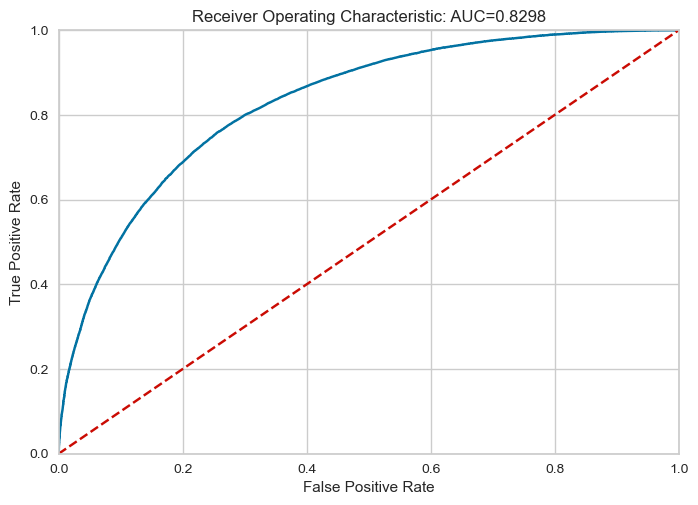

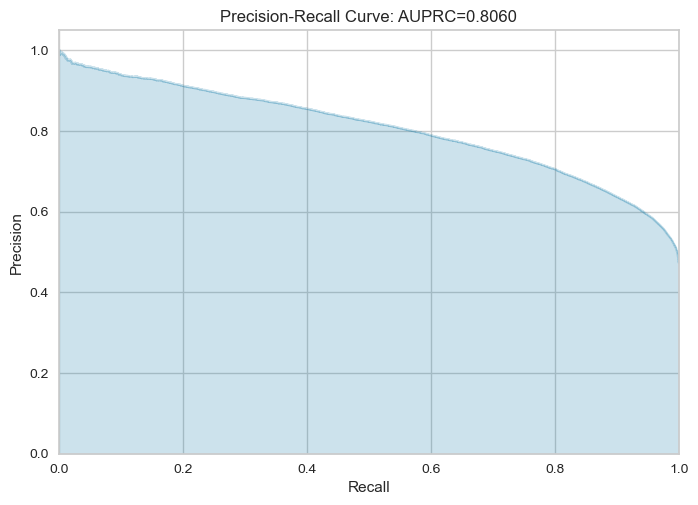

In [141]:
print("CatBoost:")

cb= CatBoostClassifier(random_state=1234)
start = time.time()
cb.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = cb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["CB_without_scaling"]
results.extend(result)
results.append(runtime)
result_list_cb.append(results)

(ii) Model with MinMax Scaling of numeric features

CatBoost:
Learning rate set to 0.125999
0:	learn: 0.6541558	total: 35.2ms	remaining: 35.1s
1:	learn: 0.6255921	total: 99.4ms	remaining: 49.6s
2:	learn: 0.6051255	total: 132ms	remaining: 43.8s
3:	learn: 0.5900835	total: 188ms	remaining: 46.7s
4:	learn: 0.5789991	total: 220ms	remaining: 43.9s
5:	learn: 0.5701690	total: 278ms	remaining: 46.1s
6:	learn: 0.5623509	total: 325ms	remaining: 46.2s
7:	learn: 0.5568108	total: 383ms	remaining: 47.5s
8:	learn: 0.5522802	total: 413ms	remaining: 45.5s
9:	learn: 0.5485191	total: 439ms	remaining: 43.4s
10:	learn: 0.5450906	total: 495ms	remaining: 44.5s
11:	learn: 0.5426416	total: 519ms	remaining: 42.8s
12:	learn: 0.5401347	total: 581ms	remaining: 44.1s
13:	learn: 0.5384262	total: 608ms	remaining: 42.8s
14:	learn: 0.5368167	total: 668ms	remaining: 43.9s
15:	learn: 0.5354122	total: 703ms	remaining: 43.2s
16:	learn: 0.5337369	total: 732ms	remaining: 42.3s
17:	learn: 0.5323064	total: 799ms	remaining: 43.6s
18:	learn: 0.5311121	total: 849ms	remaining: 43.8s

161:	learn: 0.5026771	total: 7.04s	remaining: 36.4s
162:	learn: 0.5026143	total: 7.07s	remaining: 36.3s
163:	learn: 0.5025420	total: 7.13s	remaining: 36.3s
164:	learn: 0.5024721	total: 7.19s	remaining: 36.4s
165:	learn: 0.5023944	total: 7.23s	remaining: 36.3s
166:	learn: 0.5023242	total: 7.26s	remaining: 36.2s
167:	learn: 0.5022798	total: 7.31s	remaining: 36.2s
168:	learn: 0.5022240	total: 7.34s	remaining: 36.1s
169:	learn: 0.5021461	total: 7.39s	remaining: 36.1s
170:	learn: 0.5020898	total: 7.42s	remaining: 35.9s
171:	learn: 0.5020041	total: 7.46s	remaining: 35.9s
172:	learn: 0.5019447	total: 7.5s	remaining: 35.8s
173:	learn: 0.5018808	total: 7.52s	remaining: 35.7s
174:	learn: 0.5018040	total: 7.58s	remaining: 35.7s
175:	learn: 0.5017516	total: 7.65s	remaining: 35.8s
176:	learn: 0.5016998	total: 7.68s	remaining: 35.7s
177:	learn: 0.5016259	total: 7.75s	remaining: 35.8s
178:	learn: 0.5015673	total: 7.82s	remaining: 35.9s
179:	learn: 0.5015035	total: 7.87s	remaining: 35.9s
180:	learn: 0

322:	learn: 0.4949255	total: 13.9s	remaining: 29.2s
323:	learn: 0.4948937	total: 13.9s	remaining: 29.1s
324:	learn: 0.4948505	total: 14s	remaining: 29.1s
325:	learn: 0.4948182	total: 14s	remaining: 29s
326:	learn: 0.4947847	total: 14.1s	remaining: 28.9s
327:	learn: 0.4947370	total: 14.1s	remaining: 28.9s
328:	learn: 0.4946912	total: 14.1s	remaining: 28.9s
329:	learn: 0.4946620	total: 14.2s	remaining: 28.8s
330:	learn: 0.4946195	total: 14.2s	remaining: 28.7s
331:	learn: 0.4945656	total: 14.3s	remaining: 28.7s
332:	learn: 0.4945168	total: 14.3s	remaining: 28.6s
333:	learn: 0.4944737	total: 14.4s	remaining: 28.6s
334:	learn: 0.4944396	total: 14.4s	remaining: 28.5s
335:	learn: 0.4943892	total: 14.4s	remaining: 28.5s
336:	learn: 0.4943428	total: 14.5s	remaining: 28.5s
337:	learn: 0.4942958	total: 14.5s	remaining: 28.4s
338:	learn: 0.4942693	total: 14.5s	remaining: 28.4s
339:	learn: 0.4942376	total: 14.6s	remaining: 28.3s
340:	learn: 0.4941972	total: 14.6s	remaining: 28.2s
341:	learn: 0.4941

483:	learn: 0.4894675	total: 21s	remaining: 22.4s
484:	learn: 0.4894340	total: 21.1s	remaining: 22.4s
485:	learn: 0.4894107	total: 21.2s	remaining: 22.4s
486:	learn: 0.4893980	total: 21.2s	remaining: 22.4s
487:	learn: 0.4893633	total: 21.2s	remaining: 22.3s
488:	learn: 0.4893256	total: 21.3s	remaining: 22.3s
489:	learn: 0.4893001	total: 21.4s	remaining: 22.2s
490:	learn: 0.4892559	total: 21.4s	remaining: 22.2s
491:	learn: 0.4892227	total: 21.4s	remaining: 22.1s
492:	learn: 0.4891965	total: 21.5s	remaining: 22.1s
493:	learn: 0.4891758	total: 21.5s	remaining: 22s
494:	learn: 0.4891493	total: 21.5s	remaining: 22s
495:	learn: 0.4891187	total: 21.6s	remaining: 22s
496:	learn: 0.4890801	total: 21.6s	remaining: 21.9s
497:	learn: 0.4890526	total: 21.7s	remaining: 21.9s
498:	learn: 0.4890358	total: 21.8s	remaining: 21.9s
499:	learn: 0.4890129	total: 21.8s	remaining: 21.8s
500:	learn: 0.4889906	total: 21.8s	remaining: 21.8s
501:	learn: 0.4889458	total: 21.9s	remaining: 21.7s
502:	learn: 0.488926

644:	learn: 0.4851296	total: 28s	remaining: 15.4s
645:	learn: 0.4851000	total: 28s	remaining: 15.4s
646:	learn: 0.4850782	total: 28.1s	remaining: 15.3s
647:	learn: 0.4850729	total: 28.2s	remaining: 15.3s
648:	learn: 0.4850495	total: 28.2s	remaining: 15.3s
649:	learn: 0.4850179	total: 28.3s	remaining: 15.2s
650:	learn: 0.4849886	total: 28.3s	remaining: 15.2s
651:	learn: 0.4849628	total: 28.3s	remaining: 15.1s
652:	learn: 0.4849464	total: 28.3s	remaining: 15.1s
653:	learn: 0.4849162	total: 28.4s	remaining: 15s
654:	learn: 0.4848991	total: 28.4s	remaining: 15s
655:	learn: 0.4848609	total: 28.5s	remaining: 14.9s
656:	learn: 0.4848397	total: 28.5s	remaining: 14.9s
657:	learn: 0.4848144	total: 28.6s	remaining: 14.8s
658:	learn: 0.4847819	total: 28.6s	remaining: 14.8s
659:	learn: 0.4847435	total: 28.6s	remaining: 14.8s
660:	learn: 0.4847092	total: 28.7s	remaining: 14.7s
661:	learn: 0.4846674	total: 28.7s	remaining: 14.7s
662:	learn: 0.4846291	total: 28.8s	remaining: 14.6s
663:	learn: 0.484599

805:	learn: 0.4811767	total: 35s	remaining: 8.43s
806:	learn: 0.4811568	total: 35.1s	remaining: 8.39s
807:	learn: 0.4811344	total: 35.1s	remaining: 8.35s
808:	learn: 0.4811191	total: 35.2s	remaining: 8.3s
809:	learn: 0.4810798	total: 35.2s	remaining: 8.26s
810:	learn: 0.4810575	total: 35.3s	remaining: 8.22s
811:	learn: 0.4810323	total: 35.3s	remaining: 8.18s
812:	learn: 0.4810089	total: 35.4s	remaining: 8.14s
813:	learn: 0.4809867	total: 35.4s	remaining: 8.09s
814:	learn: 0.4809657	total: 35.5s	remaining: 8.05s
815:	learn: 0.4809386	total: 35.5s	remaining: 8s
816:	learn: 0.4809200	total: 35.6s	remaining: 7.97s
817:	learn: 0.4809031	total: 35.6s	remaining: 7.92s
818:	learn: 0.4808713	total: 35.7s	remaining: 7.88s
819:	learn: 0.4808478	total: 35.7s	remaining: 7.84s
820:	learn: 0.4808254	total: 35.8s	remaining: 7.81s
821:	learn: 0.4807945	total: 35.8s	remaining: 7.76s
822:	learn: 0.4807876	total: 35.9s	remaining: 7.72s
823:	learn: 0.4807802	total: 35.9s	remaining: 7.68s
824:	learn: 0.4807

965:	learn: 0.4775943	total: 42.1s	remaining: 1.48s
966:	learn: 0.4775761	total: 42.1s	remaining: 1.44s
967:	learn: 0.4775494	total: 42.2s	remaining: 1.39s
968:	learn: 0.4775337	total: 42.2s	remaining: 1.35s
969:	learn: 0.4775264	total: 42.3s	remaining: 1.31s
970:	learn: 0.4775034	total: 42.3s	remaining: 1.26s
971:	learn: 0.4774849	total: 42.4s	remaining: 1.22s
972:	learn: 0.4774524	total: 42.4s	remaining: 1.18s
973:	learn: 0.4774338	total: 42.5s	remaining: 1.13s
974:	learn: 0.4774105	total: 42.5s	remaining: 1.09s
975:	learn: 0.4773818	total: 42.6s	remaining: 1.05s
976:	learn: 0.4773614	total: 42.6s	remaining: 1s
977:	learn: 0.4773483	total: 42.6s	remaining: 959ms
978:	learn: 0.4773162	total: 42.7s	remaining: 915ms
979:	learn: 0.4773155	total: 42.7s	remaining: 872ms
980:	learn: 0.4772986	total: 42.8s	remaining: 829ms
981:	learn: 0.4772638	total: 42.8s	remaining: 785ms
982:	learn: 0.4772423	total: 42.9s	remaining: 741ms
983:	learn: 0.4772205	total: 42.9s	remaining: 698ms
984:	learn: 0.4

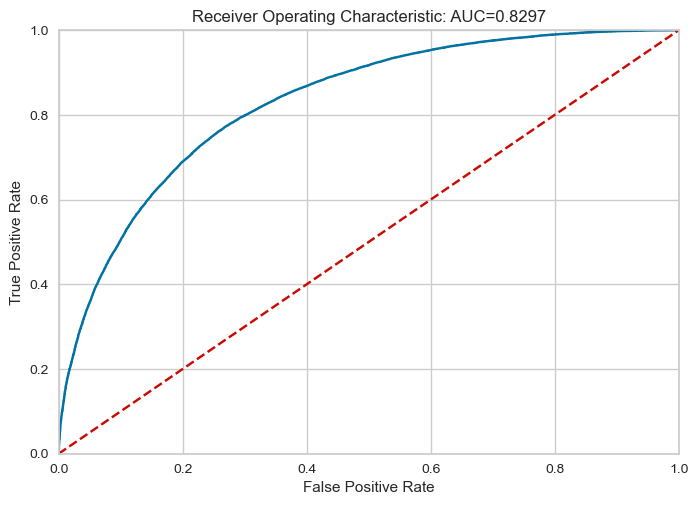

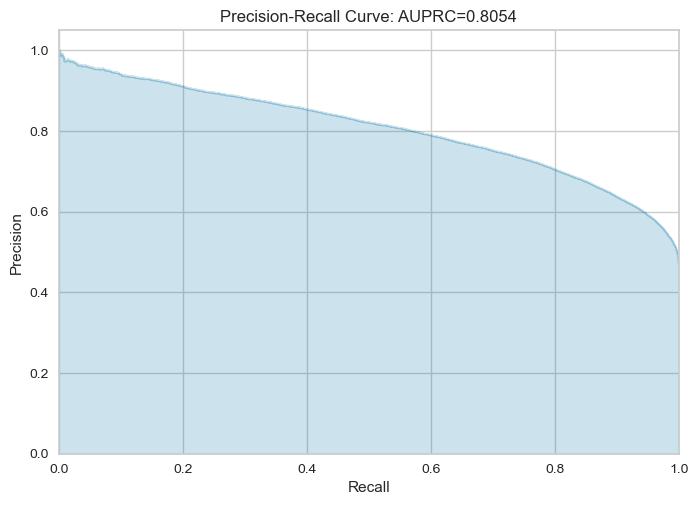

In [142]:
print("CatBoost:")

cb= CatBoostClassifier(random_state=1234)
start = time.time()
cb.fit(X_train_minmax,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = cb.predict_proba(X_test_minmax)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["CB_with_minmax_scaling"]
results.extend(result)
results.append(runtime)
result_list_cb.append(results)

(iii) Model with Robust Scaling of numeric features

CatBoost:
Learning rate set to 0.125999
0:	learn: 0.6541558	total: 40.5ms	remaining: 40.5s
1:	learn: 0.6255921	total: 90.7ms	remaining: 45.2s
2:	learn: 0.6051255	total: 149ms	remaining: 49.5s
3:	learn: 0.5900835	total: 205ms	remaining: 51.1s
4:	learn: 0.5789991	total: 291ms	remaining: 57.8s
5:	learn: 0.5701690	total: 338ms	remaining: 55.9s
6:	learn: 0.5623509	total: 390ms	remaining: 55.3s
7:	learn: 0.5568108	total: 461ms	remaining: 57.2s
8:	learn: 0.5522802	total: 498ms	remaining: 54.9s
9:	learn: 0.5485549	total: 553ms	remaining: 54.8s
10:	learn: 0.5451264	total: 630ms	remaining: 56.6s
11:	learn: 0.5426676	total: 692ms	remaining: 57s
12:	learn: 0.5400778	total: 737ms	remaining: 56s
13:	learn: 0.5380735	total: 768ms	remaining: 54.1s
14:	learn: 0.5361066	total: 825ms	remaining: 54.2s
15:	learn: 0.5346045	total: 860ms	remaining: 52.9s
16:	learn: 0.5332999	total: 932ms	remaining: 53.9s
17:	learn: 0.5321281	total: 1s	remaining: 54.8s
18:	learn: 0.5311236	total: 1.07s	remaining: 55.1s
19:	le

164:	learn: 0.5026436	total: 8.31s	remaining: 42s
165:	learn: 0.5025720	total: 8.36s	remaining: 42s
166:	learn: 0.5024993	total: 8.43s	remaining: 42.1s
167:	learn: 0.5024392	total: 8.49s	remaining: 42.1s
168:	learn: 0.5023784	total: 8.52s	remaining: 41.9s
169:	learn: 0.5023225	total: 8.55s	remaining: 41.8s
170:	learn: 0.5022616	total: 8.61s	remaining: 41.7s
171:	learn: 0.5022021	total: 8.66s	remaining: 41.7s
172:	learn: 0.5021450	total: 8.69s	remaining: 41.5s
173:	learn: 0.5020995	total: 8.74s	remaining: 41.5s
174:	learn: 0.5020430	total: 8.77s	remaining: 41.3s
175:	learn: 0.5019536	total: 8.8s	remaining: 41.2s
176:	learn: 0.5019110	total: 8.85s	remaining: 41.1s
177:	learn: 0.5018519	total: 8.88s	remaining: 41s
178:	learn: 0.5017595	total: 8.9s	remaining: 40.8s
179:	learn: 0.5016951	total: 8.94s	remaining: 40.7s
180:	learn: 0.5016418	total: 9s	remaining: 40.7s
181:	learn: 0.5015888	total: 9.03s	remaining: 40.6s
182:	learn: 0.5015349	total: 9.06s	remaining: 40.4s
183:	learn: 0.5014627	t

323:	learn: 0.4948707	total: 15.8s	remaining: 32.9s
324:	learn: 0.4948326	total: 15.8s	remaining: 32.9s
325:	learn: 0.4948019	total: 15.9s	remaining: 32.8s
326:	learn: 0.4947785	total: 16s	remaining: 32.9s
327:	learn: 0.4947444	total: 16s	remaining: 32.8s
328:	learn: 0.4947046	total: 16s	remaining: 32.7s
329:	learn: 0.4946768	total: 16.1s	remaining: 32.7s
330:	learn: 0.4946415	total: 16.2s	remaining: 32.7s
331:	learn: 0.4945969	total: 16.2s	remaining: 32.6s
332:	learn: 0.4945488	total: 16.2s	remaining: 32.5s
333:	learn: 0.4945102	total: 16.3s	remaining: 32.4s
334:	learn: 0.4944758	total: 16.3s	remaining: 32.4s
335:	learn: 0.4944317	total: 16.4s	remaining: 32.4s
336:	learn: 0.4944030	total: 16.4s	remaining: 32.3s
337:	learn: 0.4943773	total: 16.4s	remaining: 32.2s
338:	learn: 0.4943436	total: 16.5s	remaining: 32.1s
339:	learn: 0.4943160	total: 16.5s	remaining: 32.1s
340:	learn: 0.4942666	total: 16.6s	remaining: 32s
341:	learn: 0.4942383	total: 16.6s	remaining: 32s
342:	learn: 0.4942194	

487:	learn: 0.4893376	total: 23.4s	remaining: 24.6s
488:	learn: 0.4893236	total: 23.5s	remaining: 24.5s
489:	learn: 0.4893062	total: 23.5s	remaining: 24.5s
490:	learn: 0.4892687	total: 23.6s	remaining: 24.4s
491:	learn: 0.4892442	total: 23.6s	remaining: 24.4s
492:	learn: 0.4892012	total: 23.7s	remaining: 24.3s
493:	learn: 0.4891714	total: 23.7s	remaining: 24.3s
494:	learn: 0.4891572	total: 23.8s	remaining: 24.2s
495:	learn: 0.4891340	total: 23.8s	remaining: 24.2s
496:	learn: 0.4891204	total: 23.8s	remaining: 24.1s
497:	learn: 0.4890955	total: 23.9s	remaining: 24.1s
498:	learn: 0.4890574	total: 23.9s	remaining: 24s
499:	learn: 0.4890172	total: 24s	remaining: 24s
500:	learn: 0.4890052	total: 24s	remaining: 23.9s
501:	learn: 0.4889863	total: 24s	remaining: 23.9s
502:	learn: 0.4889500	total: 24.1s	remaining: 23.8s
503:	learn: 0.4889320	total: 24.1s	remaining: 23.7s
504:	learn: 0.4889129	total: 24.2s	remaining: 23.7s
505:	learn: 0.4888906	total: 24.3s	remaining: 23.7s
506:	learn: 0.4888769	

651:	learn: 0.4848868	total: 31.1s	remaining: 16.6s
652:	learn: 0.4848673	total: 31.2s	remaining: 16.6s
653:	learn: 0.4848539	total: 31.2s	remaining: 16.5s
654:	learn: 0.4848207	total: 31.3s	remaining: 16.5s
655:	learn: 0.4847909	total: 31.4s	remaining: 16.4s
656:	learn: 0.4847766	total: 31.4s	remaining: 16.4s
657:	learn: 0.4847449	total: 31.5s	remaining: 16.3s
658:	learn: 0.4847161	total: 31.5s	remaining: 16.3s
659:	learn: 0.4847072	total: 31.5s	remaining: 16.2s
660:	learn: 0.4846735	total: 31.6s	remaining: 16.2s
661:	learn: 0.4846340	total: 31.6s	remaining: 16.2s
662:	learn: 0.4846105	total: 31.7s	remaining: 16.1s
663:	learn: 0.4845885	total: 31.7s	remaining: 16s
664:	learn: 0.4845872	total: 31.8s	remaining: 16s
665:	learn: 0.4845499	total: 31.8s	remaining: 16s
666:	learn: 0.4845327	total: 31.9s	remaining: 15.9s
667:	learn: 0.4845090	total: 31.9s	remaining: 15.9s
668:	learn: 0.4844857	total: 32s	remaining: 15.8s
669:	learn: 0.4844551	total: 32s	remaining: 15.8s
670:	learn: 0.4844328	

810:	learn: 0.4809201	total: 38.2s	remaining: 8.91s
811:	learn: 0.4809006	total: 38.3s	remaining: 8.86s
812:	learn: 0.4808798	total: 38.3s	remaining: 8.8s
813:	learn: 0.4808665	total: 38.3s	remaining: 8.76s
814:	learn: 0.4808474	total: 38.4s	remaining: 8.71s
815:	learn: 0.4808121	total: 38.4s	remaining: 8.66s
816:	learn: 0.4807760	total: 38.4s	remaining: 8.61s
817:	learn: 0.4807437	total: 38.5s	remaining: 8.56s
818:	learn: 0.4807249	total: 38.5s	remaining: 8.51s
819:	learn: 0.4807127	total: 38.5s	remaining: 8.46s
820:	learn: 0.4806760	total: 38.6s	remaining: 8.42s
821:	learn: 0.4806503	total: 38.6s	remaining: 8.37s
822:	learn: 0.4806331	total: 38.7s	remaining: 8.32s
823:	learn: 0.4806124	total: 38.7s	remaining: 8.27s
824:	learn: 0.4805804	total: 38.8s	remaining: 8.22s
825:	learn: 0.4805472	total: 38.8s	remaining: 8.18s
826:	learn: 0.4805203	total: 38.9s	remaining: 8.14s
827:	learn: 0.4805048	total: 38.9s	remaining: 8.09s
828:	learn: 0.4804791	total: 39s	remaining: 8.04s
829:	learn: 0.4

972:	learn: 0.4773081	total: 45.7s	remaining: 1.27s
973:	learn: 0.4772891	total: 45.7s	remaining: 1.22s
974:	learn: 0.4772690	total: 45.7s	remaining: 1.17s
975:	learn: 0.4772504	total: 45.7s	remaining: 1.12s
976:	learn: 0.4772353	total: 45.8s	remaining: 1.08s
977:	learn: 0.4772040	total: 45.8s	remaining: 1.03s
978:	learn: 0.4771833	total: 45.9s	remaining: 984ms
979:	learn: 0.4771688	total: 45.9s	remaining: 936ms
980:	learn: 0.4771551	total: 45.9s	remaining: 890ms
981:	learn: 0.4771228	total: 46s	remaining: 843ms
982:	learn: 0.4771062	total: 46s	remaining: 796ms
983:	learn: 0.4770901	total: 46s	remaining: 749ms
984:	learn: 0.4770673	total: 46.1s	remaining: 702ms
985:	learn: 0.4770515	total: 46.1s	remaining: 655ms
986:	learn: 0.4770427	total: 46.1s	remaining: 608ms
987:	learn: 0.4770245	total: 46.2s	remaining: 561ms
988:	learn: 0.4770136	total: 46.2s	remaining: 514ms
989:	learn: 0.4769810	total: 46.2s	remaining: 467ms
990:	learn: 0.4769605	total: 46.3s	remaining: 421ms
991:	learn: 0.4769

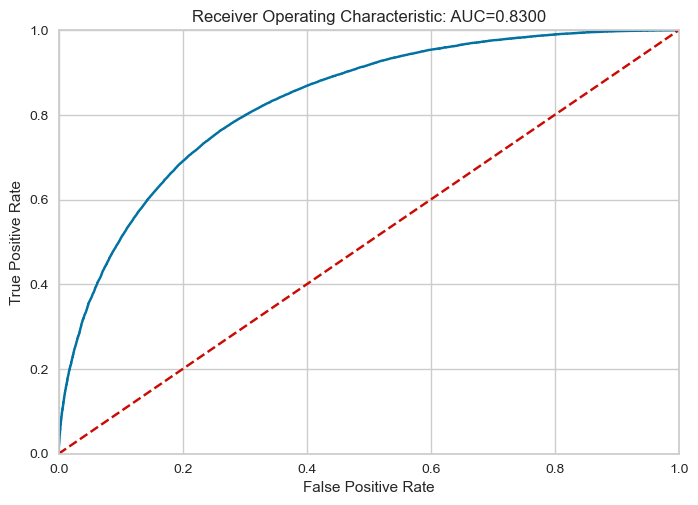

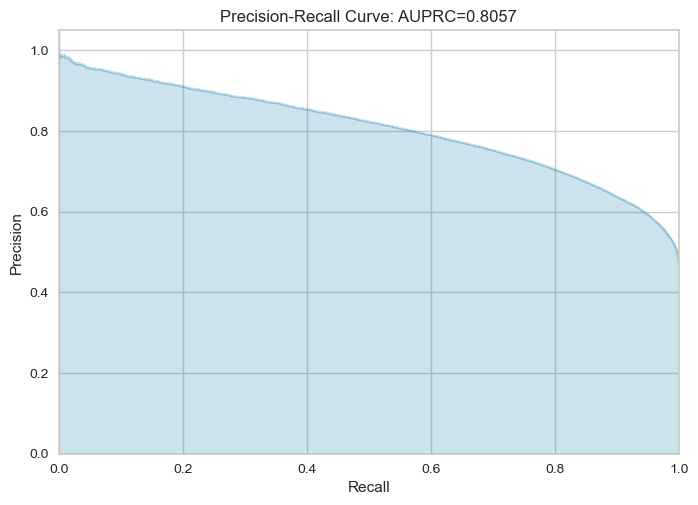

In [143]:
print("CatBoost:")

cb= CatBoostClassifier(random_state=1234)
start = time.time()
cb.fit(X_train_robust,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = cb.predict_proba(X_test_robust)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["CB_with_robust_scaling"]
results.extend(result)
results.append(runtime)
result_list_cb.append(results)

(iv) Model with Standard Scaling of numeric features

CatBoost:
Learning rate set to 0.125999
0:	learn: 0.6541558	total: 45.4ms	remaining: 45.4s
1:	learn: 0.6255921	total: 103ms	remaining: 51.1s
2:	learn: 0.6051255	total: 131ms	remaining: 43.4s
3:	learn: 0.5900835	total: 182ms	remaining: 45.3s
4:	learn: 0.5789991	total: 234ms	remaining: 46.5s
5:	learn: 0.5701690	total: 291ms	remaining: 48.3s
6:	learn: 0.5623509	total: 319ms	remaining: 45.3s
7:	learn: 0.5568108	total: 353ms	remaining: 43.8s
8:	learn: 0.5522802	total: 404ms	remaining: 44.4s
9:	learn: 0.5485191	total: 440ms	remaining: 43.6s
10:	learn: 0.5450906	total: 497ms	remaining: 44.7s
11:	learn: 0.5426416	total: 553ms	remaining: 45.5s
12:	learn: 0.5401347	total: 621ms	remaining: 47.1s
13:	learn: 0.5384262	total: 657ms	remaining: 46.3s
14:	learn: 0.5368167	total: 689ms	remaining: 45.3s
15:	learn: 0.5354122	total: 741ms	remaining: 45.5s
16:	learn: 0.5337369	total: 792ms	remaining: 45.8s
17:	learn: 0.5323064	total: 818ms	remaining: 44.6s
18:	learn: 0.5311121	total: 879ms	remaining: 45.4s


162:	learn: 0.5026143	total: 7.08s	remaining: 36.3s
163:	learn: 0.5025420	total: 7.11s	remaining: 36.2s
164:	learn: 0.5024721	total: 7.13s	remaining: 36.1s
165:	learn: 0.5023944	total: 7.16s	remaining: 36s
166:	learn: 0.5023242	total: 7.23s	remaining: 36.1s
167:	learn: 0.5022798	total: 7.27s	remaining: 36s
168:	learn: 0.5022240	total: 7.31s	remaining: 35.9s
169:	learn: 0.5021461	total: 7.36s	remaining: 35.9s
170:	learn: 0.5020898	total: 7.42s	remaining: 36s
171:	learn: 0.5020041	total: 7.49s	remaining: 36s
172:	learn: 0.5019447	total: 7.55s	remaining: 36.1s
173:	learn: 0.5018808	total: 7.58s	remaining: 36s
174:	learn: 0.5018040	total: 7.61s	remaining: 35.9s
175:	learn: 0.5017516	total: 7.67s	remaining: 35.9s
176:	learn: 0.5016998	total: 7.7s	remaining: 35.8s
177:	learn: 0.5016259	total: 7.75s	remaining: 35.8s
178:	learn: 0.5015673	total: 7.83s	remaining: 35.9s
179:	learn: 0.5015035	total: 7.88s	remaining: 35.9s
180:	learn: 0.5014221	total: 7.9s	remaining: 35.8s
181:	learn: 0.5013656	to

324:	learn: 0.4948505	total: 14s	remaining: 29.1s
325:	learn: 0.4948183	total: 14s	remaining: 29s
326:	learn: 0.4947848	total: 14.1s	remaining: 29s
327:	learn: 0.4947370	total: 14.1s	remaining: 28.9s
328:	learn: 0.4946912	total: 14.2s	remaining: 28.9s
329:	learn: 0.4946619	total: 14.2s	remaining: 28.9s
330:	learn: 0.4946195	total: 14.3s	remaining: 28.8s
331:	learn: 0.4945656	total: 14.3s	remaining: 28.8s
332:	learn: 0.4945168	total: 14.4s	remaining: 28.8s
333:	learn: 0.4944737	total: 14.4s	remaining: 28.7s
334:	learn: 0.4944396	total: 14.5s	remaining: 28.7s
335:	learn: 0.4943892	total: 14.5s	remaining: 28.6s
336:	learn: 0.4943427	total: 14.5s	remaining: 28.6s
337:	learn: 0.4942958	total: 14.5s	remaining: 28.5s
338:	learn: 0.4942693	total: 14.6s	remaining: 28.5s
339:	learn: 0.4942376	total: 14.7s	remaining: 28.5s
340:	learn: 0.4941972	total: 14.7s	remaining: 28.5s
341:	learn: 0.4941637	total: 14.8s	remaining: 28.4s
342:	learn: 0.4941324	total: 14.8s	remaining: 28.4s
343:	learn: 0.494103

486:	learn: 0.4895993	total: 21.3s	remaining: 22.4s
487:	learn: 0.4895724	total: 21.4s	remaining: 22.4s
488:	learn: 0.4895496	total: 21.4s	remaining: 22.4s
489:	learn: 0.4895123	total: 21.4s	remaining: 22.3s
490:	learn: 0.4894749	total: 21.5s	remaining: 22.3s
491:	learn: 0.4894317	total: 21.5s	remaining: 22.2s
492:	learn: 0.4894003	total: 21.6s	remaining: 22.2s
493:	learn: 0.4893689	total: 21.6s	remaining: 22.2s
494:	learn: 0.4893326	total: 21.7s	remaining: 22.1s
495:	learn: 0.4892844	total: 21.7s	remaining: 22.1s
496:	learn: 0.4892464	total: 21.8s	remaining: 22s
497:	learn: 0.4892264	total: 21.8s	remaining: 22s
498:	learn: 0.4891962	total: 21.8s	remaining: 21.9s
499:	learn: 0.4891684	total: 21.9s	remaining: 21.9s
500:	learn: 0.4891395	total: 21.9s	remaining: 21.8s
501:	learn: 0.4891176	total: 22s	remaining: 21.8s
502:	learn: 0.4890875	total: 22s	remaining: 21.7s
503:	learn: 0.4890731	total: 22s	remaining: 21.7s
504:	learn: 0.4890306	total: 22.1s	remaining: 21.6s
505:	learn: 0.4889912	

649:	learn: 0.4849998	total: 28.5s	remaining: 15.3s
650:	learn: 0.4849809	total: 28.5s	remaining: 15.3s
651:	learn: 0.4849526	total: 28.5s	remaining: 15.2s
652:	learn: 0.4849291	total: 28.6s	remaining: 15.2s
653:	learn: 0.4848915	total: 28.6s	remaining: 15.2s
654:	learn: 0.4848605	total: 28.7s	remaining: 15.1s
655:	learn: 0.4848209	total: 28.7s	remaining: 15.1s
656:	learn: 0.4847993	total: 28.8s	remaining: 15s
657:	learn: 0.4847599	total: 28.9s	remaining: 15s
658:	learn: 0.4847304	total: 28.9s	remaining: 15s
659:	learn: 0.4847093	total: 29s	remaining: 14.9s
660:	learn: 0.4846767	total: 29s	remaining: 14.9s
661:	learn: 0.4846427	total: 29.1s	remaining: 14.8s
662:	learn: 0.4846265	total: 29.1s	remaining: 14.8s
663:	learn: 0.4845928	total: 29.1s	remaining: 14.7s
664:	learn: 0.4845650	total: 29.2s	remaining: 14.7s
665:	learn: 0.4845457	total: 29.2s	remaining: 14.6s
666:	learn: 0.4845278	total: 29.3s	remaining: 14.6s
667:	learn: 0.4844920	total: 29.3s	remaining: 14.6s
668:	learn: 0.4844563	

812:	learn: 0.4811003	total: 35.9s	remaining: 8.26s
813:	learn: 0.4810768	total: 35.9s	remaining: 8.21s
814:	learn: 0.4810480	total: 36s	remaining: 8.17s
815:	learn: 0.4810285	total: 36s	remaining: 8.12s
816:	learn: 0.4810283	total: 36.1s	remaining: 8.08s
817:	learn: 0.4810019	total: 36.2s	remaining: 8.04s
818:	learn: 0.4809698	total: 36.2s	remaining: 8s
819:	learn: 0.4809571	total: 36.2s	remaining: 7.95s
820:	learn: 0.4809569	total: 36.3s	remaining: 7.91s
821:	learn: 0.4809384	total: 36.3s	remaining: 7.86s
822:	learn: 0.4809052	total: 36.3s	remaining: 7.81s
823:	learn: 0.4808770	total: 36.4s	remaining: 7.77s
824:	learn: 0.4808610	total: 36.4s	remaining: 7.72s
825:	learn: 0.4808336	total: 36.5s	remaining: 7.68s
826:	learn: 0.4808000	total: 36.5s	remaining: 7.63s
827:	learn: 0.4807777	total: 36.5s	remaining: 7.58s
828:	learn: 0.4807435	total: 36.5s	remaining: 7.54s
829:	learn: 0.4807186	total: 36.6s	remaining: 7.49s
830:	learn: 0.4807100	total: 36.6s	remaining: 7.44s
831:	learn: 0.48068

973:	learn: 0.4776820	total: 43s	remaining: 1.15s
974:	learn: 0.4776462	total: 43s	remaining: 1.1s
975:	learn: 0.4776227	total: 43.1s	remaining: 1.06s
976:	learn: 0.4776016	total: 43.1s	remaining: 1.01s
977:	learn: 0.4775817	total: 43.2s	remaining: 972ms
978:	learn: 0.4775544	total: 43.2s	remaining: 927ms
979:	learn: 0.4775428	total: 43.3s	remaining: 883ms
980:	learn: 0.4775276	total: 43.4s	remaining: 840ms
981:	learn: 0.4775056	total: 43.4s	remaining: 796ms
982:	learn: 0.4774833	total: 43.5s	remaining: 752ms
983:	learn: 0.4774581	total: 43.5s	remaining: 707ms
984:	learn: 0.4774376	total: 43.5s	remaining: 663ms
985:	learn: 0.4774142	total: 43.6s	remaining: 619ms
986:	learn: 0.4773954	total: 43.6s	remaining: 574ms
987:	learn: 0.4773708	total: 43.6s	remaining: 530ms
988:	learn: 0.4773485	total: 43.7s	remaining: 486ms
989:	learn: 0.4773296	total: 43.7s	remaining: 442ms
990:	learn: 0.4772955	total: 43.8s	remaining: 398ms
991:	learn: 0.4772819	total: 43.9s	remaining: 354ms
992:	learn: 0.477

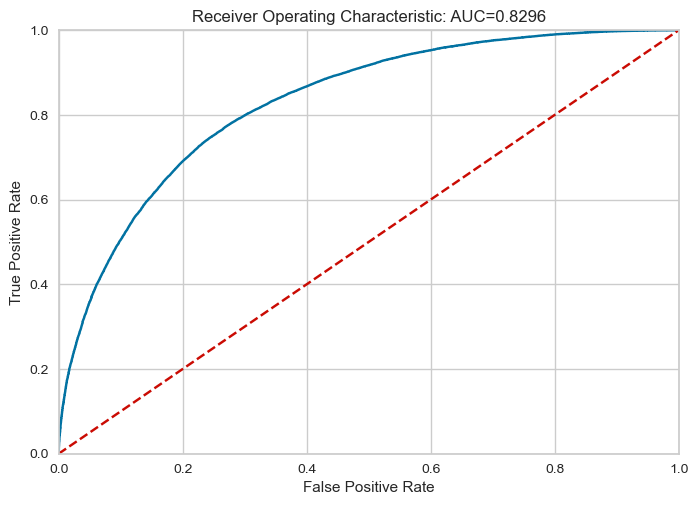

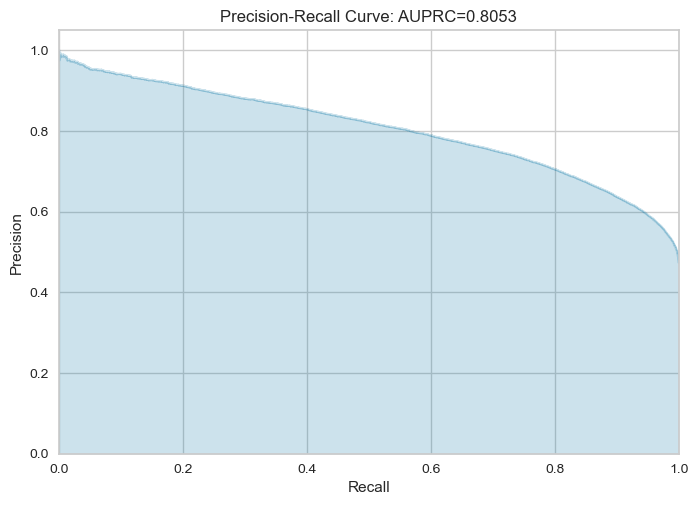

In [144]:
print("CatBoost:")

cb= CatBoostClassifier(random_state=1234)
start = time.time()
cb.fit(X_train_scaled,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = cb.predict_proba(X_test_scaled)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["CB_with_standard_scaling"]
results.extend(result)
results.append(runtime)
result_list_cb.append(results)

(v) Model Tuning using PyCaret

In [134]:
# Create a base model using Pycaret
start = time.time()
catboost = create_model('catboost')
runtime = time.time()-start
print('Training time:', runtime, 'seconds')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custom Threshold,Custom AUROC,Custom AUPRC,Custom Sensitivity,Custom Specificity
Fold,,,,,,,,,,,,
0,0.7521,0.8329,0.7411,0.7361,0.7386,0.5028,0.5028,0.4865,0.8329,0.8098,0.7411,0.7619
1,0.7484,0.8284,0.7346,0.7335,0.7340,0.4954,0.4954,0.4704,0.8284,0.8020,0.7346,0.7608
2,0.7508,0.8309,0.7400,0.7346,0.7373,0.5003,0.5003,0.4827,0.8309,0.8060,0.7400,0.7605
3,0.7533,0.8309,0.7468,0.7354,0.7410,0.5056,0.5057,0.4889,0.8309,0.8046,0.7468,0.7592
4,0.7512,0.8305,0.7433,0.7338,0.7385,0.5013,0.5014,0.4914,0.8305,0.8060,0.7433,0.7584
Mean,0.7512,0.8307,0.7412,0.7347,0.7379,0.5011,0.5011,0.4840,0.8307,0.8057,0.7412,0.7602
Std,0.0016,0.0014,0.0040,0.0010,0.0023,0.0034,0.0034,0.0074,0.0014,0.0025,0.0040,0.0012


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Training time: 207.35328722000122 seconds


In [135]:
# tune hyperparameters of dt
tuned_cb = tune_model(catboost,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custom Threshold,Custom AUROC,Custom AUPRC,Custom Sensitivity,Custom Specificity
Fold,,,,,,,,,,,,
0,0.7493,0.8297,0.7359,0.7343,0.7351,0.4972,0.4972,0.4650,0.8297,0.8045,0.7359,0.7613
1,0.7453,0.8257,0.7300,0.7307,0.7304,0.4890,0.4890,0.4746,0.8257,0.7984,0.7300,0.7589
2,0.7479,0.8284,0.7363,0.7319,0.7341,0.4944,0.4944,0.4801,0.8284,0.8025,0.7363,0.7583
3,0.7508,0.8281,0.7402,0.7345,0.7373,0.5002,0.5002,0.4851,0.8281,0.8005,0.7402,0.7602
4,0.7493,0.8282,0.7391,0.7328,0.7359,0.4974,0.4974,0.4755,0.8282,0.8028,0.7391,0.7585
Mean,0.7485,0.8280,0.7363,0.7328,0.7346,0.4956,0.4957,0.4760,0.8280,0.8018,0.7363,0.7595
Std,0.0019,0.0013,0.0035,0.0014,0.0024,0.0038,0.0038,0.0067,0.0013,0.0021,0.0035,0.0011


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [136]:
# predict on test set using the best model, which is the CatBoost Classifer
holdout_pred = predict_model(tuned_cb)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custom Threshold,Custom AUROC,Custom AUPRC,Custom Sensitivity,Custom Specificity
0,CatBoost Classifier,0.7547,0.8346,0.7462,0.7377,0.7419,0.5082,0.5082,0.4720,0.8346,0.8104,0.7462,0.7622


In [137]:
# get best_params for best classifier
tuned_cb.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 123,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.125999

(vi) Performance Output for tuned model

In [146]:
#result_df = pd.read_csv(os.path.join(path, 'result_hospitalization_triage.csv'))
result_df = pd.DataFrame(result_list_cb, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]

# Save table to Excel
formatted_result_df.to_csv(os.path.join(path, 'cb_table.csv'), index=False)

# Print the table
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,CB_without_scaling,0.483,0.83 (0.827-0.832),0.806 (0.801-0.81),0.758 (0.751-0.764),0.745 (0.74-0.753),44.382
1,CB_with_minmax_scaling,0.480,0.83 (0.827-0.831),0.805 (0.801-0.81),0.76 (0.753-0.769),0.743 (0.736-0.75),44.306
2,CB_with_robust_scaling,0.477,0.83 (0.827-0.832),0.806 (0.801-0.81),0.763 (0.75-0.765),0.739 (0.735-0.752),47.456
3,CB_with_standard_scaling,0.483,0.83 (0.827-0.831),0.805 (0.801-0.81),0.758 (0.745-0.763),0.745 (0.74-0.759),44.899


Note: The values from tuned_cb model cannot be combined automatically. Please refer to part (iv) above for the tuned results

(vii) Important features

In [138]:
# Feature importance for tuned_cb model
catboost_feature_importance = pd.DataFrame(
        {
            'features': get_config('X_train_transformed').columns,    
            'importance' : tuned_cb.feature_importances_
            })

# Save table to Excel
catboost_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False).to_csv(os.path.join(path, 'catboost_feature_impt_pycaret.csv'), index=False)

# Check top 20 features
catboost_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20]

,features,importance
17,triage_acuity,28.207255
78,score_CCI,8.122083
3,n_ed_365d,3.913776
76,n_medrecon,3.824332
16,triage_pain,3.678196
6,n_hosp_365d,3.445123
13,triage_o2sat,3.234605
10,triage_temperature,3.145463
11,triage_heartrate,3.094539
77,triage_MAP,2.306198


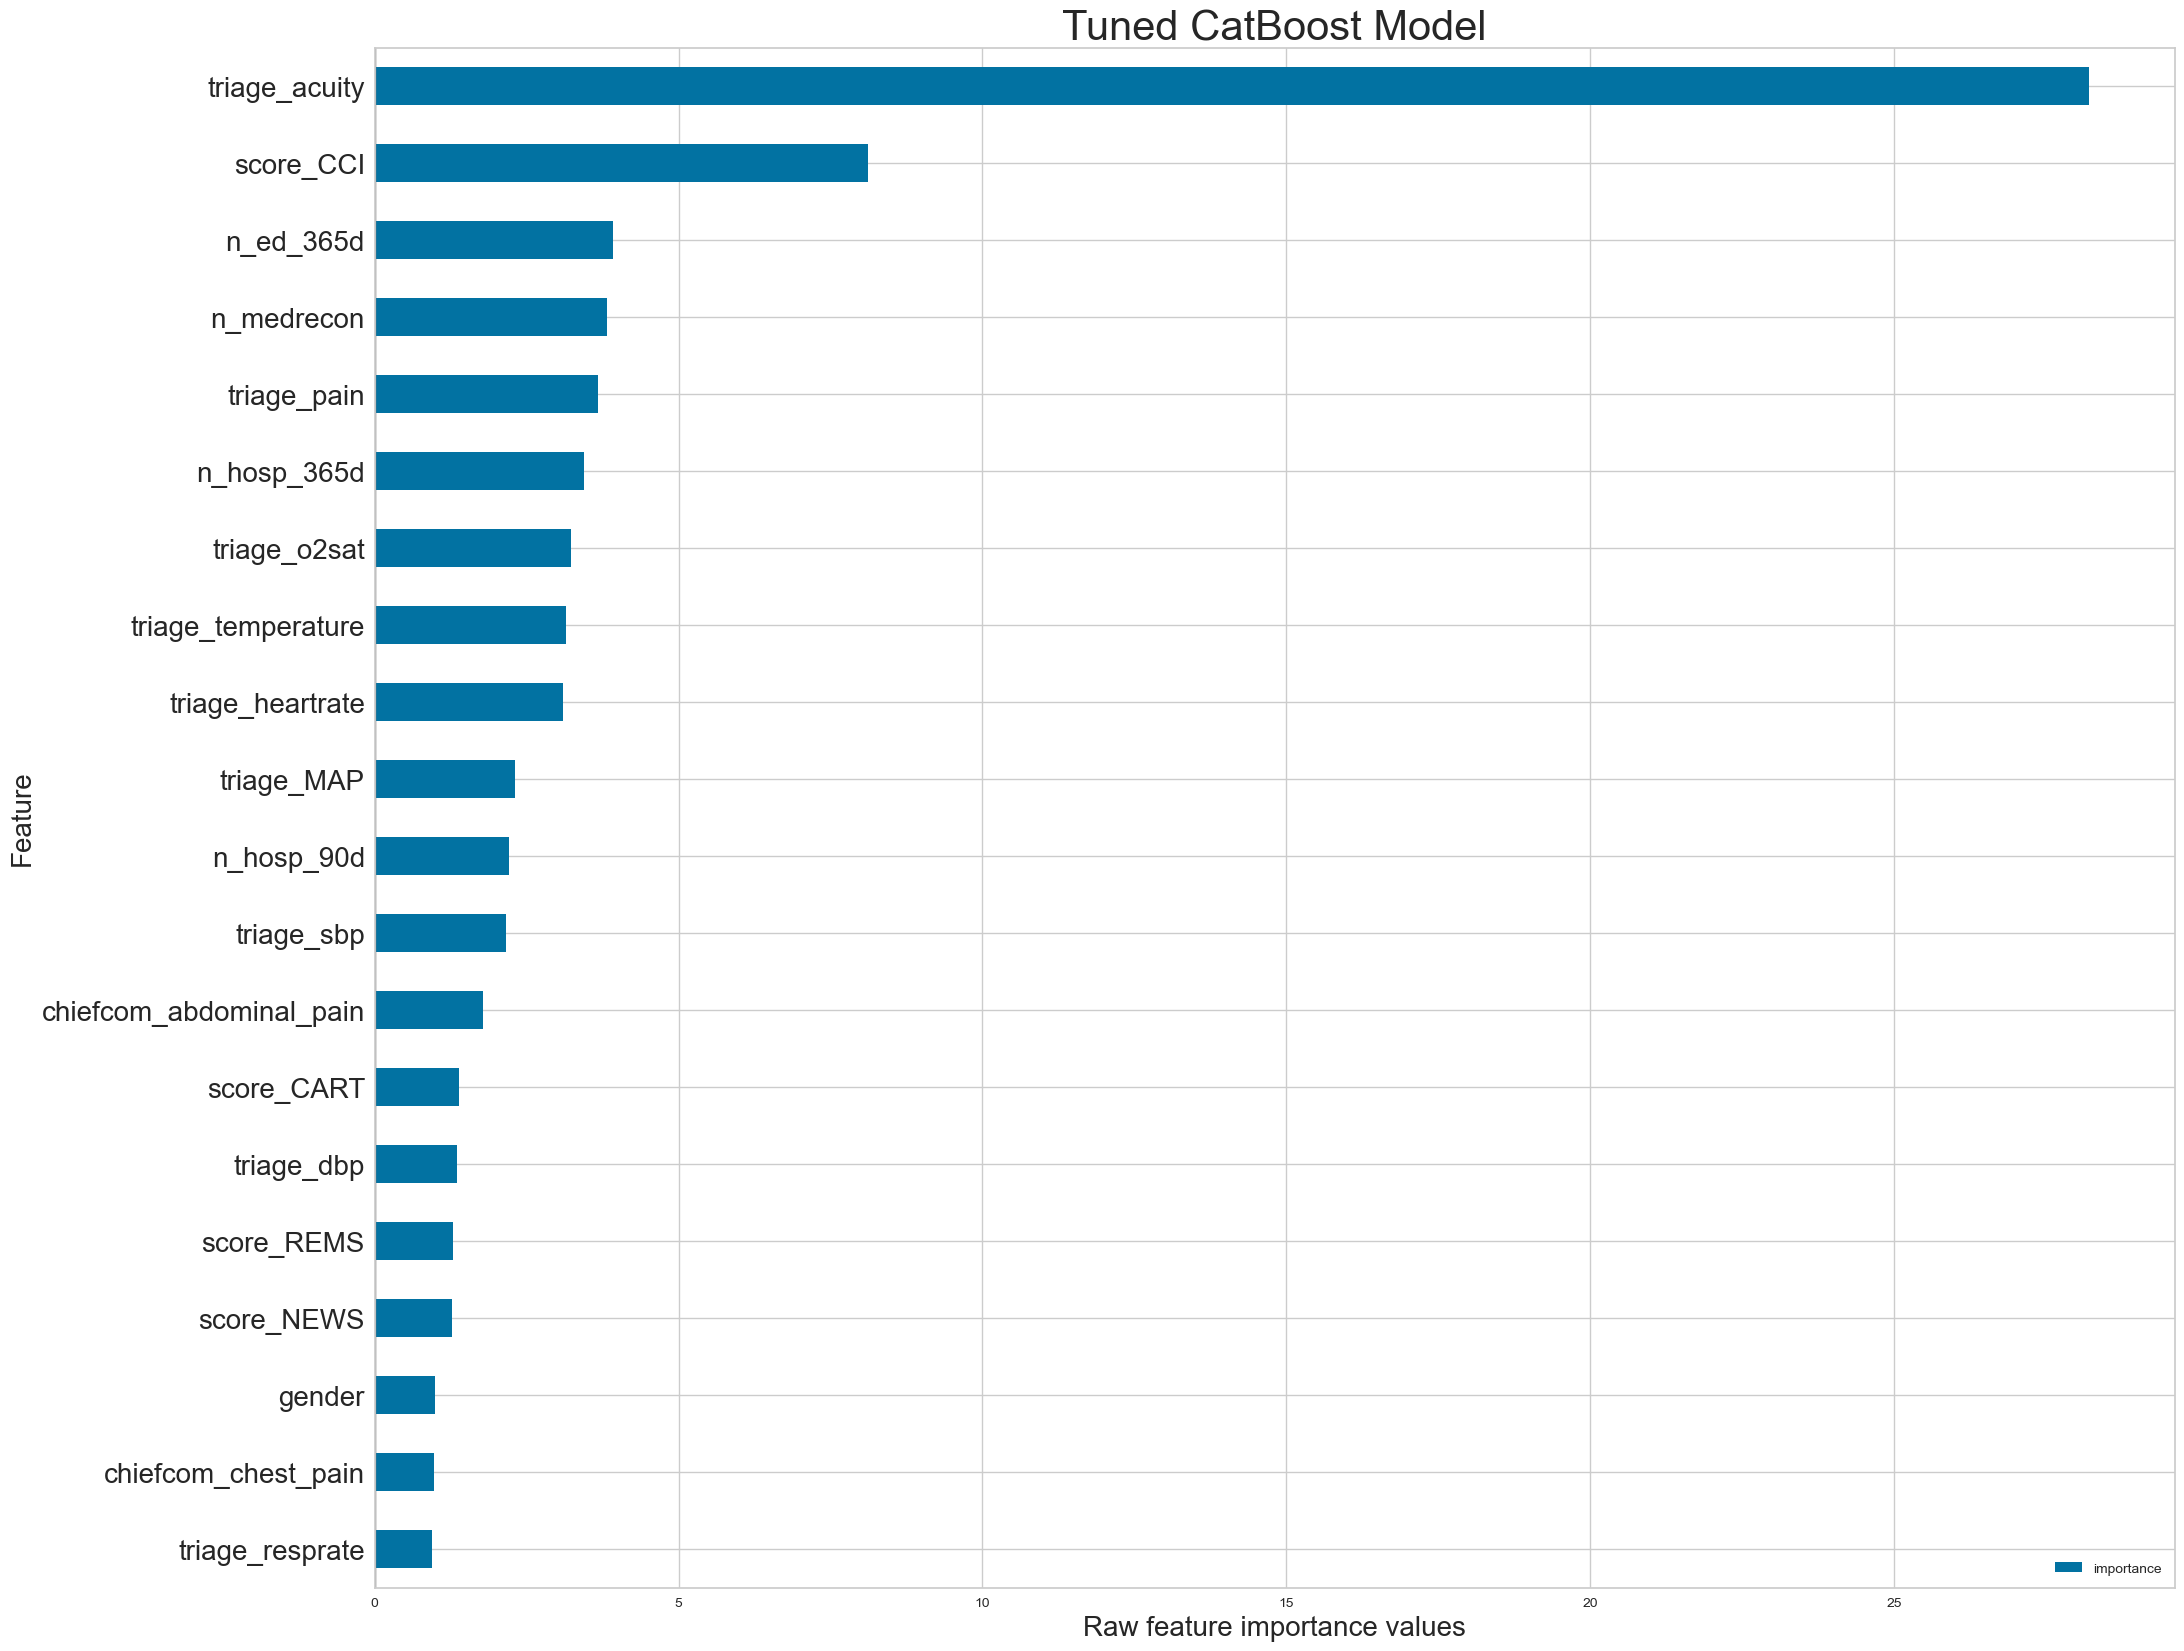

In [139]:
sorted_feature_importance = catboost_feature_importance.sort_values(by='importance',key=lambda x:abs(x),ascending=False)[:20].set_index('features')

sorted_feature_importance.sort_values(by='importance',key=lambda x:abs(x)).plot.barh(figsize=(30, 20))
plt.title("Tuned CatBoost Model", fontsize=30)
plt.xlabel("Raw feature importance values", fontsize=20)
plt.ylabel('Feature',fontsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)